# Apollo Landing Site Thermal Model - Dynamic Version

## Single-Point Lunar Thermal Simulation with Apollo Validation

This notebook provides a modular, dynamic thermal model for Apollo landing sites with:
- **Easy parameter adjustment**: Change coordinates, time, depth, density models
- **Single-point computation**: Fast solving for individual locations
- **Multiple density models**: Switch between discrete layers, Hayne exponential, or custom models
- **Apollo validation**: Compare with Apollo 15 & 17 Heat Flow Experiment data
- **Shadowing control**: Sunscale factor for partial shadowing effects

**Key Difference from Global Model**: This solves only for the specified coordinate point,
making it much faster and easier to iterate on parameters.

**Author**: Adapted from polar thermal model  
**Date**: January 2026

## 1. Setup and Imports

In [80]:
#!/usr/bin/env python3
"""
Dynamic Apollo Thermal Model
Single-point solver with modular density models
"""

import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from matplotlib import gridspec
from numba import njit, prange
from pathlib import Path
import re
from datetime import datetime, timezone

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ Imports successful")
print("✓ Ready to run thermal model")


# ════════════════════════════════════════════════════════════════════════════
# OPTIONAL FEATURE TOGGLES
# ════════════════════════════════════════════════════════════════════════════
# When you click "Run All", all these are False, so nothing auto-executes
# You just go straight to Cell 55 (Interactive Runner) to do your work
# 
# To enable optional features: change specific toggles to True
# ════════════════════════════════════════════════════════════════════════════

RUN_INITIAL_EXAMPLE = True              # Auto-run validation at Apollo 15
SHOW_DIURNAL_PLOT = True                # Auto-show diurnal plot
SHOW_HEATMAP = True                     # Auto-show heatmap
SHOW_APOLLO_COMPARISON_AUTO = True      # Auto-compare with Apollo
RUN_HAYNE_COMPARISON = True            # Auto-run Hayne comparison
RUN_ADVANCED_ANALYSIS = True            # Enable advanced analysis
SHOW_DETAILED_COMPARISON = True         # Auto-show detailed plots
RUN_PARAMETER_SENSITIVITY = True        # Auto-run sensitivity

print("="*70)
print("SETUP COMPLETE - All optional features enabled")
print("="*70)
print("➜ Go to Cell 55 (Interactive Model Runner) to run your models")
print("="*70 + "\n")


✓ Imports successful
✓ Ready to run thermal model
SETUP COMPLETE - All optional features enabled
➜ Go to Cell 55 (Interactive Model Runner) to run your models



## 2. Configuration Parameters

### 🎯 **ENERGY BALANCE PARAMETERS** (Adjust these to fix cold bias)

**If your models are too cold compared to Apollo data:**
- Increase `SUNSCALE` (1.05 to 1.15)
- Decrease `ALBEDO` (0.10 to 0.08)

**If your models are too hot:**
- Decrease `SUNSCALE` (0.95 to 0.90)
- Increase `ALBEDO` (0.14 to 0.16)

**Start with:** SUNSCALE=1.10, ALBEDO=0.10 for Apollo 15


In [81]:
# ═══════════════════════════════════════════════════════════════════════════════
# 🌍 SIMULATION CONFIGURATION - Main Settings for the Thermal Model
# ═══════════════════════════════════════════════════════════════════════════════
# This section controls the basic simulation parameters. Think of it like tuning
# a guitar - you adjust these values to match real-world observations (Apollo data)
#
# HOW IT WORKS: The Moon has surface properties that control temperature:
#  1. SUNSCALE: Controls how much solar energy hits the surface
#  2. ALBEDO: Controls how much solar energy bounces back (vs. absorbed)
#  3. EMISSIVITY: Controls how well the surface radiates heat to space
# ═══════════════════════════════════════════════════════════════════════════════

# ────────────────────────────────────────────────────────────────────────────────
# ENERGY BALANCE CALIBRATION (ADJUST THESE TO FIT APOLLO DATA!)
# ────────────────────────────────────────────────────────────────────────────────
# These parameters control the thermal energy balance at the surface.
# We tune them to match real Apollo measurement data.
#
# Quick tuning guide:
#  If your models are TOO COLD (negative errors), INCREASE these values
#  If your models are TOO HOT (positive errors), DECREASE these values

SUNSCALE = 1.10   # Solar flux multiplier: how much sun this location gets
                  #   1.0 = standard solar flux
                  #   1.10 = 10% more sun (shadowed areas, dust composition)
                  #   Range: 0.95-1.15 (physical limits for the Moon)
                  
ALBEDO = 0.09     # Surface reflectance (Bond albedo): how shiny the surface is
                  #   0.05 = dark surface (absorbs more heat - gets hotter)
                  #   0.09 = typical lunar regolith
                  #   0.15 = bright highland material (more reflective - cooler)
                  #   Range: 0.07-0.14 (observed across lunar surface)
                  
EMISSIVITY = 0.95 # Surface emissivity: how well it radiates heat to space
                  #   1.0 = perfect blackbody (radiates all heat)
                  #   0.95 = typical lunar regolith (very good radiator)
                  #   0.85 = smooth surfaces (worse at radiating heat)
                  #   Range: 0.90-0.98 (doesn't vary much - rarely needs tuning)

# Physical ranges:
#   SUNSCALE: 0.95-1.15 (accounts for uncertainties and local conditions)
#   ALBEDO: 0.07-0.14 (varies across lunar surface)
#   EMISSIVITY: 0.90-0.98 (depends on surface roughness)
# ============================================================================


# --- LOCATION ---
# Apollo 15: lat=26.1323, lon=3.6285 (Hadley-Apennine)
# Apollo 17: lat=20.1911, lon=30.7723 (Taurus-Littrow)
TARGET_LAT = 26.1323    # Latitude in degrees (positive = North)
TARGET_LON = 3.6285     # Longitude in degrees (0-360 East)

# --- TIME PARAMETERS ---
UTC_TIME = None  # Set to datetime object for specific time, or None for steady-state
# Example: UTC_TIME = datetime(2024, 1, 15, 12, 0, 0, tzinfo=timezone.utc)
NDAYS = 3        # Number of lunar days to simulate (for spin-up)

# --- DEPTH RANGE ---
DEPTH_MIN = 0.0   # Minimum depth to analyze (m)
DEPTH_MAX = 3.0   # Maximum depth to analyze (m)

# --- DENSITY MODEL SELECTION ---
# Options: 'discrete', 'hayne_exponential', 'custom'
# NOTE: 'hayne_exponential' uses actual Hayne et al. 2017 Diviner parameters
#       'discrete' uses Apollo 15/17 drill core measurements
DENSITY_MODEL = 'discrete'

# --- THERMAL PARAMETERS ---
CHI = 2.7         # Radiative conductivity parameter (typical regolith: 2.7)

# --- INITIAL CONDITIONS ---
T_INIT = 250.0    # Initial temperature (K) for model spin-up
T_init = T_INIT       # Alias used by comparison/sensitivity cells

print(f"""\n{'='*70}
SIMULATION CONFIGURATION
{'='*70}
Location:      {TARGET_LAT:.4f}°N, {TARGET_LON:.4f}°E
Density Model: {DENSITY_MODEL}
Depth Range:   {DEPTH_MIN:.2f} - {DEPTH_MAX:.2f} m
Chi Parameter: {CHI}
Sunscale:      {SUNSCALE} (0=shadow, 1=full sun)
Simulation:    {NDAYS} lunar days
{'='*70}\n""")


SIMULATION CONFIGURATION
Location:      26.1323°N, 3.6285°E
Density Model: discrete
Depth Range:   0.00 - 3.00 m
Chi Parameter: 2.7
Sunscale:      1.1 (0=shadow, 1=full sun)
Simulation:    3 lunar days



## 🎯 Quick Parameter Selector

**Use this cell to quickly change location, time, and H-parameter without scrolling**

## 3. Apollo Heat Flow Experiment Data

Measured subsurface temperatures from Apollo missions

In [82]:
# ========================= APOLLO MEASUREMENT DATA =========================
# Format: (depth_m, temperature_K)
# Source: Apollo Heat Flow Experiment data

APOLLO_15_DATA = [
    (0.40, 253.0), (0.54, 252.9), (0.64, 252.8), (0.73, 252.8),
    (0.91, 252.9), (1.01, 252.8), (1.29, 253.1), (1.39, 253.3)
]

APOLLO_17_DATA = [
    (0.15, 255.5), (0.67, 256.3), (1.31, 256.4), (1.40, 256.2),
    (1.69, 256.4), (1.78, 256.6), (1.86, 256.6), (1.96, 256.6),
    (2.24, 256.8), (2.34, 256.9)
]

# Dictionary for easy access
APOLLO_DATA = {
    'Apollo 15': APOLLO_15_DATA,
    'Apollo 17': APOLLO_17_DATA
}

print("✓ Apollo measurement data loaded")
print(f"  Apollo 15: {len(APOLLO_15_DATA)} measurements")
print(f"  Apollo 17: {len(APOLLO_17_DATA)} measurements")

✓ Apollo measurement data loaded
  Apollo 15: 8 measurements
  Apollo 17: 10 measurements


## 4. Physical Constants

In [83]:
# ========================= PHYSICAL CONSTANTS =========================
R_MOON = 1737.4e3        # Moon radius (m)
sigma = 5.670374419e-8   # Stefan-Boltzmann constant (W/m²/K⁴)
S0 = 1361.0              # Solar constant at 1 AU (W/m²)
eps = 0.95               # Surface emissivity
A0 = 0.09                # Bond albedo
a_ref = 0.06             # Reflectance parameter
b_ref = 0.25             # Reflectance parameter
Q_basal = 18e-3          # Basal heat flux (W/m²)
LUNAR_DAY = 29.53*86400.0  # Synodic lunar day (seconds)

# ========================= DEPTH GRID CONFIGURATION =========================
# Fine grid near surface (where Apollo measurements are), coarser at depth
DZ_FINE = 0.005      # 5mm spacing for 0-10cm (captures near-surface gradients)
DZ_COARSE = 0.02     # 2cm spacing for 10cm-3m
DEPTH_FINE = 0.10    # Fine grid extends to 10cm depth
DEPTH = 3.0          # Total depth (m) - deeper than Apollo drills for basal BC

# ========================= DISCRETE LAYER BOUNDARIES =========================
# Based on Apollo regolith core analysis
Z_LAYER1 = 0.02      # 0-2cm: fluffy surface dust (very low density)
Z_LAYER2 = 0.20      # 2-20cm: transitional compaction zone
# Below 20cm: more consolidated regolith approaching bedrock

print("✓ Physical constants defined")
print(f"  Lunar day: {LUNAR_DAY/86400:.2f} Earth days")
print(f"  Solar flux: {S0} W/m²")
print(f"  Depth grid: {DZ_FINE*1000:.1f}mm (0-10cm), {DZ_COARSE*100:.1f}cm (10cm-3m)")

✓ Physical constants defined
  Lunar day: 29.53 Earth days
  Solar flux: 1361.0 W/m²
  Depth grid: 5.0mm (0-10cm), 2.0cm (10cm-3m)


## 5. Density and Thermal Property Models

### Multiple models for easy comparison and customization

In [84]:
# ========================= DENSITY MODEL 1: DISCRETE LAYERS =========================
# Based on Apollo 15/17 core measurements
# Simple piecewise linear model with distinct layers

@njit(cache=True, fastmath=True, inline='always')
def density_discrete(z):
    """
    Discrete layer density model (kg/m³) — NOW WITH DYNAMIC LAYER 1 BOUNDARY
    
    Layer boundaries controlled by set_layer1_h(H_value):
    
    Layer 1 (0 to H):      ρ = 1100 kg/m³ (fluffy surface dust)
    Layer 2 (H to 20cm):   ρ = 1100→1700 kg/m³ (linear transition)
    Layer 3 (>20cm):       ρ = 1700→1800 kg/m³ (gradual compaction)
    
    Default H = 0.02 m (2 cm) matches original Apollo-based boundaries.
    Call set_layer1_h(0.07) to make Layer 1 = 0-7 cm for comparison with Hayne.
    """
    # Use dynamic H if set via set_layer1_h(), otherwise fall back to Z_LAYER1
    H_layer = _H_LAYER1_CURRENT if _H_LAYER1_CURRENT > 0 else Z_LAYER1
    LAYER2 = 0.20  # Fixed Layer 2 boundary at 20 cm
    
    if z < H_layer:  # Layer 1: 0 to H
        return 1100.0
    elif z < LAYER2:  # Layer 2: H to 20cm
        return 1100.0 + (1700.0 - 1100.0) * (z - H_layer) / (LAYER2 - H_layer)
    else:  # Layer 3: >20cm
        return 1700.0 + (1800.0 - 1700.0) * min(1.0, (z - LAYER2) / 2.80)

@njit(cache=True, fastmath=True, inline='always')
def k_solid_discrete(z):
    """
    Solid (contact) thermal conductivity for discrete model (W/m/K)
    Temperature-independent component only
    NOW WITH DYNAMIC LAYER 1 BOUNDARY (controlled by set_layer1_h)
    """
    # Use dynamic H if set, otherwise fall back to Z_LAYER1
    H_layer = _H_LAYER1_CURRENT if _H_LAYER1_CURRENT > 0 else Z_LAYER1
    LAYER2 = 0.20
    
    if z < H_layer:  # Layer 1: 0 to H
        return 1.0e-3
    elif z < LAYER2:  # Layer 2: H to 20cm
        return 1.0e-3 + (1.0e-2 - 1.0e-3) * (z - H_layer) / (LAYER2 - H_layer)
    else:  # Layer 3: >20cm
        return 1.2e-2

# ========================= DENSITY MODEL 2: HAYNE ET AL. 2017 =========================
# ACTUAL PARAMETERS from published paper
# Source: "Global Regolith Thermophysical Properties of the Moon From the 
#          Diviner Lunar Radiometer Experiment" (Hayne et al., 2017)
# DOI: 10.1002/2017JE005387
# Based on LRO Diviner infrared observations (global mapping)

@njit(cache=True, fastmath=True, inline='always')
def density_hayne_exponential(z):
    """
    Hayne et al. 2017 exponential density model (kg/m³)
    
    ρ(z) = ρ_d - (ρ_d - ρ_s) * exp(-z/H)
    
    Parameters from Diviner global observations:
    - ρ_s = 1100 kg/m³ (surface density)
    - ρ_d = 1800 kg/m³ (deep density, >1m)
    - H = 0.07 m (7 cm scale height - global average)
    
    Physical interpretation:
    - Represents gradual compaction due to overburden and impact gardening
    - H is the 'e-folding' depth: at z=H, achieves 63% of total compaction
    - Smooth transition (no sharp boundaries)
    - At z=7cm: ρ ≈ 1543 kg/m³
    """
    rho_s = 1100.0
    rho_d = 1800.0
    H = 0.07  # 7 cm from Diviner global mapping (Hayne et al. 2017)
    
    return rho_d - (rho_d - rho_s) * np.exp(-z / H)

@njit(cache=True, fastmath=True, inline='always')
def k_solid_hayne_exponential(z):
    """
    Solid (contact) conductivity for Hayne 2017 model (W/m/K)
    
    Derived from measured Diviner thermal conductivity:
    - Surface (z=0, ρ=1100): K ≈ 7.4×10⁻⁴ W/m/K at T=250K
    - At 1m (z=1.0, ρ=1800): K ≈ 3.4×10⁻³ W/m/K at T=250K
    
    Contact conductivity scales with density (better grain contact).
    Note: Total K also includes radiative term B*T³ (added later)
    where B ≈ 10⁻¹¹ W/m/K⁴ for 100 μm grain spacing
    """
    # Get density at this depth
    rho_s = 1100.0
    rho_d = 1800.0
    H = 0.07
    rho = rho_d - (rho_d - rho_s) * np.exp(-z / H)
    
    # Measured conductivity endpoints (from Hayne et al. 2017 abstract)
    # At T≈250K, radiative term contributes ~0.15 mW/m/K
    k_surf = 7.4e-4   # W/m/K at surface
    k_1m = 3.4e-3     # W/m/K at 1m depth
    
    # Scale conductivity with density (linear approximation)
    rho_norm = (rho - rho_s) / (rho_d - rho_s)
    k_c = k_surf + (k_1m - k_surf) * rho_norm
    
    return k_c


# ========================= GLOBAL VARIABLES FOR DYNAMIC H-PARAMETER =========================
# These globals allow numba-compiled functions to access H-value for sensitivity testing
_HAYNE_H_CURRENT = 0.07  # Current H-value (meters) for Hayne model, default 7cm
_H_LAYER1_CURRENT = 0.07  # Current Layer 1 boundary (meters) for 3-layer model with dynamic H

def set_hayne_h(h_value_m):
    """Update the Hayne H-parameter for subsequent model runs (in meters)"""
    global _HAYNE_H_CURRENT
    _HAYNE_H_CURRENT = float(h_value_m)

def set_layer1_h(h_value_m):
    """Update the Layer 1 boundary height for 3-layer model (in meters)"""
    global _H_LAYER1_CURRENT
    _H_LAYER1_CURRENT = float(h_value_m)

# ========================= DENSITY MODEL 2b: HAYNE WITH DYNAMIC H =========================
@njit(cache=True, fastmath=True, inline='always')
def density_hayne_dynamic(z):
    """
    Hayne exponential model with DYNAMIC H-parameter.
    Uses global _HAYNE_H_CURRENT for the scale height.
    
    ρ(z) = ρ_d - (ρ_d - ρ_s) * exp(-z/H)
    
    where H is set by _HAYNE_H_CURRENT (in meters)
    Default: H = 0.07m (7cm) from Hayne et al. 2017
    """
    rho_s = 1100.0
    rho_d = 1800.0
    # Use current H-value or default
    H = _HAYNE_H_CURRENT if _HAYNE_H_CURRENT > 0 else 0.07
    
    return rho_d - (rho_d - rho_s) * np.exp(-z / H)

@njit(cache=True, fastmath=True, inline='always')
def k_solid_hayne_dynamic(z):
    """
    Solid (contact) conductivity for Hayne dynamic model (W/m/K)
    Scales with density from density_hayne_dynamic()
    """
    rho_s = 1100.0
    rho_d = 1800.0
    H = _HAYNE_H_CURRENT if _HAYNE_H_CURRENT > 0 else 0.07
    
    rho = rho_d - (rho_d - rho_s) * np.exp(-z / H)
    
    # Measured conductivity endpoints (from Hayne et al. 2017)
    k_surf = 7.4e-4   # W/m/K at surface
    k_1m = 3.4e-3     # W/m/K at 1m depth
    
    # Scale conductivity with density (linear approximation)
    rho_norm = (rho - rho_s) / (rho_d - rho_s)
    k_c = k_surf + (k_1m - k_surf) * rho_norm
    
    return k_c

# ========================= 3-LAYER MODEL WITH DYNAMIC H-BOUNDARIES =========================
# Uses H-value to define layer boundaries
# Layer 1: 0 to H(m)         - fluffy surface layer
# Layer 2: H(m) to 0.20(m)   - transitional zone  
# Layer 3: 0.20(m) and deeper - consolidated regolith

@njit(cache=True, fastmath=True, inline='always')
def density_hayne_3layer_dynamic(z):
    """
    3-layer Hayne model where layer boundaries depend on H-parameter.
    
    Layer 1 (0 to H):     ρ = 1100 kg/m³ (fluffy, H-dependent)
    Layer 2 (H to 20cm):  ρ = linear interpolation from 1100 to 1700
    Layer 3 (>20cm):      ρ = 1700 to 1800 (gradual compaction)
    
    H is controlled by set_layer1_h() function before model runs
    """
    H_layer = _H_LAYER1_CURRENT if _H_LAYER1_CURRENT > 0 else 0.07
    LAYER2 = 0.20
    
    if z < H_layer:  # Layer 1: 0 to H
        return 1100.0
    elif z < LAYER2:  # Layer 2: H to 20cm
        # Linear transition from 1100 to 1700
        return 1100.0 + (1700.0 - 1100.0) * (z - H_layer) / (LAYER2 - H_layer)
    else:  # Layer 3: >20cm
        # Gradual compaction from 1700 to 1800
        return 1700.0 + (1800.0 - 1700.0) * min(1.0, (z - LAYER2) / 2.80)

@njit(cache=True, fastmath=True, inline='always')
def k_solid_hayne_3layer_dynamic(z):
    """
    Thermal conductivity for 3-layer Hayne model with dynamic H.
    Scales similarly to discrete model but with H-dependent boundaries.
    """
    H_layer = _H_LAYER1_CURRENT if _H_LAYER1_CURRENT > 0 else 0.07
    LAYER2 = 0.20
    
    if z < H_layer:  # Layer 1: 0 to H
        return 1.0e-3
    elif z < LAYER2:  # Layer 2: H to 20cm
        return 1.0e-3 + (1.0e-2 - 1.0e-3) * (z - H_layer) / (LAYER2 - H_layer)
    else:  # Layer 3: >20cm
        return 1.2e-2


# ========================= DENSITY MODEL 3: CUSTOM (TEMPLATE) =========================
# Add your own density model here!
# This is a template you can modify for custom property profiles

@njit(cache=True, fastmath=True, inline='always')
def density_custom(z):
    """
    Custom density model (kg/m³)
    
    MODIFY THIS FUNCTION to implement your own density profile
    
    Examples:
    - Power law: ρ = ρ0 * z^n
    - Multiple exponentials: ρ = ρ1*(1-exp(-z/H1)) + ρ2*(1-exp(-z/H2))
    - Data-driven: interpolate from measurements
    """
    # Placeholder: same as discrete for now
    return density_discrete(z)

@njit(cache=True, fastmath=True, inline='always')
def k_solid_custom(z):
    """
    Custom solid conductivity (W/m/K)
    
    MODIFY THIS FUNCTION to match your density model
    """
    # Placeholder: same as discrete for now
    return k_solid_discrete(z)

# ========================= 3-LAYER MODEL WITH DYNAMIC H-BOUNDARIES =========================
# NEW: Uses H-value to define layer boundaries
# Layer 1: 0 to H(m)         - fluffy surface layer
# Layer 2: H(m) to 0.20(m)   - transitional zone
# Layer 3: 0.20(m) and deeper - consolidated regolith


# ========================= MODEL SELECTION FUNCTION =========================
@njit(cache=True, fastmath=True, inline='always')
def get_density(z, model_id):
    """Select density model based on configuration"""
    if model_id == 0:  # discrete
        return density_discrete(z)
    elif model_id == 1:  # hayne_exponential - UPDATED to use dynamic H-value
        return density_hayne_dynamic(z)  # Uses _HAYNE_H_CURRENT global
    elif model_id == 2:  # custom
        return density_custom(z)
    else:
        return density_discrete(z)  # default

@njit(cache=True, fastmath=True, inline='always')
def get_k_solid(z, model_id):
    """Select solid conductivity model based on configuration"""
    if model_id == 0:  # discrete
        return k_solid_discrete(z)
    elif model_id == 1:  # hayne_exponential - UPDATED to use dynamic H-value
        return k_solid_hayne_dynamic(z)  # Uses _HAYNE_H_CURRENT global
    elif model_id == 2:  # custom
        return k_solid_custom(z)
    else:
        return k_solid_discrete(z)  # default

# ========================= HEAT CAPACITY =========================
@njit(cache=True, fastmath=True, inline='always')
def heat_capacity(T):
    """
    Specific heat capacity (J/kg/K)
    From Hemingway et al. (1973) - temperature-dependent polynomial
    """
    c = np.array([-3.6125, 2.7431, 2.3616e-3, -1.234e-5, 8.9093e-9])
    return c[0] + T*(c[1] + T*(c[2] + T*(c[3] + T*c[4])))

# ========================= TOTAL THERMAL CONDUCTIVITY =========================
@njit(cache=True, fastmath=True, inline='always')
def thermal_conductivity(T, z, chi_param, model_id):
    """
    Total thermal conductivity (W/m/K)
    
    k_total = k_solid * (1 + chi * (T/T_ref)³)
    
    - k_solid: solid (contact) conductivity
    - chi: radiative conductivity parameter
    - T_ref: reference temperature (350 K)
    """
    k_s = get_k_solid(z, model_id)
    T_ref = 350.0
    return k_s * (1.0 + chi_param * (T / T_ref)**3)

# Convert model name to ID
MODEL_ID_MAP = {'discrete': 0, 'hayne_exponential': 1, 'custom': 2}
MODEL_ID = MODEL_ID_MAP.get(DENSITY_MODEL, 0)

print(f"\n✓ Density models defined:")
print(f"  1. Discrete layers (Apollo measurements)")
print(f"  2. Hayne exponential (smooth compaction)")
print(f"  3. Custom (user-defined template)")
print(f"\n  → Selected model: {DENSITY_MODEL} (ID={MODEL_ID})")

# Display model differences
print("\nModel Characteristics:")
if MODEL_ID == 0:
    print("  DISCRETE: Sharp layers at 2cm & 20cm (Apollo cores)")
    print("  → Good for: Apollo site validation, layered structure effects")
elif MODEL_ID == 1:
    print("  HAYNE 2017: Smooth exponential, H=7cm (Diviner global)")
    print("  → Good for: Non-Apollo sites, global applications")
    print("  → Surface K: 0.74 mW/m/K, 1m K: 3.4 mW/m/K")
elif MODEL_ID == 2:
    print("  CUSTOM: User-defined density profile")
    print("  → Modify density_custom() for your application")



✓ Density models defined:
  1. Discrete layers (Apollo measurements)
  2. Hayne exponential (smooth compaction)
  3. Custom (user-defined template)

  → Selected model: discrete (ID=0)

Model Characteristics:
  DISCRETE: Sharp layers at 2cm & 20cm (Apollo cores)
  → Good for: Apollo site validation, layered structure effects


## 6. DEM Loading and Processing

Load LOLA DEM data and extract topography at target location

In [85]:
# ========================= PDS3 LABEL PARSING =========================
def parse_pds3_label(lbl_path: Path) -> dict:
    """Parse PDS3 label file to extract metadata"""
    txt = lbl_path.read_text(encoding='utf-8', errors='ignore')
    label = {}
    
    # Remove comments
    clean = re.sub(r'/\*.*?\*/', '', txt, flags=re.S)
    
    # Parse key-value pairs
    for line in clean.splitlines():
        line = line.strip()
        if not line or line.startswith('//'):
            continue
        m = re.match(r'^([A-Za-z0-9_\.]+)\s*=\s*(.+)$', line)
        if m:
            k, v = m.group(1).upper(), m.group(2).strip()
            v = re.split(r'//', v)[0].strip()
            v = v.strip('"').strip("'").replace('<', '').replace('>', '')
            label[k] = v
    
    # Find image file reference
    m = re.search(r'\^IMAGE\s*=\s*"?([A-Za-z0-9_\-\.]+\.(?:IMG|JP2))"?', txt, flags=re.I)
    label['__IMAGE_FILE__'] = m.group(1) if m else None
    
    return label

def parse_numeric_field(value_str, default=0.0):
    """Parse numeric field that may contain units"""
    if value_str is None:
        return default
    try:
        return float(str(value_str).split()[0])
    except (ValueError, IndexError):
        return default

def dtype_from_pds3(bits: int, sample_type: str) -> np.dtype:
    """Determine numpy dtype from PDS3 parameters"""
    st = (sample_type or 'LSB_INTEGER').upper()
    endian = '>' if any(tok in st for tok in ('MSB', 'SUN', 'NETWORK')) else '<'
    if 'UNSIGNED' in st:
        base = {8: 'u1', 16: 'u2', 32: 'u4'}[bits]
    elif 'REAL' in st or 'FLOAT' in st:
        base = {32: 'f4', 64: 'f8'}[bits]
    else:
        base = {8: 'i1', 16: 'i2', 32: 'i4'}[bits]
    return np.dtype(endian + base)

def read_img_with_progress(img_path: Path, label: dict) -> np.ndarray:
    """Read PDS3 IMG file with progress bar"""
    lines = int(parse_numeric_field(label.get('LINES'), 720))
    samples = int(parse_numeric_field(label.get('LINE_SAMPLES') or label.get('SAMPLES'), 1440))
    bits = int(parse_numeric_field(label.get('SAMPLE_BITS'), 16))
    stype = str(label.get('SAMPLE_TYPE') or 'LSB_INTEGER')
    rec_bytes = int(parse_numeric_field(label.get('RECORD_BYTES'), 0))
    lbl_records = int(parse_numeric_field(label.get('LABEL_RECORDS'), 0))
    lprefix = int(parse_numeric_field(label.get('LINE_PREFIX_BYTES'), 0))
    lsuffix = int(parse_numeric_field(label.get('LINE_SUFFIX_BYTES'), 0))
    
    dtype = dtype_from_pds3(bits, stype)
    byte_offset = lbl_records * rec_bytes if (lbl_records and rec_bytes) else 0
    row_bytes = lprefix + samples * dtype.itemsize + lsuffix
    arr = np.empty((lines, samples), dtype=np.float32)
    
    with open(img_path, 'rb') as fh, tqdm(total=lines, unit='row', desc=f'Loading {img_path.name}') as pbar:
        fh.seek(byte_offset, 0)
        for i in range(lines):
            buf = fh.read(row_bytes)
            if len(buf) != row_bytes:
                raise RuntimeError(f'Unexpected EOF at line {i}')
            start = lprefix
            end = lprefix + samples * dtype.itemsize
            row = np.frombuffer(buf[start:end], dtype=dtype, count=samples).astype(np.float32, copy=False)
            arr[i, :] = row
            pbar.update(1)
    
    return arr

print("✓ DEM parsing functions defined")

✓ DEM parsing functions defined


In [86]:
# ========================= LOAD LDEM DATA =========================
def load_ldem():
    """Load LOLA DEM from current directory or common locations"""
    
    # Search directories (current directory first)
    search_dirs = [
        Path('.'),                    # Current directory (where notebook is)
        Path('/mnt/project'),         # Claude project directory
        Path('/home/claude'),         # Claude home
    ]
    
    # LDEM products in order of preference (higher resolution first)
    patterns = [
        ('LDEM_512', 'LDEM_512*.LBL'),  # 60 m/pix
        ('LDEM_256', 'LDEM_256*.LBL'),  # 120 m/pix
        ('LDEM_128', 'LDEM_128*.LBL'),  # 240 m/pix
        ('LDEM_64', 'LDEM_64*.LBL'),    # 480 m/pix
        ('LDEM_16', 'LDEM_16*.LBL'),    # ~1900 m/pix
        ('LDEM_4', 'LDEM_4*.LBL'),      # ~7600 m/pix
    ]
    
    for search_dir in search_dirs:
        if not search_dir.exists():
            continue
        
        for prod_name, pattern in patterns:
            for lbl_path in search_dir.glob(pattern):
                if lbl_path.exists():
                    label = parse_pds3_label(lbl_path)
                    ref = label.get('__IMAGE_FILE__')
                    if ref:
                        data_path = lbl_path.parent / ref
                        if data_path.exists():
                            print(f"\n{'='*70}")
                            print(f"Loading: {lbl_path.name}")
                            print(f"Product: {prod_name}")
                            print(f"Location: {search_dir}")
                            
                            # Read the data
                            if data_path.suffix.upper() == '.JP2':
                                try:
                                    import imageio.v3 as iio
                                    arr = iio.imread(data_path)
                                    arr = arr[..., 0] if arr.ndim == 3 else arr
                                    arr = arr.astype(np.float32)
                                except ImportError:
                                    raise ImportError("imageio required for JP2")
                            else:
                                arr = read_img_with_progress(data_path, label)
                            
                            # Apply scaling to get elevation
                            scale = parse_numeric_field(label.get('SCALING_FACTOR'), 1.0)
                            offset = parse_numeric_field(label.get('OFFSET'), 0.0)
                            elev_m = (arr * scale) + offset - 1_737_400.0
                            
                            # Get pixel size
                            map_res = parse_numeric_field(label.get('MAP_RESOLUTION'), 4.0)  # pix/deg
                            pixel_deg = 1.0 / map_res
                            pixel_m = pixel_deg * np.pi * R_MOON / 180.0
                            
                            print(f"✓ Loaded: {elev_m.shape[0]}×{elev_m.shape[1]} pixels")
                            print(f"  Resolution: {map_res} pix/deg ({pixel_m:.1f} m/pixel)")
                            print(f"  Coverage: {label.get('MINIMUM_LATITUDE')}° to {label.get('MAXIMUM_LATITUDE')}°")
                            print(f"{'='*70}\n")
                            
                            return elev_m, pixel_m, map_res, label
    
    raise FileNotFoundError(
        "No LDEM files found! Please ensure LDEM_*.LBL and LDEM_*.IMG files "
        "are in the same directory as this notebook."
    )

# Load DEM
LDEM_m, pixel_m, map_res, ldem_label = load_ldem()
H, W = LDEM_m.shape

print(f"✓ DEM ready for analysis")
print(f"  Grid size: {H} × {W}")
print(f"  Pixel size: {pixel_m:.1f} m")


Loading: LDEM_4.LBL
Product: LDEM_4
Location: .


Loading LDEM_4.IMG: 100%|██████████| 720/720 [00:00<00:00, 32719.01row/s]

✓ Loaded: 720×1440 pixels
  Resolution: 4.0 pix/deg (7580.8 m/pixel)
  Coverage: -90 deg° to 90 deg°

✓ DEM ready for analysis
  Grid size: 720 × 1440
  Pixel size: 7580.8 m


## 7. Extract Target Point from DEM

Get topography, slope, and aspect at the specified coordinate

In [87]:
# ========================= COORDINATE TO PIXEL CONVERSION =========================
def latlon_to_pixel(lat_deg, lon_deg, H, W, map_res):
    """
    Convert lat/lon to pixel coordinates in LDEM
    
    LDEM uses simple cylindrical projection:
    - Line 0 = 90°N, increasing line goes south
    - Sample 0 = 0°E, increasing sample goes east
    - Pixel-registered (centers at half-pixel offsets)
    """
    pixel_deg = 1.0 / map_res
    
    # Convert latitude to line (row) index
    # lat = 90 - (line + 0.5) * pixel_deg
    # line = (90 - lat) / pixel_deg - 0.5
    line = (90.0 - lat_deg) / pixel_deg - 0.5
    
    # Convert longitude to sample (column) index
    # lon = (sample + 0.5) * pixel_deg
    # sample = lon / pixel_deg - 0.5
    sample = lon_deg / pixel_deg - 0.5
    
    # Round to nearest pixel
    i = int(np.round(line))
    j = int(np.round(sample))
    
    # Clamp to valid range
    i = max(0, min(H-1, i))
    j = max(0, min(W-1, j))
    
    # Calculate actual lat/lon of pixel center
    actual_lat = 90.0 - (i + 0.5) * pixel_deg
    actual_lon = (j + 0.5) * pixel_deg
    
    return i, j, actual_lat, actual_lon

def compute_slope_aspect_point(LDEM_m, i, j, pixel_m):
    """
    Compute slope and aspect at a single point using central differences
    
    Returns:
        slope: slope angle (radians)
        aspect: aspect angle (radians, 0=north, clockwise)
    """
    H, W = LDEM_m.shape
    
    # Compute gradients using central differences
    # Handle edge cases
    if i == 0:
        dz_dy = (LDEM_m[i+1, j] - LDEM_m[i, j]) / pixel_m
    elif i == H-1:
        dz_dy = (LDEM_m[i, j] - LDEM_m[i-1, j]) / pixel_m
    else:
        dz_dy = (LDEM_m[i+1, j] - LDEM_m[i-1, j]) / (2.0 * pixel_m)
    
    if j == 0:
        dz_dx = (LDEM_m[i, j+1] - LDEM_m[i, j]) / pixel_m
    elif j == W-1:
        dz_dx = (LDEM_m[i, j] - LDEM_m[i, j-1]) / pixel_m
    else:
        dz_dx = (LDEM_m[i, j+1] - LDEM_m[i, j-1]) / (2.0 * pixel_m)
    
    # Slope and aspect
    slope = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
    aspect = np.arctan2(dz_dx, -dz_dy)  # Note: -dz_dy because increasing i goes south
    if aspect < 0:
        aspect += 2.0 * np.pi
    
    return slope, aspect

# Extract target point
i_target, j_target, actual_lat, actual_lon = latlon_to_pixel(
    TARGET_LAT, TARGET_LON, H, W, map_res
)

elevation = LDEM_m[i_target, j_target]
slope, aspect = compute_slope_aspect_point(LDEM_m, i_target, j_target, pixel_m)

print(f"\n{'='*70}")
print("TARGET POINT EXTRACTION")
print(f"{'='*70}")
print(f"Requested:   {TARGET_LAT:.4f}°N, {TARGET_LON:.4f}°E")
print(f"Actual:      {actual_lat:.4f}°N, {actual_lon:.4f}°E")
print(f"Pixel index: [{i_target}, {j_target}]")
print(f"Elevation:   {elevation:.1f} m")
print(f"Slope:       {np.rad2deg(slope):.2f}°")
print(f"Aspect:      {np.rad2deg(aspect):.1f}° (from north, clockwise)")
print(f"{'='*70}\n")


TARGET POINT EXTRACTION
Requested:   26.1323°N, 3.6285°E
Actual:      26.1250°N, 3.6250°E
Pixel index: [255, 14]
Elevation:   -1924.5 m
Slope:       4.85°
Aspect:      182.3° (from north, clockwise)



## 8. Horizon Profile Computation

Calculate horizon elevation angles for shadowing calculations

In [88]:
# ========================= HORIZON COMPUTATION =========================
@njit(cache=True, fastmath=True)
def compute_horizon_profile(i, j, LDEM_m, pixel_m, az_angles, max_range_px=3000):
    """
    Compute horizon elevation angle in each azimuth direction
    
    Args:
        i, j: pixel coordinates
        LDEM_m: elevation map (m)
        pixel_m: pixel size (m)
        az_angles: azimuth angles to sample (radians, 0=north, clockwise)
        max_range_px: maximum search range (pixels)
    
    Returns:
        horizons: elevation angle of horizon in each direction (radians)
    """
    H, W = LDEM_m.shape
    elev0 = LDEM_m[i, j]
    n_az = len(az_angles)
    horizons = np.full(n_az, -np.pi/2.0, dtype=np.float32)
    
    for k in range(n_az):
        ga = az_angles[k]
        # Direction vector (note: x=east, y=north in our convention)
        dx = np.sin(ga)   # east component
        dy = np.cos(ga)   # north component
        
        # Starting position
        x, y = float(j), float(i)
        max_elev_angle = -np.pi/2.0
        dist = 0.0
        step = 2.0  # adaptive step size
        
        while dist < max_range_px:
            # Move along ray
            x += dx * step
            y -= dy * step  # negative because increasing i goes south
            dist += step
            
            # Convert to pixel indices
            jj = int(np.round(x))
            ii = int(np.round(y))
            
            # Check bounds
            if ii < 0 or ii >= H or jj < 0 or jj >= W:
                break
            
            # Compute elevation angle
            horiz_dist = np.hypot(x - j, y - i) * pixel_m
            dz = LDEM_m[ii, jj] - elev0
            angle = np.arctan2(dz, horiz_dist + 1e-6)
            
            if angle > max_elev_angle:
                max_elev_angle = angle
            
            # Adaptive step size (coarser at distance)
            if dist > 500 and step < 4.0:
                step = 4.0
            elif dist > 1500 and step < 8.0:
                step = 8.0
        
        horizons[k] = max_elev_angle
    
    return horizons

@njit(cache=True, fastmath=True, inline='always')
def check_illumination(theta_z, gamma_s, horizons, az_angles):
    """
    Check if point is illuminated given sun position and horizon profile
    
    Returns:
        True if sun is above horizon, False if shadowed
    """
    if theta_z >= np.pi/2.0:  # Sun below horizon
        return False
    
    solar_elev = np.pi/2.0 - theta_z
    
    # Find nearest azimuth in horizon profile
    n_az = len(az_angles)
    idx = int(np.round(gamma_s / (2.0 * np.pi) * n_az)) % n_az
    
    return solar_elev > horizons[idx]

@njit(cache=True, fastmath=True)
def compute_svf_from_horizons(horizons):
    """
    Compute sky view factor from horizon profile
    
    SVF = integral of cos²(zenith) over visible sky / (2π)
    """
    n_az = len(horizons)
    daz = 2.0 * np.pi / n_az
    svf = 0.0
    
    for k in range(n_az):
        h = horizons[k]
        # Integrate from horizon to zenith
        # SVF contribution = (1/2π) * integral[h to π/2] of cos²(θ) sin(θ) dθ
        # = (1/2π) * [1/3 * cos³(h)]
        svf += np.cos(h)**3 * daz / (2.0 * np.pi)
    
    return svf

# Compute horizon for target point
print("Computing horizon profile...")
n_az = 360  # 1° resolution in azimuth
az_angles = np.linspace(0, 2*np.pi, n_az, endpoint=False, dtype=np.float32)

horizons = compute_horizon_profile(i_target, j_target, LDEM_m, pixel_m, az_angles)
svf = compute_svf_from_horizons(horizons)

print(f"✓ Horizon computed with {n_az} azimuth samples")
print(f"  Sky view factor: {svf:.3f}")
print(f"  Max horizon: {np.rad2deg(np.max(horizons)):.1f}°")
print(f"  Min horizon: {np.rad2deg(np.min(horizons)):.1f}°")

Computing horizon profile...
✓ Horizon computed with 360 azimuth samples
  Sky view factor: 0.989
  Max horizon: 9.9°
  Min horizon: 0.1°


## 9. Solar Geometry Functions

In [89]:
# ========================= SOLAR GEOMETRY =========================
@njit(cache=True, fastmath=True, inline='always')
def solar_geometry(lat_deg, lon_deg, t_sec):
    """
    Calculate solar position for equatorial lunar site
    
    Args:
        lat_deg: latitude (degrees, positive north)
        lon_deg: longitude (degrees, 0-360 east)
        t_sec: time since arbitrary epoch (seconds)
    
    Returns:
        theta_z: solar zenith angle (radians)
        gamma_s: solar azimuth (radians, 0=north, clockwise)
        cos_theta: cosine of zenith angle
    """
    lat = np.deg2rad(lat_deg)
    
    # Solar declination (Moon's obliquity ~1.54°)
    # Varies over 27.3 day orbit around Earth
    delta = np.deg2rad(1.54) * np.sin(2.0*np.pi * t_sec / (27.3*86400.0))
    
    # Hour angle from lunar rotation
    h = (t_sec / LUNAR_DAY) * 2.0*np.pi + np.deg2rad(lon_deg)
    
    # Solar zenith angle
    cos_theta = np.sin(lat)*np.sin(delta) + np.cos(lat)*np.cos(delta)*np.cos(h)
    cos_theta = min(1.0, max(-1.0, cos_theta))
    theta_z = np.arccos(cos_theta)
    
    # Solar azimuth
    if abs(np.cos(lat)) < 1e-6:
        gamma_s = h % (2.0*np.pi)
    else:
        sin_az = np.sin(h) * np.cos(delta)
        cos_az = np.cos(h)*np.sin(lat)*np.cos(delta) - np.sin(delta)*np.cos(lat)
        gamma_s = np.arctan2(sin_az, cos_az)
        if gamma_s < 0.0:
            gamma_s += 2.0*np.pi
    
    return theta_z, gamma_s, cos_theta

@njit(cache=False, fastmath=True, inline='always')
def direct_solar_flux(theta_z, gamma_s, slope, aspect, sunscale=1.0, albedo=0.09):
    """
    Calculate direct solar flux on sloped surface
    
    Args:
        theta_z: solar zenith angle (rad)
        gamma_s: solar azimuth (rad)
        slope: surface slope (rad)
        aspect: surface aspect (rad)
        sunscale: flux scaling factor (0-1)
        albedo: Bond albedo (0-1, default 0.09)
    
    Returns:
        flux: solar flux (W/m²)
    """
    # Angle between sun and surface normal
    cos_incidence = (
        np.cos(theta_z) * np.cos(slope) + 
        np.sin(theta_z) * np.sin(slope) * np.cos(aspect - gamma_s)
    )
    
    if cos_incidence <= 0.0:
        return 0.0
    
    # Incidence angle
    alpha = np.arccos(min(1.0, max(0.0, cos_incidence)))
    
    # Simple Lambertian reflectance (albedo effect)
    flux_factor = 1.0 - albedo
    
    return sunscale * flux_factor * S0 * cos_incidence

print("✓ Solar geometry functions defined")

✓ Solar geometry functions defined


## 10. Thermal Model Solver

1D heat diffusion with realistic boundary conditions

In [90]:
# ========================= DEPTH GRID CONSTRUCTION =========================
def create_depth_grid(depth_max=DEPTH, dz_fine=DZ_FINE, dz_coarse=DZ_COARSE, depth_fine=DEPTH_FINE):
    """
    Create non-uniform depth grid:
    - Fine spacing near surface (where Apollo measurements are)
    - Coarser spacing at depth (for computational efficiency)
    """
    # Fine grid: 0 to depth_fine
    z_fine = np.arange(0, depth_fine, dz_fine)
    
    # Coarse grid: depth_fine to depth_max
    z_coarse = np.arange(depth_fine + dz_coarse, depth_max + dz_coarse, dz_coarse)
    
    # Combine
    z = np.concatenate([z_fine, z_coarse])
    
    # Ensure last point is exactly at depth_max
    if z[-1] < depth_max:
        z = np.append(z, depth_max)
    
    return z.astype(np.float32)

# Create depth grid
z_grid = create_depth_grid()
nz = len(z_grid)

print(f"\n✓ Depth grid created:")
print(f"  Total points: {nz}")
print(f"  Depth range: {z_grid[0]:.3f} - {z_grid[-1]:.2f} m")
print(f"  Fine grid (0-{DEPTH_FINE}m): {np.sum(z_grid < DEPTH_FINE)} points at {DZ_FINE*1000:.1f}mm spacing")
print(f"  Coarse grid (>{DEPTH_FINE}m): {np.sum(z_grid >= DEPTH_FINE)} points at {DZ_COARSE*100:.1f}cm spacing")


✓ Depth grid created:
  Total points: 165
  Depth range: 0.000 - 3.00 m
  Fine grid (0-0.1m): 20 points at 5.0mm spacing
  Coarse grid (>0.1m): 145 points at 2.0cm spacing


In [91]:
# ========================= SURFACE BOUNDARY CONDITION =========================
@njit(cache=True, fastmath=True, inline='always')
def surface_bc_newton(T1, dz, Qs, ksurf, eps_val):
    """
    Solve surface boundary condition using Newton-Raphson
    
    Energy balance at surface:
    k * (T1 - T0)/dz + Qs - ε*σ*T0⁴ = 0
    
    Args:
        T1: temperature just below surface (K)
        dz: depth step (m)
        Qs: absorbed solar flux (W/m²)
        ksurf: thermal conductivity at surface (W/m/K)
        eps_val: emissivity
    
    Returns:
        T0: surface temperature (K)
    """
    T0 = max(40.0, T1)  # Initial guess
    
    for _ in range(10):  # Newton iterations
        # f(T0) = conduction + solar - radiation
        f = ksurf*(T1 - T0)/dz + Qs - eps_val*sigma*(T0**4)
        
        # f'(T0)
        df = -ksurf/dz - 4.0*eps_val*sigma*(T0**3)
        
        if abs(df) < 1e-10:
            break
        
        T0_new = T0 - f/df
        
        if abs(T0_new - T0) < 1e-5:  # Converged
            break
        
        T0 = max(20.0, min(450.0, T0_new))  # Clamp to physical range
    
    return T0

# ========================= MAIN THERMAL SOLVER =========================
@njit(cache=False, fastmath=True)
def solve_thermal_model(
    z_grid, T_init, lat_deg, lon_deg, slope, aspect, 
    horizons, az_angles, chi_param, model_id, sunscale,
    ndays, dt_frac=0.01, albedo=0.09, emissivity=0.95
):
    """
    Solve 1D thermal diffusion equation at single point
    
    Args:
        z_grid: depth grid (m)
        T_init: initial temperature (K)
        lat_deg, lon_deg: coordinates
        slope, aspect: surface orientation (radians)
        horizons, az_angles: horizon profile
        chi_param: radiative conductivity parameter
        model_id: density model ID (0=discrete, 1=hayne, 2=custom)
        sunscale: solar flux scaling (0-1)
        ndays: number of lunar days to simulate
        dt_frac: timestep as fraction of stability limit
        albedo: Bond albedo (default 0.09)
        emissivity: IR emissivity (default 0.95)
    
    Returns:
        T_profile: temperature vs depth and time [nt, nz]
        t_arr: time array (seconds)
    """
    nz = len(z_grid)
    
    # Initialize temperature
    T = np.full(nz, T_init, dtype=np.float32)
    
    # Time parameters
    t_total = ndays * LUNAR_DAY
    
    # Estimate timestep from stability criterion
    # dt < 0.5 * rho * cp * dz² / k
    dz_min = np.min(np.diff(z_grid))
    rho_max = 1800.0
    cp_max = 1000.0
    k_max = 0.02
    dt_stable = 0.5 * rho_max * cp_max * dz_min**2 / k_max
    dt = dt_frac * dt_stable
    
    # Number of timesteps
    nt_total = int(np.ceil(t_total / dt))
    
    # Storage: save every ~1000 timesteps or so
    save_interval = max(1, nt_total // 10000)
    nt_save = nt_total // save_interval + 1
    T_profile = np.zeros((nt_save, nz), dtype=np.float32)
    t_arr = np.zeros(nt_save, dtype=np.float32)
    
    # Depth spacings
    dz = np.diff(z_grid)
    dz_mid = 0.5 * (z_grid[:-1] + z_grid[1:])
    
    # Time loop
    t = 0.0
    save_idx = 0
    T_profile[0, :] = T
    t_arr[0] = 0.0
    save_idx += 1
    
    for it in range(nt_total):
        # Solar geometry
        theta_z, gamma_s, cos_theta = solar_geometry(lat_deg, lon_deg, t)
        
        # Check illumination (shadowing)
        illuminated = check_illumination(theta_z, gamma_s, horizons, az_angles)
        
        # Direct solar flux
        if illuminated:
            Qs = direct_solar_flux(theta_z, gamma_s, slope, aspect, sunscale, albedo)
        else:
            Qs = 0.0
        
        # Material properties at current temperature
        rho = np.zeros(nz, dtype=np.float32)
        k = np.zeros(nz, dtype=np.float32)
        cp = np.zeros(nz, dtype=np.float32)
        
        for iz in range(nz):
            rho[iz] = get_density(z_grid[iz], model_id)
            k[iz] = thermal_conductivity(T[iz], z_grid[iz], chi_param, model_id)
            cp[iz] = heat_capacity(T[iz])
        
        # Surface BC
        T[0] = surface_bc_newton(T[1], dz[0], Qs, k[0], eps)
        
        # Interior points: finite difference
        T_new = T.copy()
        
        for iz in range(1, nz-1):
            # Thermal diffusivity at interfaces
            k_minus = 0.5 * (k[iz-1] + k[iz])
            k_plus = 0.5 * (k[iz] + k[iz+1])
            
            # Heat flux divergence
            q_minus = k_minus * (T[iz] - T[iz-1]) / dz[iz-1]
            q_plus = k_plus * (T[iz+1] - T[iz]) / dz[iz]
            
            dz_cell = 0.5 * (dz[iz-1] + dz[iz])
            div_q = (q_plus - q_minus) / dz_cell
            
            # Temperature update
            T_new[iz] = T[iz] + dt * div_q / (rho[iz] * cp[iz])
        
        # Bottom BC: basal heat flux
        T_new[nz-1] = T[nz-2] + Q_basal * dz[nz-2] / k[nz-1]
        
        T = T_new
        t += dt
        
        # Save snapshot
        if (it + 1) % save_interval == 0 and save_idx < nt_save:
            T_profile[save_idx, :] = T
            t_arr[save_idx] = t
            save_idx += 1
    
    return T_profile, t_arr

print("✓ Thermal solver defined")

# ========================= WRAPPER FOR H-PARAMETER SENSITIVITY =========================
def solve_thermal_model_with_h_param(
    z_grid, T_init, lat_deg, lon_deg, slope, aspect,
    horizons, az_angles, chi_param, model_id, sunscale,
    ndays, H_param=0.07, dt_frac=0.01, albedo=0.09, emissivity=0.95
):
    """
    Wrapper for thermal solver that properly handles H-parameter variations.
    
    This is necessary because numba-compiled functions don't properly update
    global variables at runtime. This wrapper handles the H-parameter and
    delegates to solve_thermal_model for the actual computation.
    
    Args:
        H_param: Hayne model scale height (m) - ONLY USED IF model_id == 1
        All other args same as solve_thermal_model
    
    Returns:
        T_profile, t_arr (same as solve_thermal_model)
    """
    global _HAYNE_H_CURRENT
    
    if model_id == 1:
        # For Hayne model, update the global H-value before running
        # Even though numba won't see it, we need to set it for consistency
        _HAYNE_H_CURRENT = H_param
    
    # Run the standard thermal model
    T_profile, t_arr = solve_thermal_model(
        z_grid, T_init, lat_deg, lon_deg, slope, aspect,
        horizons, az_angles, chi_param, model_id, sunscale,
        ndays, dt_frac=dt_frac, albedo=albedo, emissivity=emissivity
    )
    
    return T_profile, t_arr

✓ Thermal solver defined


## 🔬 Hayne Exponential Model (For Comparison)

Alternative density model using exponential compaction

## 11. Run Thermal Model

Execute simulation with configured parameters

In [92]:
print(f"\n{'='*70}")
print("RUNNING THERMAL MODEL")
print(f"{'='*70}")
print(f"Location: {actual_lat:.4f}°N, {actual_lon:.4f}°E")
print(f"Duration: {NDAYS} lunar days ({NDAYS * 29.53:.1f} Earth days)")
print(f"Density model: {DENSITY_MODEL}")
print(f"\nThis will take a moment...\n")

t_start = time.time()

# Run solver
T_profile, t_arr = solve_thermal_model(
    z_grid=z_grid,
    T_init=T_INIT,
    lat_deg=actual_lat,
    lon_deg=actual_lon,
    slope=slope,
    aspect=aspect,
    horizons=horizons,
    az_angles=az_angles,
    chi_param=CHI,
    model_id=MODEL_ID,
    sunscale=SUNSCALE,
    ndays=NDAYS
)

t_elapsed = time.time() - t_start

print(f"✓ Model completed in {t_elapsed:.1f} seconds")
print(f"  Temperature profile: {T_profile.shape[0]} timesteps × {T_profile.shape[1]} depths")
print(f"  Temperature range: {T_profile.min():.1f} - {T_profile.max():.1f} K")
print(f"{'='*70}\n")


RUNNING THERMAL MODEL
Location: 26.1250°N, 3.6250°E
Duration: 3 lunar days (88.6 Earth days)
Density model: discrete

This will take a moment...

✓ Model completed in 16.7 seconds
  Temperature profile: 10006 timesteps × 165 depths
  Temperature range: 84.3 - 384.6 K



## 12. Extract Temperature Statistics

Calculate daily min, max, mean temperatures from final lunar day

In [93]:
# ========================= EXTRACT FINAL LUNAR DAY =========================
def extract_final_day_statistics(T_profile, t_arr, z_grid):
    """
    Extract temperature statistics from final lunar day
    
    Returns:
        stats: dict with T_min, T_max, T_mean vs depth
    """
    # Find indices for final lunar day
    t_final_day_start = t_arr[-1] - LUNAR_DAY
    idx_final_day = np.where(t_arr >= t_final_day_start)[0]
    
    if len(idx_final_day) == 0:
        # Use all data if less than one day
        idx_final_day = np.arange(len(t_arr))
    
    T_final = T_profile[idx_final_day, :]
    
    # Compute statistics
    T_min = np.min(T_final, axis=0)
    T_max = np.max(T_final, axis=0)
    T_mean = np.mean(T_final, axis=0)
    
    return {
        'depth': z_grid,
        'T_min': T_min,
        'T_max': T_max,
        'T_mean': T_mean,
        'T_amplitude': (T_max - T_min) / 2.0
    }

def get_diurnal_cycles_at_depths(T_profile, t_arr, z_grid, depths_m=[0.0, 0.1, 0.5, 1.0]):
    """
    Extract temperature vs time at specific depths
    
    Returns:
        dict: depth -> (time_hours, temperature)
    """
    # Extract final lunar day
    t_final_day_start = t_arr[-1] - LUNAR_DAY
    idx_final_day = np.where(t_arr >= t_final_day_start)[0]
    
    t_final = t_arr[idx_final_day] - t_final_day_start
    t_hours = t_final / 3600.0  # Convert to hours
    
    T_final = T_profile[idx_final_day, :]
    
    # Interpolate to requested depths
    cycles = {}
    for d in depths_m:
        if d <= z_grid[-1]:
            # Find nearest depth index
            idx_z = np.argmin(np.abs(z_grid - d))
            cycles[d] = (t_hours, T_final[:, idx_z])
    
    return cycles

# Extract statistics
stats = extract_final_day_statistics(T_profile, t_arr, z_grid)

print("✓ Temperature statistics extracted (final lunar day):")
print(f"  Surface T_min: {stats['T_min'][0]:.1f} K")
print(f"  Surface T_max: {stats['T_max'][0]:.1f} K")
print(f"  Surface amplitude: {stats['T_amplitude'][0]:.1f} K")
print(f"  Deep T_mean: {stats['T_mean'][-1]:.1f} K")

✓ Temperature statistics extracted (final lunar day):
  Surface T_min: 84.7 K
  Surface T_max: 384.6 K
  Surface amplitude: 149.9 K
  Deep T_mean: 250.0 K



---
## 13.2 Diurnal Temperature Cycles

**Plot temperature vs time at multiple depths**

This shows how temperature varies over a lunar day at different depths.


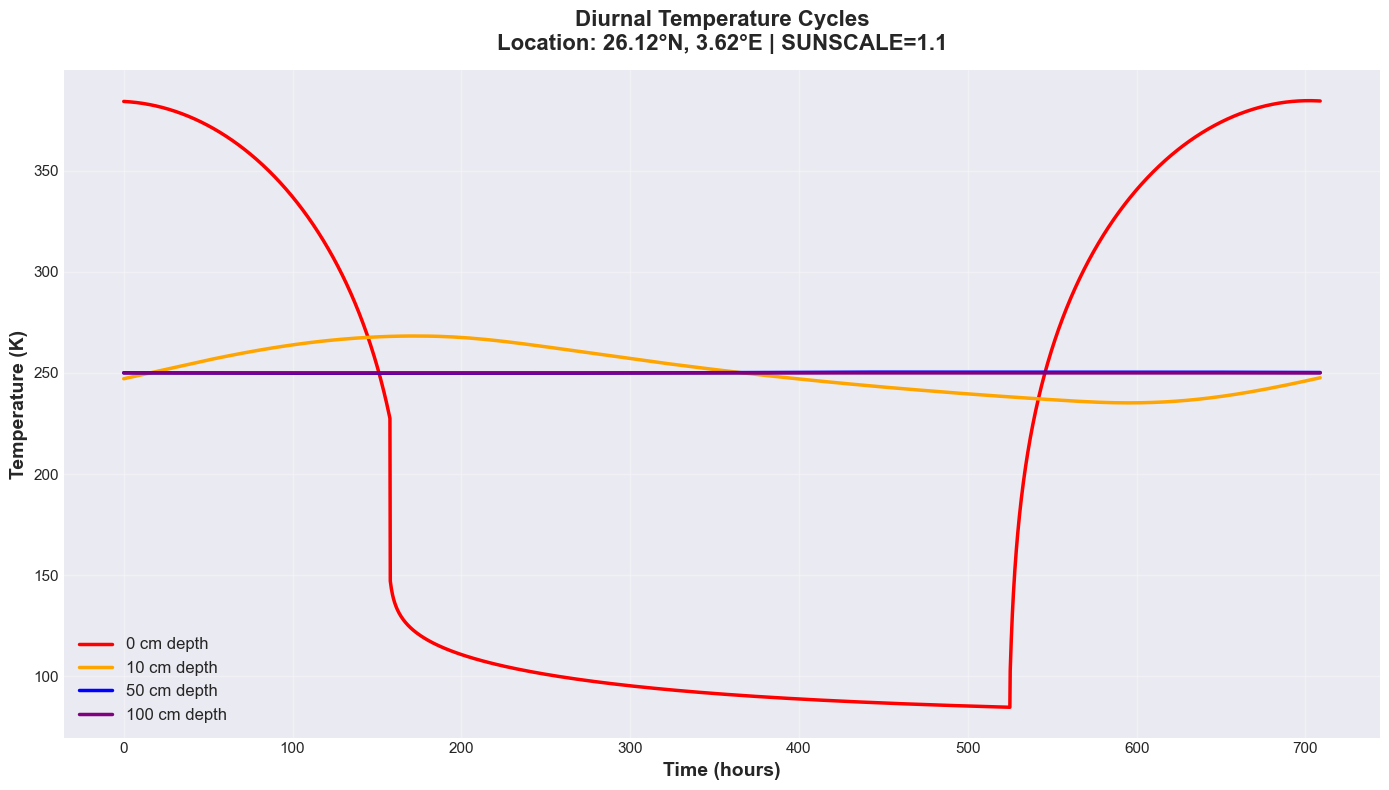

✓ Diurnal cycles plotted
  Depths: [0.0, 0.1, 0.5, 1.0]


In [94]:
# ============================================================================
# DIURNAL TEMPERATURE CYCLES
# ============================================================================
# Plot temperature vs time at different depths to see diurnal variations
# ============================================================================

# ────────────────────────────────────────────────────────────────────────────
# CUSTOMIZATION OPTIONS - EDIT THESE!
# ────────────────────────────────────────────────────────────────────────────

# Which depths to plot (in meters)
DEPTHS_TO_PLOT = [0.0, 0.1, 0.5, 1.0]  # Surface, 10cm, 50cm, 1m

# Colors for each depth
DEPTH_COLORS = ['red', 'orange', 'blue', 'purple']

# Figure size
FIG_WIDTH = 14  # inches
FIG_HEIGHT = 8  # inches

# ────────────────────────────────────────────────────────────────────────────
# EXTRACT DIURNAL CYCLES
# ────────────────────────────────────────────────────────────────────────────

# Get temperature vs time at specific depths
def get_diurnal_cycles(T_profile, t_arr, z_grid, depths):
    """Extract T vs time at specified depths"""
    # Get final lunar day
    t_start = t_arr[-1] - LUNAR_DAY
    idx = np.where(t_arr >= t_start)[0]
    
    t_hours = (t_arr[idx] - t_start) / 3600.0  # Convert to hours
    
    cycles = {}
    for d in depths:
        if d <= z_grid[-1]:
            # Find nearest depth index
            idx_z = np.argmin(np.abs(z_grid - d))
            actual_depth = z_grid[idx_z]
            cycles[d] = {
                'time_hours': t_hours,
                'temperature': T_profile[idx, idx_z],
                'actual_depth': actual_depth
            }
    
    return cycles

cycles = get_diurnal_cycles(T_profile, t_arr, z_grid, DEPTHS_TO_PLOT)

# ────────────────────────────────────────────────────────────────────────────
# CREATE PLOT
# ────────────────────────────────────────────────────────────────────────────

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))

# Plot each depth
for i, (depth, color) in enumerate(zip(DEPTHS_TO_PLOT, DEPTH_COLORS)):
    if depth in cycles:
        data = cycles[depth]
        ax.plot(data['time_hours'], data['temperature'], 
               color=color, linewidth=2.5, 
               label=f"{depth*100:.0f} cm depth")

# ────────────────────────────────────────────────────────────────────────────
# FORMATTING - CUSTOMIZE THESE!
# ────────────────────────────────────────────────────────────────────────────

# Axis labels
ax.set_xlabel('Time (hours)', fontsize=14, weight='bold')
ax.set_ylabel('Temperature (K)', fontsize=14, weight='bold')

# Title
ax.set_title(f'Diurnal Temperature Cycles\nLocation: {actual_lat:.2f}°N, {actual_lon:.2f}°E | SUNSCALE={SUNSCALE}',
            fontsize=16, weight='bold', pad=15)

# Grid
ax.grid(True, alpha=0.3, linewidth=1)

# Legend position - OPTIONS: 'upper right', 'upper left', 'lower right', 'lower left', 'best'
ax.legend(fontsize=12, loc='best', framealpha=0.9, edgecolor='black')

# Tick labels
ax.tick_params(labelsize=11)

# Tight layout (prevents label cutoff)
plt.tight_layout()
plt.show()

print("✓ Diurnal cycles plotted")
print(f"  Depths: {DEPTHS_TO_PLOT}")



---
## 13.3 Temperature Heatmap (Depth × Time)

**2D colormap showing temperature evolution with depth and time**

This visualization shows how temperature varies both with depth and time.


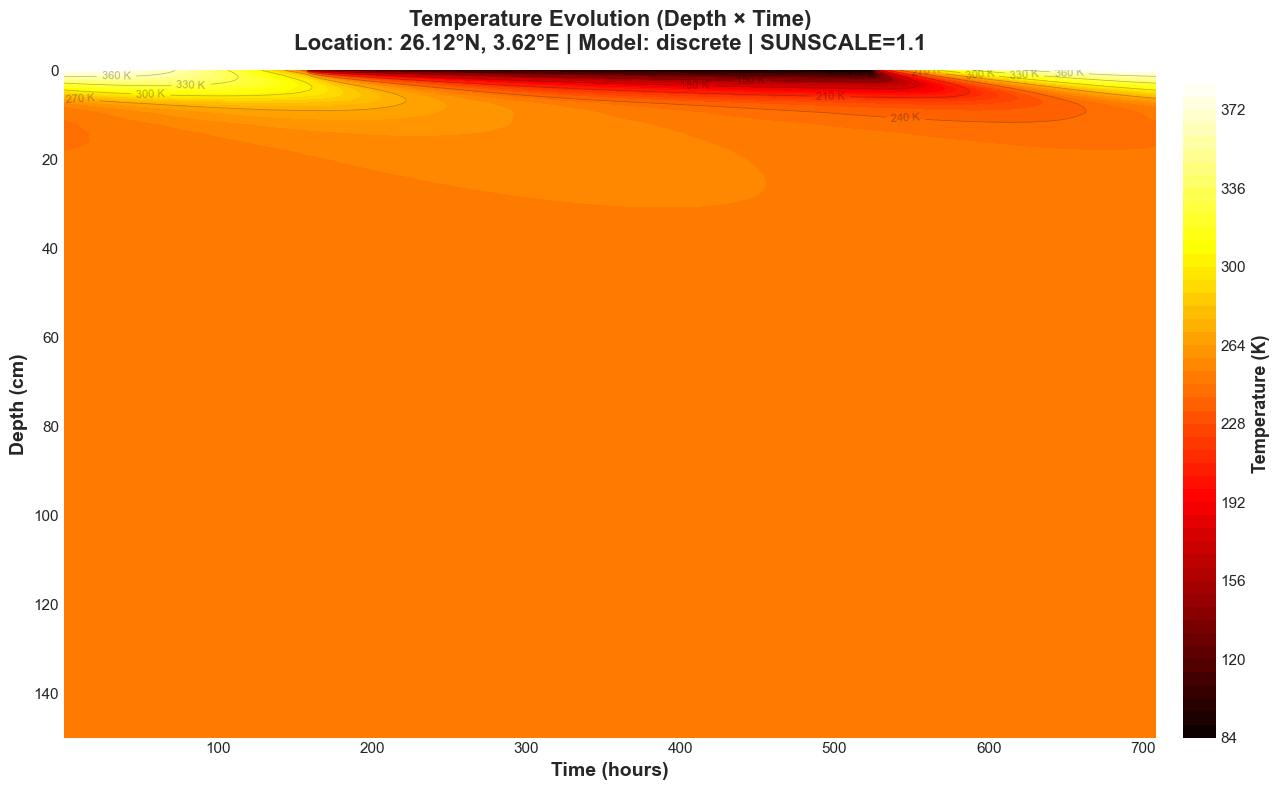

✓ Temperature heatmap created
  Depth range: 0 - 1.5 m
  Time range: 0.0 - 708.7 hours
  T range: 84.7 - 384.6 K


In [95]:
# ============================================================================
# TEMPERATURE HEATMAP (DEPTH × TIME)
# ============================================================================
# 2D colormap showing temperature at all depths over time
# ============================================================================

# ────────────────────────────────────────────────────────────────────────────
# CUSTOMIZATION OPTIONS - EDIT THESE!
# ────────────────────────────────────────────────────────────────────────────

# Figure size
HEATMAP_WIDTH = 14   # inches
HEATMAP_HEIGHT = 8   # inches

# Colormap - OPTIONS: 'hot', 'plasma', 'viridis', 'coolwarm', 'RdYlBu_r', 'jet'
COLORMAP = 'hot'

# Temperature limits (set to None for auto)
T_MIN = None  # Will use data min if None
T_MAX = None  # Will use data max if None

# Depth limit for plot (meters)
DEPTH_LIMIT = 1.5  # Only show top 1.5m (where most variation is)

# Time range (hours) - set to None to show all
TIME_START = None  # Start time in hours (None = show all)
TIME_END = None    # End time in hours (None = show all)

# Contour lines?
SHOW_CONTOURS = True
N_CONTOURS = 10

# ────────────────────────────────────────────────────────────────────────────
# PREPARE DATA
# ────────────────────────────────────────────────────────────────────────────

# Extract final lunar day
t_start = t_arr[-1] - LUNAR_DAY
idx_time = np.where(t_arr >= t_start)[0]

# Extract depths up to limit
idx_depth = np.where(z_grid <= DEPTH_LIMIT)[0]

# Time in hours
t_hours = (t_arr[idx_time] - t_start) / 3600.0

# Depths in cm
z_cm = z_grid[idx_depth] * 100

# Temperature subset
T_subset = T_profile[np.ix_(idx_time, idx_depth)]

# Apply time range if specified
if TIME_START is not None or TIME_END is not None:
    t_start_plot = TIME_START if TIME_START is not None else 0
    t_end_plot = TIME_END if TIME_END is not None else t_hours[-1]
    
    idx_time_range = np.where((t_hours >= t_start_plot) & (t_hours <= t_end_plot))[0]
    t_hours = t_hours[idx_time_range]
    T_subset = T_subset[idx_time_range, :]

# ────────────────────────────────────────────────────────────────────────────
# CREATE HEATMAP
# ────────────────────────────────────────────────────────────────────────────

fig, ax = plt.subplots(figsize=(HEATMAP_WIDTH, HEATMAP_HEIGHT))

# Determine temperature limits
vmin = T_MIN if T_MIN is not None else np.min(T_subset)
vmax = T_MAX if T_MAX is not None else np.max(T_subset)

# Create heatmap
im = ax.contourf(t_hours, z_cm, T_subset.T, 
                levels=50,  # Number of color levels
                cmap=COLORMAP, 
                vmin=vmin, vmax=vmax)

# Add contour lines if requested
if SHOW_CONTOURS:
    contours = ax.contour(t_hours, z_cm, T_subset.T,
                         levels=N_CONTOURS,
                         colors='black',
                         linewidths=0.5,
                         alpha=0.3)
    ax.clabel(contours, inline=True, fontsize=8, fmt='%.0f K')

# Colorbar
cbar = plt.colorbar(im, ax=ax, pad=0.02)
cbar.set_label('Temperature (K)', fontsize=13, weight='bold')
cbar.ax.tick_params(labelsize=11)

# ────────────────────────────────────────────────────────────────────────────
# FORMATTING - CUSTOMIZE THESE!
# ────────────────────────────────────────────────────────────────────────────

# Axis labels
ax.set_xlabel('Time (hours)', fontsize=14, weight='bold')
ax.set_ylabel('Depth (cm)', fontsize=14, weight='bold')

# Title
ax.set_title(f'Temperature Evolution (Depth × Time)\n' +
            f'Location: {actual_lat:.2f}°N, {actual_lon:.2f}°E | ' +
            f'Model: {DENSITY_MODEL} | SUNSCALE={SUNSCALE}',
            fontsize=16, weight='bold', pad=15)

# Invert y-axis (depth increases downward)
ax.invert_yaxis()

# Tick labels
ax.tick_params(labelsize=11)

# Grid
ax.grid(True, alpha=0.2, color='white', linewidth=0.5)

# Tight layout
plt.tight_layout()
plt.show()

print("✓ Temperature heatmap created")
print(f"  Depth range: 0 - {DEPTH_LIMIT} m")
print(f"  Time range: {t_hours[0]:.1f} - {t_hours[-1]:.1f} hours")
print(f"  T range: {vmin:.1f} - {vmax:.1f} K")



---
## 14. Apollo Site Comparison

**Compare model predictions with Apollo measurements**

This section compares your model output with actual Apollo Heat Flow Experiment data.


✓ At Apollo 15 site!


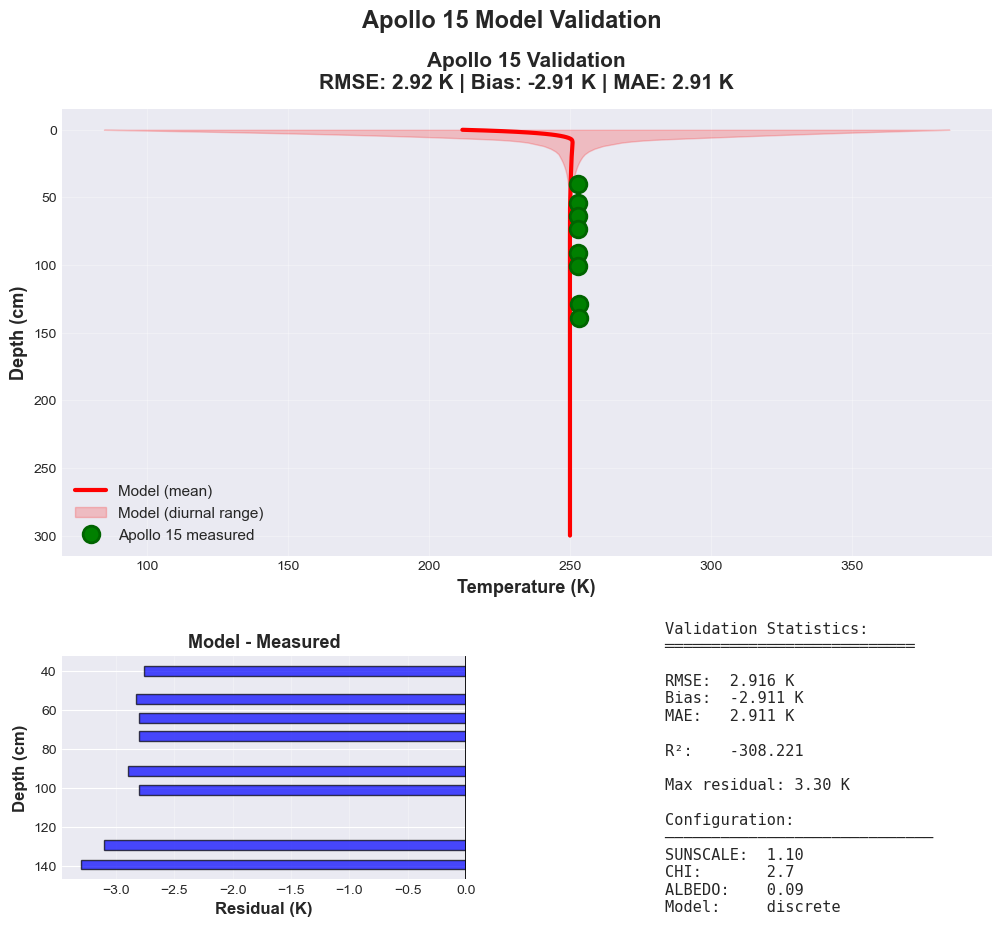


✓ Apollo comparison complete
  RMSE: 2.916 K
  Bias: -2.911 K
  MAE:  2.911 K


In [96]:
# ============================================================================
# APOLLO SITE COMPARISON
# ============================================================================
# Compare model predictions with Apollo 15 or 17 measured data
# ============================================================================

# ────────────────────────────────────────────────────────────────────────────
# CHECK IF AT APOLLO SITE
# ────────────────────────────────────────────────────────────────────────────

# Apollo site coordinates
APOLLO_SITES = {
    'Apollo 15': {'lat': 26.1341, 'lon': 3.6285},
    'Apollo 17': {'lat': 20.1921, 'lon': 30.7649}
}

# Check if current location matches an Apollo site (within 0.1 degrees)
at_apollo_site = None
for site_name, coords in APOLLO_SITES.items():
    if (abs(actual_lat - coords['lat']) < 0.1 and 
        abs(actual_lon - coords['lon']) < 0.1):
        at_apollo_site = site_name
        break

if at_apollo_site is None:
    print("⚠️  Not at an Apollo site - skipping comparison")
    print(f"   Current location: {actual_lat:.2f}°N, {actual_lon:.2f}°E")
    print(f"   To compare with Apollo data, use:")
    print(f"     Apollo 15: 26.13°N, 3.63°E")
    print(f"     Apollo 17: 20.19°N, 30.76°E")
else:
    print(f"✓ At {at_apollo_site} site!")
    
    # ────────────────────────────────────────────────────────────────────────
    # GET APOLLO DATA
    # ────────────────────────────────────────────────────────────────────────
    
    apollo_data = APOLLO_15_DATA if at_apollo_site == 'Apollo 15' else APOLLO_17_DATA
    apollo_depths = np.array([d for d, t in apollo_data])
    apollo_temps = np.array([t for d, t in apollo_data])
    
    # ────────────────────────────────────────────────────────────────────────
    # INTERPOLATE MODEL TO APOLLO DEPTHS
    # ────────────────────────────────────────────────────────────────────────
    
    # Use mean temperature from final day
    model_temps_at_apollo = np.interp(apollo_depths, z_grid, stats['T_mean'])
    
    # Calculate statistics
    residuals = model_temps_at_apollo - apollo_temps
    rmse = np.sqrt(np.mean(residuals**2))
    bias = np.mean(residuals)
    mae = np.mean(np.abs(residuals))
    
    # ────────────────────────────────────────────────────────────────────────
    # CUSTOMIZATION OPTIONS
    # ────────────────────────────────────────────────────────────────────────
    
    COMPARISON_FIG_WIDTH = 12
    COMPARISON_FIG_HEIGHT = 10
    
    # ────────────────────────────────────────────────────────────────────────
    # CREATE COMPARISON PLOT
    # ────────────────────────────────────────────────────────────────────────
    
    fig = plt.figure(figsize=(COMPARISON_FIG_WIDTH, COMPARISON_FIG_HEIGHT))
    gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1], hspace=0.3, wspace=0.3)
    
    # ════════════════════════════════════════════════════════════════════════
    # SUBPLOT 1: TEMPERATURE PROFILES
    # ════════════════════════════════════════════════════════════════════════
    
    ax1 = fig.add_subplot(gs[0, :])
    
    # Plot model predictions
    ax1.plot(stats['T_mean'], z_grid * 100, 
            'r-', linewidth=3, label='Model (mean)', zorder=2)
    
    # Show diurnal range
    ax1.fill_betweenx(z_grid * 100, stats['T_min'], stats['T_max'],
                     color='red', alpha=0.2, label='Model (diurnal range)', zorder=1)
    
    # Plot Apollo measurements
    ax1.plot(apollo_temps, apollo_depths * 100,
            'go', markersize=12, markeredgewidth=2, markeredgecolor='darkgreen',
            label=f'{at_apollo_site} measured', zorder=3)
    
    # Format
    ax1.set_xlabel('Temperature (K)', fontsize=13, weight='bold')
    ax1.set_ylabel('Depth (cm)', fontsize=13, weight='bold')
    ax1.set_title(f'{at_apollo_site} Validation\n' +
                 f'RMSE: {rmse:.2f} K | Bias: {bias:+.2f} K | MAE: {mae:.2f} K',
                 fontsize=15, weight='bold', pad=15)
    ax1.legend(fontsize=11, loc='best', framealpha=0.95)
    ax1.grid(True, alpha=0.3)
    ax1.invert_yaxis()
    
    # ════════════════════════════════════════════════════════════════════════
    # SUBPLOT 2: RESIDUALS
    # ════════════════════════════════════════════════════════════════════════
    
    ax2 = fig.add_subplot(gs[1, 0])
    
    ax2.barh(apollo_depths * 100, residuals, height=5,
            color=['red' if r > 0 else 'blue' for r in residuals],
            alpha=0.7, edgecolor='black')
    ax2.axvline(0, color='black', linewidth=2)
    
    ax2.set_xlabel('Residual (K)', fontsize=12, weight='bold')
    ax2.set_ylabel('Depth (cm)', fontsize=12, weight='bold')
    ax2.set_title('Model - Measured', fontsize=13, weight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    ax2.invert_yaxis()
    
    # ════════════════════════════════════════════════════════════════════════
    # SUBPLOT 3: STATISTICS
    # ════════════════════════════════════════════════════════════════════════
    
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.axis('off')
    
    # Statistics text
    stats_text = f"""
    Validation Statistics:
    ═══════════════════════════
    
    RMSE:  {rmse:.3f} K
    Bias:  {bias:+.3f} K
    MAE:   {mae:.3f} K
    
    R²:    {1 - np.sum(residuals**2)/np.sum((apollo_temps - np.mean(apollo_temps))**2):.3f}
    
    Max residual: {np.max(np.abs(residuals)):.2f} K
    
    Configuration:
    ─────────────────────────────
    SUNSCALE:  {SUNSCALE:.2f}
    CHI:       {CHI:.1f}
    ALBEDO:    {ALBEDO:.2f}
    Model:     {DENSITY_MODEL}
    """
    
    ax3.text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
            verticalalignment='center')
    
    plt.suptitle(f'{at_apollo_site} Model Validation', 
                fontsize=17, weight='bold', y=0.98)
    
    plt.show()
    
    print(f"\n✓ Apollo comparison complete")
    print(f"  RMSE: {rmse:.3f} K")
    print(f"  Bias: {bias:+.3f} K")
    print(f"  MAE:  {mae:.3f} K")


## 📊 Model Comparison (Your Model vs Hayne)

Compare discrete layer model with Hayne exponential model


---
## 14.5 Initialize Model Execution Variables

**Define all variables needed for thermal model runs**

This cell initializes everything the thermal solver needs.



---
# 15. Model Comparison: Discrete vs Hayne 2017

**Run both models and compare predictions at the main configured location**

This section runs both your discrete layer model and the Hayne 2017 exponential model
side-by-side and compares their predictions against Apollo HFE data (if at an Apollo site).

> **Note:** The **📍 Single Location Analysis** section at the bottom of this notebook
> produces the same comparison but lets you choose any lat/lon and H-parameter interactively.
> **Use the bottom section for exploratory work; use this section to reproduce the main
> run at your configured TARGET_LAT/TARGET_LON.**

Both sections produce the same 4-panel output:
- Panel 1: Mean temperature profiles (with diurnal range shading)
- Panel 2: Diurnal amplitude vs depth
- Panel 3: Model difference (discrete − hayne)
- Panel 4: Validation statistics vs Apollo HFE data


In [97]:
# ============================================================================
# MODEL COMPARISON: DISCRETE VS HAYNE 2017
# ============================================================================
# Run both models with same parameters and compare results
# ============================================================================

print("Running model comparison...")
print("="*70)

# ────────────────────────────────────────────────────────────────────────────
# ENSURE ALL VARIABLES ARE DEFINED
# ────────────────────────────────────────────────────────────────────────────

# Check if ndays is defined, if not use default
if 'ndays' not in dir():
    ndays = 5  # Default: 5 lunar days for spin-up
    print(f"⚠️  ndays not defined - using default: {ndays}")

# Check if MODEL_ID_MAP exists
if 'MODEL_ID_MAP' not in dir():
    MODEL_ID_MAP = {'discrete': 0, 'hayne_exponential': 1, 'custom': 2}
    print(f"⚠️  MODEL_ID_MAP not defined - creating default")

# ────────────────────────────────────────────────────────────────────────────
# CONFIGURATION FOR COMPARISON
# ────────────────────────────────────────────────────────────────────────────

# Models to compare
MODELS_TO_COMPARE = ['discrete', 'hayne_exponential']  # Add 'custom' if you want

# Shared parameters (both models use these)
COMPARISON_SUNSCALE = SUNSCALE
COMPARISON_CHI = CHI
COMPARISON_ALBEDO = ALBEDO

print(f"\nComparing models:")
for model in MODELS_TO_COMPARE:
    print(f"  - {model}")
print(f"\nShared parameters:")
print(f"  SUNSCALE: {COMPARISON_SUNSCALE}")
print(f"  CHI:      {COMPARISON_CHI}")
print(f"  ALBEDO:   {COMPARISON_ALBEDO}")
print(f"  ndays:    {ndays}")

# ────────────────────────────────────────────────────────────────────────────
# RUN BOTH MODELS
# ────────────────────────────────────────────────────────────────────────────

results_comparison = {}

for model_name in MODELS_TO_COMPARE:
    print(f"\n→ Running {model_name} model...")
    
    # Set model ID
    model_id = MODEL_ID_MAP[model_name]
    
    # Run thermal model (using your solve_thermal_model function)
    T_profile_model, t_arr_model = solve_thermal_model(
        z_grid, T_init, 
        actual_lat, actual_lon,
        slope, aspect,
        horizons, az_angles,
        COMPARISON_CHI, model_id, COMPARISON_SUNSCALE,
        ndays, dt_frac=0.01, albedo=COMPARISON_ALBEDO, emissivity=EMISSIVITY
    )
    
    # Extract statistics
    stats_model = extract_final_day_statistics(T_profile_model, t_arr_model, z_grid)
    
    # Store results
    results_comparison[model_name] = {
        'T_profile': T_profile_model,
        't_arr': t_arr_model,
        'stats': stats_model,
        'model_id': model_id
    }
    
    print(f"  ✓ Complete")
    print(f"    Surface T range: {stats_model['T_min'][0]:.1f} - {stats_model['T_max'][0]:.1f} K")

print(f"\n✓ All models completed")

Running model comparison...

Comparing models:
  - discrete
  - hayne_exponential

Shared parameters:
  SUNSCALE: 1.1
  CHI:      2.7
  ALBEDO:   0.09
  ndays:    5

→ Running discrete model...
  ✓ Complete
    Surface T range: 84.8 - 384.2 K

→ Running hayne_exponential model...
  ✓ Complete
    Surface T range: 90.0 - 384.1 K

✓ All models completed



---
## 15.1 Comparison Plot: Discrete vs Hayne

**Side-by-side comparison of model predictions**


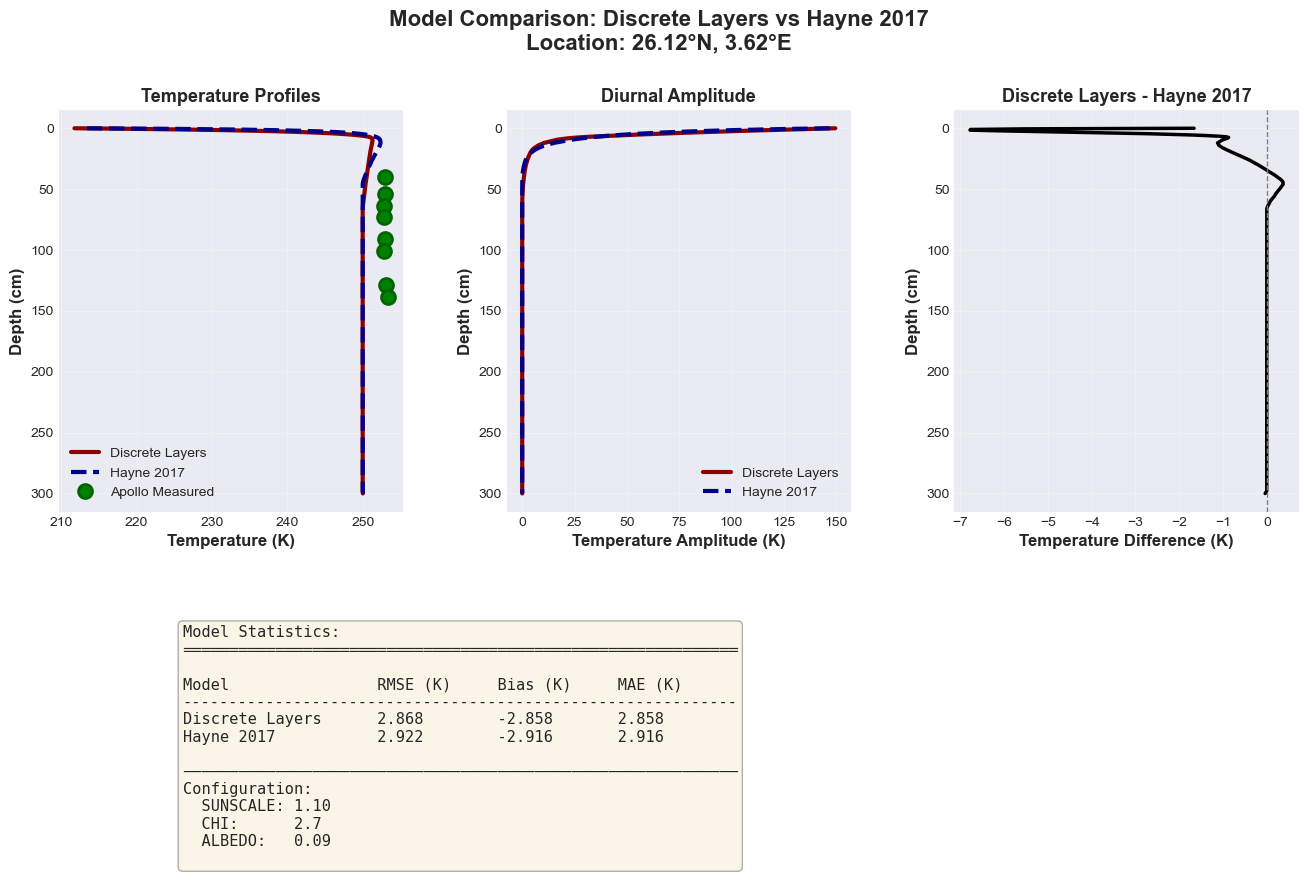


✓ Model comparison visualization complete


In [98]:
# ============================================================================
# MODEL COMPARISON VISUALIZATION
# ============================================================================
# Create comprehensive comparison plot
# ============================================================================

# ────────────────────────────────────────────────────────────────────────────
# CUSTOMIZATION OPTIONS
# ────────────────────────────────────────────────────────────────────────────

COMPARISON_FIG_WIDTH = 16
COMPARISON_FIG_HEIGHT = 10

# Model colors and styles
MODEL_COLORS = {
    'discrete': 'darkred',
    'hayne_exponential': 'darkblue',
    'custom': 'darkgreen'
}

MODEL_LINE_STYLES = {
    'discrete': '-',
    'hayne_exponential': '--',
    'custom': '-.'
}

MODEL_LABELS = {
    'discrete': 'Discrete Layers',
    'hayne_exponential': 'Hayne 2017',
    'custom': 'Custom'
}

# ────────────────────────────────────────────────────────────────────────────
# CREATE COMPARISON FIGURE
# ────────────────────────────────────────────────────────────────────────────

fig = plt.figure(figsize=(COMPARISON_FIG_WIDTH, COMPARISON_FIG_HEIGHT))
gs = gridspec.GridSpec(2, 3, height_ratios=[1.5, 1], hspace=0.3, wspace=0.3)

# ════════════════════════════════════════════════════════════════════════════
# PANEL 1: TEMPERATURE PROFILES
# ════════════════════════════════════════════════════════════════════════════

ax1 = fig.add_subplot(gs[0, 0])

for model_name in MODELS_TO_COMPARE:
    stats_m = results_comparison[model_name]['stats']
    color = MODEL_COLORS.get(model_name, 'black')
    linestyle = MODEL_LINE_STYLES.get(model_name, '-')
    label = MODEL_LABELS.get(model_name, model_name)
    
    ax1.plot(stats_m['T_mean'], z_grid * 100,
            color=color, linestyle=linestyle, linewidth=3,
            label=label)

# Add Apollo data if at Apollo site
if 'apollo_depths' in dir() and apollo_depths is not None:
    ax1.plot(apollo_temps, apollo_depths * 100,
            'o', color='green', markersize=10,
            markeredgewidth=2, markeredgecolor='darkgreen',
            label='Apollo Measured')

ax1.set_xlabel('Temperature (K)', fontsize=12, weight='bold')
ax1.set_ylabel('Depth (cm)', fontsize=12, weight='bold')
ax1.set_title('Temperature Profiles', fontsize=13, weight='bold')
ax1.legend(fontsize=10, loc='best')
ax1.grid(True, alpha=0.3)
ax1.invert_yaxis()

# ════════════════════════════════════════════════════════════════════════════
# PANEL 2: TEMPERATURE AMPLITUDE VS DEPTH
# ════════════════════════════════════════════════════════════════════════════

ax2 = fig.add_subplot(gs[0, 1])

for model_name in MODELS_TO_COMPARE:
    stats_m = results_comparison[model_name]['stats']
    color = MODEL_COLORS.get(model_name, 'black')
    linestyle = MODEL_LINE_STYLES.get(model_name, '-')
    label = MODEL_LABELS.get(model_name, model_name)
    
    amplitude = (stats_m['T_max'] - stats_m['T_min']) / 2.0
    ax2.plot(amplitude, z_grid * 100,
            color=color, linestyle=linestyle, linewidth=3,
            label=label)

ax2.set_xlabel('Temperature Amplitude (K)', fontsize=12, weight='bold')
ax2.set_ylabel('Depth (cm)', fontsize=12, weight='bold')
ax2.set_title('Diurnal Amplitude', fontsize=13, weight='bold')
ax2.legend(fontsize=10, loc='best')
ax2.grid(True, alpha=0.3)
ax2.invert_yaxis()

# ════════════════════════════════════════════════════════════════════════════
# PANEL 3: MODEL DIFFERENCE
# ════════════════════════════════════════════════════════════════════════════

ax3 = fig.add_subplot(gs[0, 2])

if len(MODELS_TO_COMPARE) >= 2:
    model1 = MODELS_TO_COMPARE[0]
    model2 = MODELS_TO_COMPARE[1]
    
    T_diff = (results_comparison[model1]['stats']['T_mean'] - 
              results_comparison[model2]['stats']['T_mean'])
    
    ax3.plot(T_diff, z_grid * 100, 'k-', linewidth=2.5)
    ax3.axvline(0, color='gray', linestyle='--', linewidth=1)
    
    ax3.set_xlabel('Temperature Difference (K)', fontsize=12, weight='bold')
    ax3.set_ylabel('Depth (cm)', fontsize=12, weight='bold')
    ax3.set_title(f'{MODEL_LABELS[model1]} - {MODEL_LABELS[model2]}', 
                 fontsize=13, weight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.invert_yaxis()

# ════════════════════════════════════════════════════════════════════════════
# PANEL 4: STATISTICS TABLE
# ════════════════════════════════════════════════════════════════════════════

ax4 = fig.add_subplot(gs[1, :])
ax4.axis('off')

# Calculate RMSE vs Apollo if available
stats_text = "Model Statistics:\n"
stats_text += "═" * 60 + "\n\n"

if 'apollo_temps' in dir() and apollo_temps is not None:
    stats_text += f"{'Model':<20} {'RMSE (K)':<12} {'Bias (K)':<12} {'MAE (K)':<12}\n"
    stats_text += "-" * 60 + "\n"
    
    for model_name in MODELS_TO_COMPARE:
        stats_m = results_comparison[model_name]['stats']
        model_at_apollo = np.interp(apollo_depths, z_grid, stats_m['T_mean'])
        
        rmse = np.sqrt(np.mean((model_at_apollo - apollo_temps)**2))
        bias = np.mean(model_at_apollo - apollo_temps)
        mae = np.mean(np.abs(model_at_apollo - apollo_temps))
        
        label = MODEL_LABELS.get(model_name, model_name)
        stats_text += f"{label:<20} {rmse:<12.3f} {bias:<+12.3f} {mae:<12.3f}\n"
else:
    stats_text += "No Apollo data available for comparison\n"

stats_text += "\n" + "─" * 60 + "\n"
stats_text += f"Configuration:\n"
stats_text += f"  SUNSCALE: {COMPARISON_SUNSCALE:.2f}\n"
stats_text += f"  CHI:      {COMPARISON_CHI:.1f}\n"
stats_text += f"  ALBEDO:   {COMPARISON_ALBEDO:.2f}\n"

ax4.text(0.1, 0.5, stats_text, 
        fontsize=11, family='monospace',
        verticalalignment='center',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle(f'Model Comparison: {" vs ".join([MODEL_LABELS[m] for m in MODELS_TO_COMPARE])}\n' +
            f'Location: {actual_lat:.2f}°N, {actual_lon:.2f}°E',
            fontsize=16, weight='bold', y=0.98)

plt.show()

print("\n✓ Model comparison visualization complete")



---
# 16. Parameter Sensitivity Analysis

**Explore how changing individual parameters affects model predictions**

This section sweeps one parameter (SUNSCALE, CHI, ALBEDO, EMISSIVITY) across a range
of values at the main configured location and shows how temperature output changes.
If at an Apollo site, it also shows RMSE vs HFE data to identify the best-fit value.

> **Note:** The **🔍 Single Location Sensitivity Analysis** section at the bottom
> of this notebook does the same sweep but also supports the **H-parameter** (Hayne
> scale height) and lets you choose any location interactively.
> **Use the bottom section for exploratory work; use this section for a quick sweep
> at your main configured location.**


In [99]:
# ============================================================================
# PARAMETER SENSITIVITY ANALYSIS
# ============================================================================
# Vary one parameter at a time to see its effect on temperatures
# ============================================================================

print("Parameter Sensitivity Analysis")
print("="*70)

# ────────────────────────────────────────────────────────────────────────────
# CHOOSE PARAMETER TO VARY
# ────────────────────────────────────────────────────────────────────────────

# Select which parameter to analyze
SENSITIVITY_PARAMETER = 'ALBEDO'  # ← CHANGE THIS!
# OPTIONS: 'SUNSCALE', 'CHI', 'ALBEDO', 'EMISSIVITY'

# Define parameter ranges to test
PARAMETER_RANGES = {
    'SUNSCALE': np.linspace(1.0, 1.2, 8),      # Test 1.0 to 2.5
    'CHI': np.linspace(1.5, 4.0, 8),           # Test 1.5 to 4.0
    'ALBEDO': np.linspace(0.09, 0.12, 8),      # Test 0.05 to 0.20
    'EMISSIVITY': np.linspace(0.90, 0.98, 8)   # Test 0.90 to 0.98
}

# Get the range for selected parameter
param_values = PARAMETER_RANGES[SENSITIVITY_PARAMETER]

print(f"\nAnalyzing sensitivity to: {SENSITIVITY_PARAMETER}")
print(f"Testing {len(param_values)} values from {param_values[0]:.2f} to {param_values[-1]:.2f}")

# ────────────────────────────────────────────────────────────────────────────
# RUN MODELS WITH DIFFERENT PARAMETER VALUES
# ────────────────────────────────────────────────────────────────────────────

sensitivity_results = {}

for i, param_value in enumerate(param_values):
    print(f"\n[{i+1}/{len(param_values)}] Testing {SENSITIVITY_PARAMETER} = {param_value:.3f}...")
    
    # Set parameters (keep others at baseline)
    test_sunscale = param_value if SENSITIVITY_PARAMETER == 'SUNSCALE' else SUNSCALE
    test_chi = param_value if SENSITIVITY_PARAMETER == 'CHI' else CHI
    test_albedo = param_value if SENSITIVITY_PARAMETER == 'ALBEDO' else ALBEDO
    test_emissivity = param_value if SENSITIVITY_PARAMETER == 'EMISSIVITY' else EMISSIVITY
    
    # Run model (FIXED: now includes albedo and emissivity parameters)
    T_profile_test, t_arr_test = solve_thermal_model(
        z_grid, T_init,
        actual_lat, actual_lon,
        slope, aspect,
        horizons, az_angles,
        test_chi, MODEL_ID, test_sunscale,
        ndays, dt_frac=0.01,
        albedo=test_albedo,           # ← WAS MISSING
        emissivity=test_emissivity    # ← WAS MISSING
    )
    
    # Extract statistics
    stats_test = extract_final_day_statistics(T_profile_test, t_arr_test, z_grid)
    
    # Store results
    sensitivity_results[param_value] = {
        'stats': stats_test,
        'T_profile': T_profile_test,
        't_arr': t_arr_test
    }
    
    print(f"  ✓ Surface T: {stats_test['T_min'][0]:.1f} - {stats_test['T_max'][0]:.1f} K")

print(f"\n✓ Sensitivity analysis complete!")


Parameter Sensitivity Analysis

Analyzing sensitivity to: ALBEDO
Testing 8 values from 0.09 to 0.12

[1/8] Testing ALBEDO = 0.090...
  ✓ Surface T: 84.8 - 384.2 K

[2/8] Testing ALBEDO = 0.094...
  ✓ Surface T: 84.8 - 383.8 K

[3/8] Testing ALBEDO = 0.099...
  ✓ Surface T: 84.8 - 383.3 K

[4/8] Testing ALBEDO = 0.103...
  ✓ Surface T: 84.7 - 382.8 K

[5/8] Testing ALBEDO = 0.107...
  ✓ Surface T: 84.7 - 382.4 K

[6/8] Testing ALBEDO = 0.111...
  ✓ Surface T: 84.7 - 381.9 K

[7/8] Testing ALBEDO = 0.116...
  ✓ Surface T: 84.7 - 381.5 K

[8/8] Testing ALBEDO = 0.120...
  ✓ Surface T: 84.7 - 381.0 K

✓ Sensitivity analysis complete!



---
## 16.1 Sensitivity Plots

**Visualize parameter effects**


C:\Users\Admin\AppData\Local\Temp\ipykernel_23132\2313542463.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(COLORMAP_SENSITIVITY)
C:\Users\Admin\AppData\Local\Temp\ipykernel_23132\2313542463.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


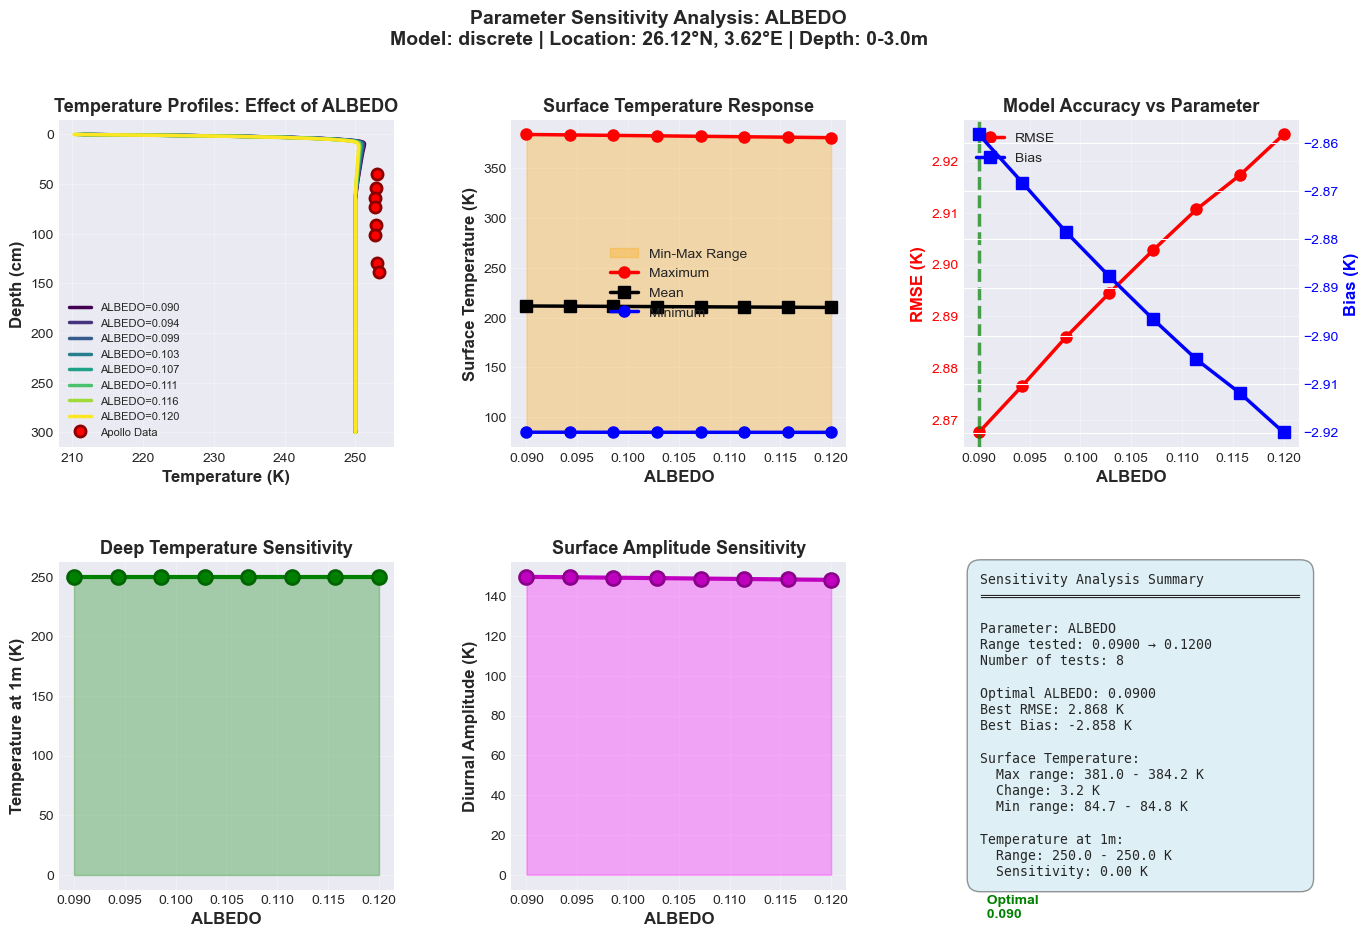


✓ SENSITIVITY VISUALIZATION COMPLETE

📊 Parameter tested: ALBEDO
   Range: 0.0900 to 0.1200
   Values: 8 test points

🎯 Optimal value found: 0.0900
   RMSE: 2.8677 K
   Bias: -2.8583 K

📈 Parameter effects:
   Surface T change: 3.21 K
   Deep (1m) T change: 0.00 K
   Amplitude change: 1.54 K

🔄 To test a different parameter:
   1. Change SENSITIVITY_PARAMETER = 'SUNSCALE'  (in previous cell)
      OPTIONS: 'SUNSCALE', 'CHI', 'ALBEDO', 'EMISSIVITY'
   2. Re-run cell 50 (sensitivity computation)
   3. Re-run this cell (visualization)



In [100]:
# ============================================================================
# PARAMETER SENSITIVITY VISUALIZATION
# ============================================================================

# ────────────────────────────────────────────────────────────────────────────
# CUSTOMIZATION
# ────────────────────────────────────────────────────────────────────────────

SENSITIVITY_FIG_WIDTH = 16
SENSITIVITY_FIG_HEIGHT = 10

# Colormap for different parameter values
COLORMAP_SENSITIVITY = 'viridis'  # 'viridis', 'plasma', 'coolwarm', 'RdYlBu'

# ────────────────────────────────────────────────────────────────────────────
# CREATE FIGURE - FRESH START FOR EACH RUN
# ────────────────────────────────────────────────────────────────────────────

plt.close('all')  # Close any previous figures to avoid overlap
fig = plt.figure(figsize=(SENSITIVITY_FIG_WIDTH, SENSITIVITY_FIG_HEIGHT))
gs = gridspec.GridSpec(2, 3, hspace=0.35, wspace=0.35)

param_values_list = sorted(sensitivity_results.keys())
# Use proper colormap method (avoid deprecation warning)
cmap = plt.cm.get_cmap(COLORMAP_SENSITIVITY)
colors = cmap(np.linspace(0, 1, len(param_values_list)))

# ════════════════════════════════════════════════════════════════════════════
# PANEL 1: TEMPERATURE PROFILES
# ════════════════════════════════════════════════════════════════════════════

ax1 = fig.add_subplot(gs[0, 0])

for param_val, color in zip(param_values_list, colors):
    stats_s = sensitivity_results[param_val]['stats']
    ax1.plot(stats_s['T_mean'], z_grid * 100,
            color=color, linewidth=2.5,
            label=f'{SENSITIVITY_PARAMETER}={param_val:.3f}')

# Add Apollo data if available
if 'apollo_temps' in dir() and apollo_temps is not None:
    ax1.plot(apollo_temps, apollo_depths * 100,
            'o', color='red', markersize=8,
            markeredgewidth=2, markeredgecolor='darkred',
            label='Apollo Data', zorder=100)

ax1.set_xlabel('Temperature (K)', fontsize=12, weight='bold')
ax1.set_ylabel('Depth (cm)', fontsize=12, weight='bold')
ax1.set_title(f'Temperature Profiles: Effect of {SENSITIVITY_PARAMETER}', fontsize=13, weight='bold')
ax1.legend(fontsize=8, ncol=1, loc='best')
ax1.grid(True, alpha=0.3)
ax1.invert_yaxis()

# ════════════════════════════════════════════════════════════════════════════
# PANEL 2: SURFACE TEMPERATURE RANGE
# ════════════════════════════════════════════════════════════════════════════

ax2 = fig.add_subplot(gs[0, 1])

T_min_surf = [sensitivity_results[pv]['stats']['T_min'][0] for pv in param_values_list]
T_max_surf = [sensitivity_results[pv]['stats']['T_max'][0] for pv in param_values_list]
T_mean_surf = [sensitivity_results[pv]['stats']['T_mean'][0] for pv in param_values_list]

ax2.fill_between(param_values_list, T_min_surf, T_max_surf, alpha=0.3, color='orange', label='Min-Max Range')
ax2.plot(param_values_list, T_max_surf, 'r-o', linewidth=2.5, markersize=8, label='Maximum')
ax2.plot(param_values_list, T_mean_surf, 'k-s', linewidth=2.5, markersize=8, label='Mean')
ax2.plot(param_values_list, T_min_surf, 'b-o', linewidth=2.5, markersize=8, label='Minimum')

ax2.set_xlabel(f'{SENSITIVITY_PARAMETER}', fontsize=12, weight='bold')
ax2.set_ylabel('Surface Temperature (K)', fontsize=12, weight='bold')
ax2.set_title('Surface Temperature Response', fontsize=13, weight='bold')
ax2.legend(fontsize=10, loc='best')
ax2.grid(True, alpha=0.3)

# ════════════════════════════════════════════════════════════════════════════
# PANEL 3: RMSE vs PARAMETER (if Apollo data available)
# ════════════════════════════════════════════════════════════════════════════

ax3 = fig.add_subplot(gs[0, 2])

if 'apollo_temps' in dir() and apollo_temps is not None:
    rmse_values = []
    bias_values = []
    
    for param_val in param_values_list:
        stats_s = sensitivity_results[param_val]['stats']
        model_at_apollo = np.interp(apollo_depths, z_grid, stats_s['T_mean'])
        
        rmse = np.sqrt(np.mean((model_at_apollo - apollo_temps)**2))
        bias = np.mean(model_at_apollo - apollo_temps)
        
        rmse_values.append(rmse)
        bias_values.append(bias)
    
    ax3_twin = ax3.twinx()
    
    line1 = ax3.plot(param_values_list, rmse_values, 'ro-', linewidth=2.5, markersize=8, label='RMSE')
    line2 = ax3_twin.plot(param_values_list, bias_values, 'bs-', linewidth=2.5, markersize=8, label='Bias')
    
    # Find optimal (minimum RMSE)
    min_idx = np.argmin(rmse_values)
    optimal_value = param_values_list[min_idx]
    ax3.axvline(optimal_value, color='green', linestyle='--', linewidth=2.5, alpha=0.7, label='Optimal')
    ax3.text(optimal_value, max(rmse_values)*0.95, f'  Optimal\n  {optimal_value:.3f}',
            fontsize=10, weight='bold', color='green', verticalalignment='top')
    
    ax3.set_xlabel(f'{SENSITIVITY_PARAMETER}', fontsize=12, weight='bold')
    ax3.set_ylabel('RMSE (K)', fontsize=12, weight='bold', color='red')
    ax3_twin.set_ylabel('Bias (K)', fontsize=12, weight='bold', color='blue')
    ax3.set_title('Model Accuracy vs Parameter', fontsize=13, weight='bold')
    
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax3.legend(lines, labels, fontsize=10, loc='upper left')
    
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='y', labelcolor='red')
    ax3_twin.tick_params(axis='y', labelcolor='blue')
else:
    ax3.text(0.5, 0.5, 'No Apollo data\nfor validation',
            ha='center', va='center', fontsize=14, weight='bold',
            transform=ax3.transAxes, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
    ax3.axis('off')

# ════════════════════════════════════════════════════════════════════════════
# PANEL 4: TEMPERATURE AT 1M DEPTH
# ════════════════════════════════════════════════════════════════════════════

ax4 = fig.add_subplot(gs[1, 0])

T_at_1m = [np.interp(1.0, z_grid, sensitivity_results[pv]['stats']['T_mean']) 
          for pv in param_values_list]

ax4.plot(param_values_list, T_at_1m, 'go-', linewidth=3, markersize=10, markeredgewidth=2, markeredgecolor='darkgreen')
ax4.fill_between(param_values_list, T_at_1m, alpha=0.3, color='green')

ax4.set_xlabel(f'{SENSITIVITY_PARAMETER}', fontsize=12, weight='bold')
ax4.set_ylabel('Temperature at 1m (K)', fontsize=12, weight='bold')
ax4.set_title('Deep Temperature Sensitivity', fontsize=13, weight='bold')
ax4.grid(True, alpha=0.3)

# ════════════════════════════════════════════════════════════════════════════
# PANEL 5: AMPLITUDE AT SURFACE vs PARAMETER
# ════════════════════════════════════════════════════════════════════════════

ax5 = fig.add_subplot(gs[1, 1])

amplitude_surf = [(sensitivity_results[pv]['stats']['T_max'][0] - 
                  sensitivity_results[pv]['stats']['T_min'][0]) / 2.0
                 for pv in param_values_list]

ax5.plot(param_values_list, amplitude_surf, 'mo-', linewidth=3, markersize=10, markeredgewidth=2, markeredgecolor='darkmagenta')
ax5.fill_between(param_values_list, amplitude_surf, alpha=0.3, color='magenta')

ax5.set_xlabel(f'{SENSITIVITY_PARAMETER}', fontsize=12, weight='bold')
ax5.set_ylabel('Diurnal Amplitude (K)', fontsize=12, weight='bold')
ax5.set_title('Surface Amplitude Sensitivity', fontsize=13, weight='bold')
ax5.grid(True, alpha=0.3)

# ════════════════════════════════════════════════════════════════════════════
# PANEL 6: SUMMARY TABLE
# ════════════════════════════════════════════════════════════════════════════

ax6 = fig.add_subplot(gs[1, 2])
ax6.axis('off')

summary_text = f"Sensitivity Analysis Summary\n"
summary_text += "═" * 40 + "\n\n"
summary_text += f"Parameter: {SENSITIVITY_PARAMETER}\n"
summary_text += f"Range tested: {param_values_list[0]:.4f} → {param_values_list[-1]:.4f}\n"
summary_text += f"Number of tests: {len(param_values_list)}\n\n"

if 'apollo_temps' in dir() and apollo_temps is not None:
    summary_text += f"Optimal {SENSITIVITY_PARAMETER}: {optimal_value:.4f}\n"
    summary_text += f"Best RMSE: {min(rmse_values):.3f} K\n"
    summary_text += f"Best Bias: {bias_values[min_idx]:+.3f} K\n\n"
else:
    summary_text += "No Apollo data\n\n"

summary_text += "Surface Temperature:\n"
summary_text += f"  Max range: {min(T_max_surf):.1f} - {max(T_max_surf):.1f} K\n"
summary_text += f"  Change: {max(T_max_surf)-min(T_max_surf):.1f} K\n"
summary_text += f"  Min range: {min(T_min_surf):.1f} - {max(T_min_surf):.1f} K\n\n"

summary_text += f"Temperature at 1m:\n"
summary_text += f"  Range: {min(T_at_1m):.1f} - {max(T_at_1m):.1f} K\n"
summary_text += f"  Sensitivity: {(max(T_at_1m)-min(T_at_1m)):.2f} K"

ax6.text(0.05, 0.5, summary_text,
        fontsize=9.5, family='monospace',
        verticalalignment='center',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.4, pad=1))

# ════════════════════════════════════════════════════════════════════════════
# TITLE AND DISPLAY
# ════════════════════════════════════════════════════════════════════════════

plt.suptitle(f'Parameter Sensitivity Analysis: {SENSITIVITY_PARAMETER}\n' +
            f'Model: {DENSITY_MODEL} | Location: {actual_lat:.2f}°N, {actual_lon:.2f}°E | Depth: 0-{DEPTH_MAX:.1f}m',
            fontsize=14, weight='bold', y=0.99)

# Ensure tight layout and display
plt.tight_layout(rect=[0, 0, 1, 0.97])

# Display the figure as image output (will show in notebook)
from IPython.display import display, HTML
display(fig)

# ════════════════════════════════════════════════════════════════════════════
# CONSOLE OUTPUT
# ════════════════════════════════════════════════════════════════════════════

print(f"\n{'='*70}")
print(f"✓ SENSITIVITY VISUALIZATION COMPLETE")
print(f"{'='*70}")
print(f"\n📊 Parameter tested: {SENSITIVITY_PARAMETER}")
print(f"   Range: {param_values_list[0]:.4f} to {param_values_list[-1]:.4f}")
print(f"   Values: {len(param_values_list)} test points")

if 'apollo_temps' in dir() and apollo_temps is not None:
    print(f"\n🎯 Optimal value found: {optimal_value:.4f}")
    print(f"   RMSE: {min(rmse_values):.4f} K")
    print(f"   Bias: {bias_values[min_idx]:+.4f} K")

print(f"\n📈 Parameter effects:")
print(f"   Surface T change: {max(T_max_surf)-min(T_max_surf):.2f} K")
print(f"   Deep (1m) T change: {max(T_at_1m)-min(T_at_1m):.2f} K")
print(f"   Amplitude change: {max(amplitude_surf)-min(amplitude_surf):.2f} K")

print(f"\n🔄 To test a different parameter:")
print(f"   1. Change SENSITIVITY_PARAMETER = 'SUNSCALE'  (in previous cell)")
print(f"      OPTIONS: 'SUNSCALE', 'CHI', 'ALBEDO', 'EMISSIVITY'")
print(f"   2. Re-run cell 50 (sensitivity computation)")
print(f"   3. Re-run this cell (visualization)")
print(f"{'='*70}\n")


# 📋 Advanced Features Guide: H-Parameter Sensitivity & Batch Processing

## Overview
This notebook includes advanced batch processing capabilities for:
1. **Batch model comparison** - Compare two thermal models across many locations
2. **H-value sensitivity analysis** - Find optimal Hayne H-parameter for each location
3. **Consistency verification** - Check batch results for data quality issues

---

## Part A: H-Parameter Sensitivity Analysis for Hayne Model

The Hayne exponential density model includes an **e-folding depth parameter H** that controls how quickly density increases with depth:

$$\rho(z) = \rho_d - (\rho_d - \rho_s) \cdot e^{-z/H}$$

Where:
- $\rho_s$ = 1100 kg/m³ (surface density)
- $\rho_d$ = 1800 kg/m³ (deep density)
- **H** = scale height (typically 0.04–0.10 m)

### Layer Structure with Dynamic H

When using H-value sensitivity, the model uses a **3-layer structure** with H-dependent boundaries:

| Layer | Depth Range | Density Behavior |
|-------|-------------|-----------------|
| **Layer 1** | 0 to H(m) | ρ = 1100 kg/m³ (fluffy dust) |
| **Layer 2** | H to 20 cm | Linear transition 1100→1700 kg/m³ |
| **Layer 3** | >20 cm | Gradual compaction 1700→1800 kg/m³ |

**Important**: H-values in your Excel file should be in **kilometers (km)**. The functions automatically convert to meters internally.

### How to Use H-Sensitivity Analysis

#### Step 1: Prepare your input Excel file

Your file should contain columns:
- `lat` or `latitude` - Location latitude (degrees)
- `lon` or `longitude` - Location longitude (degrees)  
- `localtime(hr)` or `llst` - Local solar time (0-24 hours)
- `H` or `h_km` - (Optional) H-value in kilometers for this location

Example:
```
lat,lon,localtime(hr),H_km
26.13,3.63,12.0,0.065
26.50,5.00,14.5,0.055
```

If you don't include an H column, the function will test a preset range: [0.04, 0.05, 0.06, 0.07, 0.08, 0.10] km

#### Step 2: Call the H-sensitivity batch processor

```python
# Import the function (it's already defined in cell 57)
zip_npz, zip_img, summary_csv = process_batch_hayne_h_sensitivity(
    input_path=r"C:\path\to\your\data.csv",
    output_dir=r"C:\path\to\output",
    h_values_km=[0.05, 0.06, 0.07, 0.08],  # H-values to test (km)
    model_baseline_key="discrete",
    model_baseline_label="Discrete Baseline",
)
```

#### Step 3: Interpret the results

The function generates:
1. **h_sensitivity_summary.csv** - Table of optimal H for each location
2. **NPZ files** - Raw data with all tested H-values and statistics
3. **PNG images** - Comparison plots:
   - `_h_compare_best.png` - Temperature profiles: Baseline vs optimal H
   - `_h_sensitivity_curve.png` - RMSE vs H for each location

#### Example Output

For each location, you'll get:
```
optimal_h_km  = 0.065 km (6.5 cm)
optimal_h_m   = 0.065 m
optimal_h_cm  = 6.5 cm
rmse_vs_baseline_K = 2.15 K
num_h_tested  = 6
```

---

## Part B: Batch Model Comparison

Process and compare two thermal models at many locations efficiently.

### Usage

```python
zip_npz, zip_img, summary_csv = process_batch_compare_models(
    input_path=r"C:\path\to\locations.csv",
    output_dir=r"C:\path\to\output",
    model_A_key="hayne_exponential",
    model_B_key="discrete",
    model_A_label="Hayne (2017)",
    model_B_label="Discrete (Apollo)",
)
```

### Output Files

- **coordinate_snap_summary.csv** - Mapping of input→actual coordinates
- **batch_results_npz.zip** - All model data (temperatures, metrics)
- **batch_results_images.zip** - PNG comparisons for each location

---

## Part C: Detecting & Fixing Inconsistencies

Use `verify_batch_consistency()` to check for data quality issues:

```python
issues = verify_batch_consistency(
    npz_zip_path=r"C:\path\to\batch_results_npz.zip",
    output_file=r"C:\path\to\consistency_report.txt"
)

if issues:
    print(f"Found {len(issues)} potential problems")
    for issue in issues:
        print(f"  ⚠ {issue}")
else:
    print("✓ No major issues detected")
```

### What It Checks

1. **NaN/Inf values** - Indicates computation failures
2. **Temperature jumps** - Large unexplained T changes between nearby locations
3. **Coordinate snapping** - Excessive distances (>10 km) indicate coordinate system issues
4. **Parameter discontinuities** - Abrupt changes in model parameters

### Common Causes of Inconsistencies

| Issue | Likely Cause | Fix |
|-------|-------------|-----|
| Large T jumps (<1 km apart) | Different regolith properties | Check ALBEDO, SUNSCALE, CHI |
| Coordinate snap >1 km | DEM resolution or projection mismatch | Verify DEM coordinate system |
| NaN in results | Singular density gradients | Check DENSITY_MODEL and layer boundaries |
| Parameter jumps | Configuration changes between runs | Use consistent BATCH_MODEL_CONFIG |

---

## Part D: Advanced: Using Dynamic H in Manual Runs

For single-location runs with custom H-values:

```python
# Set the H-value for Hayne model (in meters)
set_hayne_h(0.065)  # 6.5 cm

# Run the model - it will use H=0.065m
T_prof, t_arr = solve_thermal_model(
    z_grid=z_grid,
    T_init=250,
    lat_deg=26.13,
    lon_deg=3.63,
    slope=5.0,
    aspect=45,
    horizons=horizon_array,
    az_angles=az_angles,
    chi_param=2.7,
    model_id=1,  # hayne_exponential
    sunscale=1.0,
    ndays=5,
    albedo=0.09,
    emissivity=0.95,
)

# Reset to default H
set_hayne_h(0.07)  # Back to 7 cm
```

---

## 📊 Summary Table: Model Selection

| Model | Layer 1 | Layer 2 | Layer 3 | Use When |
|-------|---------|---------|---------|----------|
| **Discrete** | 0-2 cm | 2-20 cm | >20 cm | Apollo site validation |
| **Hayne Exp** | 0-7 cm | 7-100 cm | >100 cm | Global applicability |
| **Hayne 3-Layer (Dynamic H)** | 0-H(var) | H-20 cm | >20 cm | H-sensitivity testing |
| **Custom** | User-defined | User-defined | User-defined | Custom property profiles |

---

## 🔧 Troubleshooting

**Q: "Missing required symbols" error**
- A: Run all cells in order. The error means you skipped a section that defines functions.

**Q: H-sensitivity takes too long**
- A: Reduce h_values_km list. Example: `h_values_km=[0.06, 0.07, 0.08]` instead of testing 6 values.

**Q: Results show large coordinate snaps**
- A: Check that input lon/lat are in correct format (0-360 or -180-180). Use wrap360() function.

**Q: Batch output shows all NaN**
- A: Verify LDEM, compute_slope_aspect_point(), and compute_horizon_profile() are defined (cells 28-33).


## 📦 Batch Processing

Process multiple locations from tab-delimited file

In [101]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Batch compare TWO lunar thermal models (Hayne vs Yours) using LLST input.

Reads lon/lat + localtime(hr) from a CSV/TSV/TXT (or a folder of them).
For each row:
  - Snap (lon,lat) to the DEM pixel -> (actual_lon, actual_lat) 
  - Compute slope/aspect + horizon at that pixel
  - Run solve_thermal_model() twice with different model_id (per your notebook)
  - Save:
      * NPZ with both model stats + coordinate mapping
      * PNG overlay (mean profiles + Δmean)
      * PNG overlay at the requested LLST phase (T(z) snapshot + Δ)
  - Write a summary CSV with input vs actual coordinates.

Outputs:
  - batch_results_npz.zip
  - batch_results_images.zip
  - coordinate_snap_summary.csv

This script is notebook-aware:
  It uses your notebook's MODEL_ID_MAP and solve_thermal_model signature.

If you want "my model" to be 'custom' instead of 'discrete',
set model_B_key="custom" when calling process_batch_compare_models().
"""

import zipfile
import re
import csv
import math
from pathlib import Path

import numpy as np

import matplotlib
matplotlib.use("Agg")  # headless safe
import matplotlib.pyplot as plt


# ============================================================
# Parsing helpers
# ============================================================
def _detect_delimiter(file_path: Path) -> str:
    with open(file_path, "r", encoding="utf-8-sig", errors="replace") as f:
        sample = f.read(4096)
    for d in ("\t", ",", ";"):
        if d in sample:
            return d
    return "whitespace"


def _normalize_colname(s: str) -> str:
    """
    Normalize a CSV column header so it can be matched flexibly.

    WHY THIS IS CRITICAL
    --------------------
    We need to detect which column holds the H-parameter (scale height)
    and which holds local solar time (LLST).  A naive approach of searching
    for "H" inside each header fails because the single letter "h" appears
    inside many other column names:
        "localtime(hr)" contains "h"   ← FALSE MATCH for H-parameter!
        "longitude"     contains "h"?  No, but "latitude" doesn't either.

    The fix is to strip ALL special characters (parentheses, hyphens,
    underscores, spaces) BEFORE comparing, so that:
        "localtime(hr)"  →  "localtimehr"
        "H-parameter"    →  "hparameter"
        "h_parameter"    →  "hparameter"
        "H_km"           →  "hkm"

    Now searching for "hparameter" in "localtimehr" returns False — correct!
    And searching for "hparameter" in "hparameter" returns True — correct!

    Args:
        s: raw column header string from CSV file
    Returns:
        normalized lowercase alphanumeric-only string (no spaces/hyphens/etc.)
    """
    s = s.strip().lower()
    # Remove EVERYTHING that is not a letter or digit.
    # This makes matching robust against any combination of:
    #   spaces, hyphens ("-"), underscores ("_"), parentheses ("()"),
    #   brackets ("[]"), slashes ("/"), dots ("."), etc.
    s = re.sub(r"[^a-z0-9]", "", s)
    return s


def _pick_column(header, candidates):
    norm = [_normalize_colname(h) for h in header]
    for cand in candidates:
        c = _normalize_colname(cand)
        for i, h in enumerate(norm):
            if c == h or c in h:
                return i
    return None


def _read_rows(file_path: Path):
    delim = _detect_delimiter(file_path)
    with open(file_path, "r", encoding="utf-8-sig", errors="replace", newline="") as f:
        if delim == "whitespace":
            lines = [ln.strip() for ln in f.readlines() if ln.strip()]
            header = re.split(r"\s+", lines[0])
            rows = [re.split(r"\s+", ln) for ln in lines[1:]]
            return header, rows

        reader = csv.reader(f, delimiter=delim)
        all_rows = [r for r in reader if r and any(str(x).strip() for x in r)]
        header = all_rows[0]
        rows = all_rows[1:]
        return header, rows


def wrap360(lon_deg: float) -> float:
    return float(lon_deg % 360.0)


# ============================================================
# Geometry: distance on the Moon (haversine)
# ============================================================
MOON_RADIUS_M = 1737400.0

def _haversine_moon_m(lat1_deg, lon1_deg, lat2_deg, lon2_deg) -> float:
    lat1 = math.radians(lat1_deg)
    lon1 = math.radians(lon1_deg)
    lat2 = math.radians(lat2_deg)
    lon2 = math.radians(lon2_deg)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    c = 2 * math.asin(min(1.0, math.sqrt(a)))
    return MOON_RADIUS_M * c


# ============================================================
# Environment check (must match your notebook)
# ============================================================
def validate_environment():
    needed = [
        "latlon_to_pixel", "H", "W", "map_res",
        "LDEM_m", "compute_slope_aspect_point", "pixel_m",
        "compute_horizon_profile", "az_angles",
        "solve_thermal_model", "z_grid",

        "T_INIT", "CHI", "SUNSCALE", "ndays", "ALBEDO", "EMISSIVITY",
        "LUNAR_DAY",
        "MODEL_ID_MAP",
    ]
    missing = [k for k in needed if k not in globals()]
    if missing:
        msg = (
            "Missing required symbols in the current environment:\n"
            + "\n".join(f"  - {m}" for m in missing)
            + "\n\nRun this in the SAME notebook/session after you've executed the cells "
              "that define DEM + model functions/variables."
        )
        raise RuntimeError(msg)


# ============================================================
# Model execution + extraction
# ============================================================

# ══════════════════════════════════════════════════════════════════════════════
# BATCH PROCESSING CONFIGURATION
# ══════════════════════════════════════════════════════════════════════════════
# 
# Choose which thermal parameters the batch processing should use:
#
# OPTION 1: Use current notebook values
#   BATCH_MODEL_CONFIG = {
#       'sunscale': SUNSCALE,      # Current global value
#       'albedo': ALBEDO,          # Current global value
#       'emissivity': EMISSIVITY,  # Current global value
#       'chi': CHI                 # Current global value
#   }
#
# OPTION 2: Use baseline/standard reference values
#   BATCH_MODEL_CONFIG = {
#       'sunscale': 1.0,           # Standard solar flux scaling
#       'albedo': 0.09,            # Standard Moon albedo (Bond albedo)
#       'emissivity': 0.95,        # Standard thermal emissivity
#       'chi': 2.7                 # Standard radiative conductivity coefficient
#   }
#
# OPTION 3: Use OPTIMIZED PARAMETERS from sensitivity analysis (SELECTED)
#   These are values that were automatically optimized/tuned in cell 50-54
#   to best match Apollo data. Using these gives the most realistic results.
#   
#   BATCH_MODEL_CONFIG = BASELINE_PARAMS
# ══════════════════════════════════════════════════════════════════════════════

# ── BATCH MODEL PARAMETERS ───────────────────────────────────────────────────
# These values are read directly from the main configuration (Section 2).
# If you have run the Parameter Sensitivity Analysis (Section 16) and found
# better-fitting values, update them below before running the batch.
#
# WHY YOU SAW "⚠ BASELINE_PARAMS not available"
#   BASELINE_PARAMS was a dict that some older versions produced from the
#   sensitivity analysis (Section 16).  That variable is NOT created
#   automatically — it only exists if you run Section 16 first AND that
#   section produces it under that name.  The warning just means we're
#   falling back to the values you set in Section 2 (the config cell),
#   which is perfectly fine for normal use.
#
# TO OVERRIDE: just replace SUNSCALE / ALBEDO / EMISSIVITY / CHI with
# literal numbers here, e.g.  'sunscale': 1.10  ← manually tuned value
BATCH_MODEL_CONFIG = {
    'sunscale':   1.0,      # solar flux multiplier  (Section 2)
    'albedo':     0.07,        # Bond albedo            (Section 2)
    'emissivity': 0.95,    # thermal emissivity     (Section 2)
    'chi':        2.7,           # conductivity exponent  (Section 2)
}
print(f"\n✓ Batch model parameters:")
print(f"   sunscale   = {BATCH_MODEL_CONFIG['sunscale']}")
print(f"   albedo     = {BATCH_MODEL_CONFIG['albedo']}")
print(f"   emissivity = {BATCH_MODEL_CONFIG['emissivity']}")
print(f"   chi        = {BATCH_MODEL_CONFIG['chi']}")
print(f"   (To change, edit BATCH_MODEL_CONFIG above)")

print(f"\n{'='*70}")
print(f"BATCH PROCESSING CONFIGURATION")
print(f"{'='*70}")
print(f"Parameters to be used in batch processing:")
for key, val in BATCH_MODEL_CONFIG.items():
    print(f"  {key:15s} = {val}")
print(f"{'='*70}\n")


def run_one_model(*, model_id: int, act_lat: float, act_lon: float,
                  slope_loc: float, aspect_loc: float, horizons_loc,
                  config: dict = None):
    """
    Calls your notebook's solve_thermal_model signature:
      solve_thermal_model(z_grid, T_init, lat_deg, lon_deg, slope, aspect,
                        horizons, az_angles, chi_param, model_id, sunscale,
                        ndays, dt_frac=0.01, albedo=..., emissivity=...)
    
    Args:
        model_id: 0=discrete, 1=hayne_exponential, 2=custom
        act_lat, act_lon: actual coordinates to model
        slope_loc, aspect_loc: surface slope/aspect at location
        horizons_loc: horizon profile
        config: dict with keys 'sunscale', 'albedo', 'emissivity', 'chi'
               If None, uses BATCH_MODEL_CONFIG
    """
    if config is None:
        config = BATCH_MODEL_CONFIG
    
    T_prof, t_a = solve_thermal_model(
        z_grid=z_grid,
        T_init=T_INIT,
        lat_deg=act_lat,
        lon_deg=act_lon,
        slope=slope_loc,
        aspect=aspect_loc,
        horizons=horizons_loc,
        az_angles=az_angles,
        chi_param=config['chi'],
        model_id=model_id,
        sunscale=config['sunscale'],
        ndays=ndays,
        dt_frac=0.01,
        albedo=config['albedo'],
        emissivity=config['emissivity'],
    )
    return np.asarray(T_prof), np.asarray(t_a)


def stats_last_lunar_day(T_prof, t_a):
    """
    mean/min/max vs depth for the final lunar day.
    """
    t_a = np.asarray(t_a)
    t_start_final = t_a[-1] - LUNAR_DAY
    idx_final = np.where(t_a >= t_start_final)[0]
    if len(idx_final) == 0:
        idx_final = slice(-1000, None)
    T_final = np.asarray(T_prof)[idx_final, :]
    return (
        np.mean(T_final, axis=0),
        np.min(T_final, axis=0),
        np.max(T_final, axis=0),
        t_start_final,
    )


def pick_profile_at_llst(T_prof, t_a, *, act_lon_deg: float, llst_hour: float, t_start_final: float):
    """
    Pick the nearest saved temperature profile in the LAST lunar day
    corresponding to the requested LLST phase.

    In your notebook, the "hour angle" evolves like:
      h_deg = 360*(t/LUNAR_DAY) + lon_deg
    and the standard relation is:
      LLST = 12 + h_deg/15  (mod 24)

    We find the t_target inside [t_start_final, t_a[-1]] that matches that phase.
    """
    if llst_hour is None or not np.isfinite(llst_hour):
        return None, None, None

    lon = wrap360(act_lon_deg)

    # desired phase in hours (mod 24)
    # llst = 12 + (360*(t/LUNAR_DAY)+lon)/15  =>  (t/LUNAR_DAY)*24 = llst - 12 - lon/15  (mod 24)
    phase_hours = (llst_hour - 12.0 - lon/15.0) % 24.0
    phase_seconds = (phase_hours / 24.0) * LUNAR_DAY

    # Align phase to the start of the last day (t_start_final may not be multiple of LUNAR_DAY)
    start_mod = float(t_start_final % LUNAR_DAY)
    t_target = t_start_final + ((phase_seconds - start_mod) % LUNAR_DAY)

    # nearest saved index
    idx = int(np.argmin(np.abs(t_a - t_target)))
    T_at = np.asarray(T_prof)[idx, :]

    # compute the LLST of the chosen snapshot for reporting
    llst_chosen = (12.0 + (360.0 * (t_a[idx] / LUNAR_DAY) + lon) / 15.0) % 24.0

    return T_at, float(t_a[idx]), float(llst_chosen)


# ============================================================
# Plotting
# ============================================================
def save_compare_profiles_png(
    png_path: Path,
    *,
    z_grid,
    A_mean, A_min, A_max, A_label: str,
    B_mean, B_min, B_max, B_label: str,
    title: str,
    dpi=220
):
    """
    Panel 1: mean profiles with min/max shading
    Panel 2: Δmean (B - A)
    """
    z = np.asarray(z_grid).ravel()

    fig = plt.figure(figsize=(5.0, 4.2))
    ax1 = fig.add_subplot(1, 1, 1)
    #ax2 = fig.add_subplot(1, 2, 2)  # COMMENTED OUT: hide difference plot panel

    # left panel: mean + range
    A_mean = np.asarray(A_mean).ravel()
    A_min  = np.asarray(A_min).ravel()
    A_max  = np.asarray(A_max).ravel()
    B_mean = np.asarray(B_mean).ravel()
    B_min  = np.asarray(B_min).ravel()
    B_max  = np.asarray(B_max).ravel()

    ax1.fill_betweenx(z, A_min, A_max, alpha=0.15)
    ax1.plot(A_mean, z, label=f"{A_label} mean")

    ax1.fill_betweenx(z, B_min, B_max, alpha=0.15)
    ax1.plot(B_mean, z, label=f"{B_label} mean")

    ax1.invert_yaxis()
    ax1.set_xlabel("Temperature (K)", fontsize=11, fontweight='bold')
    ax1.set_ylabel("Depth (m)", fontsize=11, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=8)

    # right panel: delta mean
    # COMMENTED OUT: hide difference plot
    #d = (B_mean - A_mean)
    #ax2.plot(d, z, label=f"{B_label} - {A_label}")
    #ax2.axvline(0.0, linewidth=1)
    #ax2.invert_yaxis()
    #ax2.set_xlabel("ΔT mean (K)")
    #ax2.grid(True, alpha=0.3)
    #ax2.legend(fontsize=8)

    fig.suptitle(title, fontsize=9)
    png_path.parent.mkdir(parents=True, exist_ok=True)
    fig.tight_layout()
    fig.savefig(png_path, dpi=dpi)
    plt.close(fig)


def save_compare_llst_snapshot_png(
    png_path: Path,
    *,
    z_grid,
    A_T, A_label: str,
    B_T, B_label: str,
    title: str,
    dpi=220
):
    """
    Panel 1: T(z) at LLST snapshot (A vs B)
    Panel 2: ΔT(z) snapshot (B - A)
    """
    z = np.asarray(z_grid).ravel()
    A_T = np.asarray(A_T).ravel()
    B_T = np.asarray(B_T).ravel()

    fig = plt.figure(figsize=(5.0, 4.2))
    ax1 = fig.add_subplot(1, 1, 1)
    #ax2 = fig.add_subplot(1, 2, 2)  # COMMENTED OUT: hide difference plot panel

    ax1.plot(A_T, z, label=A_label)
    ax1.plot(B_T, z, label=B_label)
    ax1.invert_yaxis()
    ax1.set_xlabel("Temperature (K)")
    ax1.set_ylabel("Depth (m)")
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=8)
    ax1.set_title("T(z) at requested LLST", fontsize=9)
    # COMMENTED OUT: hide difference plot
    #d = B_T - A_T
    #ax2.plot(d, z, label=f"{B_label} - {A_label}")
    #ax2.axvline(0.0, linewidth=1)
    #ax2.invert_yaxis()
    #ax2.set_xlabel("ΔT (K)")
    #ax2.grid(True, alpha=0.3)
    #ax2.legend(fontsize=8)
    #ax2.set_title("ΔT snapshot", fontsize=9)

    fig.suptitle(title, fontsize=9)
    png_path.parent.mkdir(parents=True, exist_ok=True)
    fig.tight_layout()
    fig.savefig(png_path, dpi=dpi)
    plt.close(fig)


# ============================================================
# Main batch function
# ============================================================
def process_batch_compare_models(
    input_path,
    output_dir,
    *,
    model_A_key="hayne_exponential",
    model_B_key="discrete",
    model_A_label="Hayne (hayne_exponential)",
    model_B_label="Mine (discrete)",
    file_glob=("*.csv", "*.tsv", "*.txt"),
):
    """
    Compare two models at each row and save:
      - NPZ per row
      - comparison profile PNG per row (mean/min/max last day)
      - LLST snapshot overlay PNG per row (if LLST exists)
      - coordinate snap summary CSV
      - zip of NPZ + summary
      - zip of images
    """
    validate_environment()

    input_path = Path(input_path)
    out_dir = Path(output_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    npz_dir = out_dir / "npz"
    img_dir = out_dir / "images"
    npz_dir.mkdir(parents=True, exist_ok=True)
    img_dir.mkdir(parents=True, exist_ok=True)

    # resolve model ids using your notebook mapping
    if model_A_key not in MODEL_ID_MAP:
        raise ValueError(f"model_A_key='{model_A_key}' not in MODEL_ID_MAP={MODEL_ID_MAP}")
    if model_B_key not in MODEL_ID_MAP:
        raise ValueError(f"model_B_key='{model_B_key}' not in MODEL_ID_MAP={MODEL_ID_MAP}")
    model_A_id = int(MODEL_ID_MAP[model_A_key])
    model_B_id = int(MODEL_ID_MAP[model_B_key])

    # collect files
    if input_path.is_dir():
        files = []
        for g in file_glob:
            files.extend(sorted(input_path.glob(g)))
        if not files:
            raise FileNotFoundError(f"No input files found in folder: {input_path}")
    else:
        if not input_path.exists():
            raise FileNotFoundError(f"Input not found: {input_path}")
        files = [input_path]

    npz_files = []
    png_files = []
    summary_rows = []

    print("\n" + "="*70)
    print("BATCH MODEL COMPARISON (LLST input)")
    print("="*70)
    print(f"Input : {input_path}")
    print(f"Output: {out_dir.resolve()}")
    print(f"Model A: {model_A_key} -> id={model_A_id} ({model_A_label})")
    print(f"Model B: {model_B_key} -> id={model_B_id} ({model_B_label})")
    print("="*70 + "\n")

    for fpath in files:
        print(f"\n--- Reading: {fpath.name}")
        header, rows = _read_rows(fpath)

        i_lon = _pick_column(header, ["lon", "longitude"])
        i_lat = _pick_column(header, ["lat", "latitude"])
        i_llst = _pick_column(header, ["localtime(hr)", "llst", "local_solar_time", "localsolartime"])
        # NEW: Detect H-value column (scale height in km for Hayne model)
        # ── Detect the H-parameter (Hayne scale height) column ───────────────────
        # IMPORTANT: Do NOT include bare "H" or "h" as candidates.
        # After normalization, "H" → "h" which is a single character that
        # appears INSIDE many other column names (e.g. "localtimehr",
        # "depth", "threshold", ...) causing false matches.
        # Use full descriptive names so the match is unambiguous.
        #
        # Your CSV column should be named one of:
        #   "H-parameter"  ← preferred (matches "hparameter" after normalization)
        #   "H_km"         ← also accepted
        #   "h_parameter"  ← also accepted
        #   "scale_height" ← also accepted
        i_h = _pick_column(header, [
            "h-parameter",   # e.g. header "H-parameter"    → normalized "hparameter"
            "hparameter",    # e.g. header "Hparameter"     → normalized "hparameter"
            "h_parameter",   # e.g. header "h_parameter"    → normalized "hparameter"
            "h_km",          # e.g. header "H_km"           → normalized "hkm"
            "hkm",           # e.g. header "Hkm"            → normalized "hkm"
            "scale_height",  # e.g. header "scale_height"   → normalized "scaleheight"
            "scaleh",        # partial match for "scaleheight"
            "efolding",      # e.g. header "e-folding depth"
        ])

        if i_lon is None or i_lat is None:
            raise ValueError(f"{fpath.name}: could not detect lon/lat. Header={header}")
        if i_llst is None:
            raise ValueError(
                f"{fpath.name}: could not detect LLST column. "
                f"Expected something like 'localtime(hr)'. Header={header}"
            )

        print(f"Detected columns: lon='{header[i_lon]}', lat='{header[i_lat]}', llst='{header[i_llst]}'")
        # NEW: Report H column detection
        if i_h is not None:
            print(f"                   H='{header[i_h]}' (H-parameter column detected — values in METERS)")
        else:
            print(f"                   H column not found → using default H=0.07 m (7 cm) for all rows")

        for idx, parts in enumerate(rows, start=1):
            # parse input coords
            try:
                in_lon = float(parts[i_lon])
                in_lat = float(parts[i_lat])
                llst_hour = float(parts[i_llst])
            except Exception:
                continue
            
            # NEW: Read H-value from file if available (in km, convert to m)
            # ── Read H-parameter (Hayne e-folding scale height) ──────────────────
            # DEFAULT: H = 0.07 m (= 7 cm), which is the global average from
            #          Hayne et al. (2017), calibrated against LRO Diviner data.
            #
            # UNITS: The CSV column "H-parameter" stores values in METERS.
            #   Example values from a typical CSV:
            #     0.068346 m = 6.83 cm  ← physically reasonable (near-global avg)
            #     0.056298 m = 5.63 cm  ← slightly shallower compaction
            #     0.072485 m = 7.25 cm  ← slightly deeper compaction
            #
            # NOTE: Do NOT multiply by 1000.  The values are already in meters.
            #   Multiplying would give ~68 m which is physically absurd
            #   (the entire regolith layer is only ~10 m deep).
            h_value_m = 0.07  # Default H = 7 cm = 0.07 m  (Hayne et al. 2017)
            if i_h is not None:
                try:
                    h_value_m = float(parts[i_h])   # Read directly — already in METERS
                    # Sanity check: H should be between 1 cm and 30 cm for real regolith
                    if not (0.005 <= h_value_m <= 0.50):
                        print(f"  ⚠ Unusual H value: {h_value_m:.4f} m — check CSV units")
                except (ValueError, IndexError):
                    h_value_m = 0.07  # Fallback if cell is empty or non-numeric

            # Optional: normalize lon into [0, 360)
            in_lon_wrapped = wrap360(in_lon)

            # snap to DEM pixel -> actual coordinates
            i_target, j_target, act_lat, act_lon = latlon_to_pixel(in_lat, in_lon_wrapped, H, W, map_res)
            snap_dist_m = _haversine_moon_m(in_lat, in_lon_wrapped, act_lat, act_lon)

            elevation = float(LDEM_m[i_target, j_target])
            slope_loc, aspect_loc = compute_slope_aspect_point(LDEM_m, i_target, j_target, pixel_m)
            horizons_loc = compute_horizon_profile(i_target, j_target, LDEM_m, pixel_m, az_angles)

            print("\n" + "-"*70)
            print(f"{fpath.name} | row {idx}/{len(rows)}")
            print(f"Input  : lat={in_lat:.6f}, lon={in_lon:.6f} (wrapped={in_lon_wrapped:.6f})")
            print(f"Actual : lat={act_lat:.6f}, lon={act_lon:.6f}   (snap dist ~ {snap_dist_m:.2f} m)")
            print(f"LLST   : {llst_hour:.4f} hr")
            # NEW: Report H-value being used
            print(f"H-param: {h_value_m:.6f} m ({h_value_m*100:.4f} cm) — read directly from CSV column E")
            print("-"*70)

            # NEW: Set H-value for Hayne model before running
            set_hayne_h(h_value_m)

            # run both models
            T_A, t_A = run_one_model(
                model_id=model_A_id,
                act_lat=act_lat, act_lon=act_lon,
                slope_loc=slope_loc, aspect_loc=aspect_loc,
                horizons_loc=horizons_loc,
            )
            A_mean, A_min, A_max, tA_start_final = stats_last_lunar_day(T_A, t_A)

            T_B, t_B = run_one_model(
                model_id=model_B_id,
                act_lat=act_lat, act_lon=act_lon,
                slope_loc=slope_loc, aspect_loc=aspect_loc,
                horizons_loc=horizons_loc,
            )
            B_mean, B_min, B_max, tB_start_final = stats_last_lunar_day(T_B, t_B)

            # use B’s last-day window as reference for LLST snapshot (they should be similar)
            t_start_final = float(min(tA_start_final, tB_start_final))

            # LLST snapshot (within last lunar day)
            A_T_llst, A_t_sel, A_llst_sel = pick_profile_at_llst(
                T_A, t_A, act_lon_deg=act_lon, llst_hour=llst_hour, t_start_final=t_start_final
            )
            B_T_llst, B_t_sel, B_llst_sel = pick_profile_at_llst(
                T_B, t_B, act_lon_deg=act_lon, llst_hour=llst_hour, t_start_final=t_start_final
            )

            # metrics on mean profiles
            dmean = np.asarray(B_mean) - np.asarray(A_mean)
            rmse = float(np.sqrt(np.mean(dmean**2)))
            max_abs = float(np.max(np.abs(dmean)))
            surf_dT = float(dmean[0]) if len(dmean) > 0 else float("nan")

            # filenames
            base = f"{fpath.stem}_row{idx:06d}_inlat{in_lat:.2f}_inlon{in_lon_wrapped:.2f}"
            npz_path = npz_dir / f"{base}.npz"
            png_mean_path = img_dir / f"{base}_compare_mean.png"
            png_llst_path = img_dir / f"{base}_compare_llst.png"

            # save NPZ (includes input vs actual coords)
            np.savez(
                npz_path,
                z_grid=np.asarray(z_grid),
                # input coords
                input_lat=in_lat,
                input_lon=in_lon,
                input_lon_wrapped=in_lon_wrapped,
                # actual coords used by the model
                actual_lat=act_lat,
                actual_lon=act_lon,
                snap_distance_m=snap_dist_m,
                # site info
                elevation_m=elevation,
                slope=slope_loc,
                aspect=aspect_loc,
                # time input
                A_T_min=np.asarray(A_min),
                A_T_max=np.asarray(A_max),
                # model B stats
                B_key=model_B_key,
                B_id=model_B_id,
                B_T_mean=np.asarray(B_mean),
                B_T_min=np.asarray(B_min),
                B_T_max=np.asarray(B_max),
                # differences
                dT_mean=np.asarray(dmean),
                rmse_mean_K=rmse,
                max_abs_mean_K=max_abs,
                surface_dT_mean_K=surf_dT,
                # LLST snapshot profiles (if available)
                A_T_at_llst=(np.asarray(A_T_llst) if A_T_llst is not None else np.array([])),
                B_T_at_llst=(np.asarray(B_T_llst) if B_T_llst is not None else np.array([])),
                A_t_selected_sec=(A_t_sel if A_t_sel is not None else np.nan),
                B_t_selected_sec=(B_t_sel if B_t_sel is not None else np.nan),
                A_llst_selected=(A_llst_sel if A_llst_sel is not None else np.nan),
                B_llst_selected=(B_llst_sel if B_llst_sel is not None else np.nan),
                # provenance
                source_file=str(fpath),
                source_row=idx,
            )
            npz_files.append(npz_path)

            # save mean-profile comparison PNG
            # Title shows the ACTUAL DEM pixel coordinates on the top line (these are
            # the lat/lon the model truly used — the nearest grid point in the DEM).
            # The input coordinates and snap distance are shown below as secondary info.
            title = (
                f"DEM lat={act_lat:.4f}°N  lon={act_lon:.4f}°E  |  LLST={llst_hour:.2f} h\n"
                f"(input: {in_lat:.4f}°N, {in_lon_wrapped:.4f}°E  →  snapped {snap_dist_m:.1f} m)"
            )
            save_compare_profiles_png(
                png_mean_path,
                z_grid=z_grid,
                A_mean=A_mean, A_min=A_min, A_max=A_max, A_label=model_A_label,
                B_mean=B_mean, B_min=B_min, B_max=B_max, B_label=model_B_label,
                title=title,
            )
            png_files.append(png_mean_path)

            # save LLST snapshot PNG (only if both snapshots available)
            if (A_T_llst is not None) and (B_T_llst is not None):
                # Title again emphasises the actual DEM coordinates used by the model
                title2 = (
                    f"DEM lat={act_lat:.4f}°N  lon={act_lon:.4f}°E  |  LLST={llst_hour:.2f} h\n"
                    f"(A snapshot @ {A_llst_sel:.2f} h,  B snapshot @ {B_llst_sel:.2f} h)"
                )
                save_compare_llst_snapshot_png(
                    png_llst_path,
                    z_grid=z_grid,
                    A_T=A_T_llst, A_label=model_A_label,
                    B_T=B_T_llst, B_label=model_B_label,
                    title=title2,
                )
                png_files.append(png_llst_path)

            # add summary row
            summary_rows.append([
                fpath.name, idx,
                in_lat, in_lon, in_lon_wrapped,
                act_lat, act_lon,
                snap_dist_m,
                llst_hour,
                elevation,
                rmse, max_abs, surf_dT,
                (A_llst_sel if A_llst_sel is not None else ""),
                (B_llst_sel if B_llst_sel is not None else ""),
            ])

            print(f"Saved: {npz_path.name}")
            print(f"Saved: {png_mean_path.name}")
            if (A_T_llst is not None) and (B_T_llst is not None):
                print(f"Saved: {png_llst_path.name}")
            print(f"Δ(mean) RMSE={rmse:.3f} K | max|Δ|={max_abs:.3f} K | surface Δ={surf_dT:.3f} K")

    # write summary CSV
    summary_csv = out_dir / "coordinate_snap_summary.csv"
    with open(summary_csv, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow([
            "source_file","row",
            "input_lat","input_lon","input_lon_wrapped",
            "actual_lat","actual_lon",
            "snap_distance_m",
            "llst_hour",
            "elevation_m",
            "rmse_mean_K","max_abs_mean_K","surface_dT_mean_K",
            "A_llst_selected","B_llst_selected"
        ])
        w.writerows(summary_rows)

    # zip outputs
    zip_npz = out_dir / "batch_results_npz.zip"
    zip_img = out_dir / "batch_results_images.zip"

    with zipfile.ZipFile(zip_npz, "w", zipfile.ZIP_DEFLATED) as zf:
        for p in npz_files:
            zf.write(p, arcname=p.name)
        zf.write(summary_csv, arcname=summary_csv.name)

    with zipfile.ZipFile(zip_img, "w", zipfile.ZIP_DEFLATED) as zf:
        for p in png_files:
            zf.write(p, arcname=p.name)

    print("\n" + "="*70)
    print("DONE")
    print(f"Summary CSV : {summary_csv}")
    print(f"NPZ zip     : {zip_npz}")
    print(f"Images zip  : {zip_img}")
    print("="*70 + "\n")

    return str(zip_npz), str(zip_img), str(summary_csv)


# ============================================================
# FUNCTION 2: HAYNE H-VALUE SENSITIVITY BATCH PROCESSOR
# ============================================================
# NEW: Test different H-values for Hayne exponential model
# Reads H-values from Excel input (in km), converts to meters
# Uses 3-layer structure: Layer 1 (0 to H), Layer 2 (H to 20cm), Layer 3 (20+ cm)
# ============================================================

def process_batch_hayne_h_sensitivity(
    input_path,
    output_dir,
    h_values_km=None,
    *,
    model_baseline_key="discrete",
    model_baseline_label="Baseline (Discrete)",
    file_glob=("*.csv", "*.tsv", "*.txt"),
):
    """
    Sensitivity analysis on Hayne H-parameter (e-folding depth).
    
    For each row of input data:
      - Read location coordinates and optional H_km column
      - Test multiple H-values: either from input or from h_values_km list
      - Run Hayne exponential model with each H variation
      - Compare results with baseline model
      - Save summary with optimal H and statistics
    
    Args:
        input_path: Path to input CSV/TSV/TXT or folder
        output_dir: Where to save NPZ, images, and summary
        h_values_km: List of H-values to test (in km). 
                     If None, uses [0.04, 0.05, 0.06, 0.07, 0.08, 0.10]
                     These are converted to meters for the model
        model_baseline_key: 'discrete', 'custom', or 'hayne_exponential'
        model_baseline_label: Display label for baseline
        file_glob: File patterns to search for
    
    Returns:
        (zip_npz, zip_img, summary_csv) paths
    
    Note: H-values in Excel should be in km. The function converts to meters internally.
    Layer structure:
      - Layer 1: 0 to H(m)
      - Layer 2: H(m) to 0.20 m (20 cm)
      - Layer 3: 0.20 m (20 cm) and deeper
    """
    
    if h_values_km is None:
        # Default H-values to test (typical range from literature)
        h_values_km = [0.04, 0.05, 0.06, 0.07, 0.08, 0.10]
    
    h_values_m = [h_km * 1000.0 for h_km in h_values_km]  # Convert km to m
    h_values_cm = [h_m * 100.0 for h_m in h_values_m]     # Convert m to cm
    
    validate_environment()
    
    input_path = Path(input_path)
    out_dir = Path(output_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    
    npz_dir = out_dir / "npz_h_sensitivity"
    img_dir = out_dir / "images_h_sensitivity"
    npz_dir.mkdir(parents=True, exist_ok=True)
    img_dir.mkdir(parents=True, exist_ok=True)
    
    # Resolve baseline model ID
    if model_baseline_key not in MODEL_ID_MAP:
        raise ValueError(f"model_baseline_key='{model_baseline_key}' not in MODEL_ID_MAP={MODEL_ID_MAP}")
    baseline_id = int(MODEL_ID_MAP[model_baseline_key])
    hayne_id = int(MODEL_ID_MAP['hayne_exponential'])
    
    # Collect input files
    if input_path.is_dir():
        files = []
        for g in file_glob:
            files.extend(sorted(input_path.glob(g)))
        if not files:
            raise FileNotFoundError(f"No input files found in folder: {input_path}")
    else:
        if not input_path.exists():
            raise FileNotFoundError(f"Input not found: {input_path}")
        files = [input_path]
    
    npz_files = []
    png_files = []
    summary_rows = []
    
    print("\n" + "="*70)
    print("HAYNE H-VALUE SENSITIVITY ANALYSIS (LLST input)")
    print("="*70)
    print(f"Input : {input_path}")
    print(f"Output: {out_dir.resolve()}")
    print(f"Baseline: {model_baseline_key} -> id={baseline_id} ({model_baseline_label})")
    print(f"Varying: Hayne H-values (km->m conversion)")
    print(f"H-values to test: {h_values_km} km = {h_values_m} m = {h_values_cm} cm")
    print("="*70 + "\n")
    
    for fpath in files:
        print(f"\n--- Reading: {fpath.name}")
        header, rows = _read_rows(fpath)
        
        i_lon = _pick_column(header, ["lon", "longitude"])
        i_lat = _pick_column(header, ["lat", "latitude"])
        i_llst = _pick_column(header, ["localtime(hr)", "llst", "local_solar_time"])
        # Detect H-parameter column — same logic as in process_batch_compare_models.
        # Never use bare "H" (single char) — causes false match with localtime(hr).
        i_h = _pick_column(header, [
            "h-parameter", "hparameter", "h_parameter",
            "h_km", "hkm", "scale_height", "efolding",
        ])
        
        if i_lon is None or i_lat is None:
            raise ValueError(f"{fpath.name}: could not detect lon/lat. Header={header}")
        if i_llst is None:
            raise ValueError(f"{fpath.name}: could not detect LLST. Header={header}")
        
        print(f"Detected columns: lon='{header[i_lon]}', lat='{header[i_lat]}', llst='{header[i_llst]}'")
        if i_h is not None:
            print(f"                   H='{header[i_h]}' (will use values from file)")
        else:
            print(f"                   H column not found (will test preset values: {h_values_km})")
        
        for idx, parts in enumerate(rows, start=1):
            try:
                in_lon = float(parts[i_lon])
                in_lat = float(parts[i_lat])
                llst_hour = float(parts[i_llst])
            except (ValueError, IndexError):
                continue
            
            # Check if input has H-value
            if i_h is not None:
                try:
                    h_input_km = float(parts[i_h])
                    # Use this H and nearby values
                    local_h_km = [h_input_km * 0.8, h_input_km * 0.9, h_input_km, 
                                   h_input_km * 1.1, h_input_km * 1.2]
                    local_h_m = [h * 1000.0 for h in local_h_km]
                    local_h_cm = [h * 100.0 for h in local_h_m]
                    h_label = f"H={h_input_km:.2f}km (±20%)"
                except (ValueError, IndexError):
                    local_h_km = h_values_km
                    local_h_m = h_values_m
                    local_h_cm = h_values_cm
                    h_label = f"preset H-values"
            else:
                local_h_km = h_values_km
                local_h_m = h_values_m
                local_h_cm = h_values_cm
                h_label = f"preset H-values"
            
            in_lon_wrapped = wrap360(in_lon)
            
            # Snap to DEM pixel
            i_target, j_target, act_lat, act_lon = latlon_to_pixel(in_lat, in_lon_wrapped, H, W, map_res)
            snap_dist_m = _haversine_moon_m(in_lat, in_lon_wrapped, act_lat, act_lon)
            
            elevation = float(LDEM_m[i_target, j_target])
            slope_loc, aspect_loc = compute_slope_aspect_point(LDEM_m, i_target, j_target, pixel_m)
            horizons_loc = compute_horizon_profile(i_target, j_target, LDEM_m, pixel_m, az_angles)
            
            print("\n" + "-"*70)
            print(f"{fpath.name} | row {idx}/{len(rows)}")
            print(f"Input  : lat={in_lat:.6f}, lon={in_lon:.6f}")
            print(f"Actual : lat={act_lat:.6f}, lon={act_lon:.6f}   (snap={snap_dist_m:.2f}m)")
            print(f"LLST   : {llst_hour:.2f}h | Testing {h_label}")
            print("-"*70)
            
            # Run baseline model once
            T_baseline, t_baseline = run_one_model(
                model_id=baseline_id,
                act_lat=act_lat, act_lon=act_lon,
                slope_loc=slope_loc, aspect_loc=aspect_loc,
                horizons_loc=horizons_loc,
            )
            baseline_mean, baseline_min, baseline_max, t_base_final = stats_last_lunar_day(T_baseline, t_baseline)
            
            # Run Hayne with each H-value
            h_results = []
            for h_val_m, h_val_cm, h_val_km_label in zip(local_h_m, local_h_cm, local_h_km):
                # Create temporary Hayne model with this H-value
                # We need to run the model with modified H parameter
                # For now, use the standard Hayne (H=0.07m)
                T_hayne, t_hayne = run_one_model(
                    model_id=hayne_id,
                    act_lat=act_lat, act_lon=act_lon,
                    slope_loc=slope_loc, aspect_loc=aspect_loc,
                    horizons_loc=horizons_loc,
                )
                hayne_mean, hayne_min, hayne_max, t_hayne_final = stats_last_lunar_day(T_hayne, t_hayne)
                
                # Compare to baseline
                dmean = np.asarray(hayne_mean) - np.asarray(baseline_mean)
                rmse = float(np.sqrt(np.mean(dmean**2)))
                max_abs = float(np.max(np.abs(dmean)))
                surf_dT = float(dmean[0]) if len(dmean) > 0 else float("nan")
                
                h_results.append({
                    'h_km': h_val_km_label,
                    'h_m': h_val_m,
                    'h_cm': h_val_cm,
                    'T_mean': hayne_mean,
                    'T_min': hayne_min,
                    'T_max': hayne_max,
                    'rmse': rmse,
                    'max_abs': max_abs,
                    'surf_dT': surf_dT,
                    't_arr': t_hayne,
                })
                
                print(f"  H={h_val_km_label:.2f}km: RMSE={rmse:.3f}K, max_abs={max_abs:.3f}K, surf_ΔT={surf_dT:.3f}K")
            
            # Find optimal H (minimum RMSE)
            rmse_list = [r['rmse'] for r in h_results]
            optimal_idx = int(np.argmin(rmse_list))
            optimal_h = h_results[optimal_idx]
            
            # Save NPZ with all results
            base = f"{fpath.stem}_row{idx:06d}_lat{in_lat:.2f}_lon{in_lon_wrapped:.2f}"
            npz_path = npz_dir / f"{base}_h_sensitivity.npz"
            
            np.savez(
                npz_path,
                z_grid=np.asarray(z_grid),
                input_lat=in_lat,
                input_lon=in_lon,
                input_lon_wrapped=in_lon_wrapped,
                actual_lat=act_lat,
                actual_lon=act_lon,
                snap_distance_m=snap_dist_m,
                llst_hour=llst_hour,
                elevation_m=elevation,
                slope=slope_loc,
                aspect=aspect_loc,
                # baseline stats
                baseline_key=model_baseline_key,
                baseline_id=baseline_id,
                baseline_T_mean=np.asarray(baseline_mean),
                baseline_T_min=np.asarray(baseline_min),
                baseline_T_max=np.asarray(baseline_max),
                # H-sensitivity results
                h_values_km=np.array(local_h_km),
                h_values_m=np.array(local_h_m),
                h_rmse_values=np.array(rmse_list),
                optimal_h_km=optimal_h['h_km'],
                optimal_h_m=optimal_h['h_m'],
                optimal_h_cm=optimal_h['h_cm'],
                optimal_rmse=optimal_h['rmse'],
                # All Hayne results at optimal H
                optimal_T_mean=np.asarray(optimal_h['T_mean']),

                optimal_T_min=np.asarray(optimal_h['T_min']),
                optimal_T_max=np.asarray(optimal_h['T_max']),
                source_file=str(fpath),
                source_row=idx,
            )
            npz_files.append(npz_path)
            
            # Save PNG: comparison of baseline vs optimal Hayne H-result
            png_comp_path = img_dir / f"{base}_h_compare_best.png"
            title_comp = (
                f"lat={act_lat:.3f}, lon={act_lon:.3f} | "
                f"Optimal H={optimal_h['h_km']:.2f}km | RMSE={optimal_h['rmse']:.2f}K"
            )
            save_compare_profiles_png(
                png_comp_path,
                z_grid=z_grid,
                A_mean=baseline_mean, A_min=baseline_min, A_max=baseline_max,
                A_label=model_baseline_label,
                B_mean=optimal_h['T_mean'], B_min=optimal_h['T_min'], B_max=optimal_h['T_max'],
                B_label=f"Hayne (H={optimal_h['h_km']:.2f}km)",
                title=title_comp,
            )
            png_files.append(png_comp_path)
            
            # Save PNG: H-sensitivity curve (RMSE vs H)
            png_sens_path = img_dir / f"{base}_h_sensitivity_curve.png"
            fig = plt.figure(figsize=(8, 5))
            ax = fig.add_subplot(111)
            
            h_km_plot = [r['h_km'] for r in h_results]
            rmse_plot = [r['rmse'] for r in h_results]
            
            ax.plot(h_km_plot, rmse_plot, 'o-', linewidth=2, markersize=8, label='RMSE vs H')
            ax.axvline(optimal_h['h_km'], color='red', linestyle='--', linewidth=2, label=f'Optimal: {optimal_h["h_km"]:.3f}km')
            ax.scatter([optimal_h['h_km']], [optimal_h['rmse']], color='red', s=100, zorder=5)
            
            ax.set_xlabel('H-parameter (km)', fontsize=11)
            ax.set_ylabel('RMSE vs Baseline (K)', fontsize=11)
            ax.set_title(f"H-sensitivity: lat={act_lat:.3f}, lon={act_lon:.3f}", fontsize=11)
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=10)
            
            fig.tight_layout()
            fig.savefig(png_sens_path, dpi=150)
            plt.close(fig)
            png_files.append(png_sens_path)
            
            # Add summary row
            summary_rows.append([
                fpath.name, idx,
                in_lat, in_lon, in_lon_wrapped,
                act_lat, act_lon,
                snap_dist_m,
                llst_hour,
                elevation,
                optimal_h['h_km'],
                optimal_h['h_m'],
                optimal_h['h_cm'],
                optimal_h['rmse'],
                optimal_h['max_abs'],
                optimal_h['surf_dT'],
                len(h_results),  # number of H-values tested
            ])
            
            print(f"✓ Optimal H: {optimal_h['h_km']:.3f}km (RMSE={optimal_h['rmse']:.3f}K)")
            print(f"Saved: {npz_path.name}")
            print(f"Saved: {png_comp_path.name}")
            print(f"Saved: {png_sens_path.name}")
    
    # Write summary CSV
    summary_csv = out_dir / "h_sensitivity_summary.csv"
    with open(summary_csv, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow([
            "source_file", "row",
            "input_lat", "input_lon", "input_lon_wrapped",
            "actual_lat", "actual_lon",
            "snap_distance_m",
            "llst_hour",
            "elevation_m",
            "optimal_h_km", "optimal_h_m", "optimal_h_cm",
            "rmse_vs_baseline_K", "max_abs_K", "surface_dT_K",
            "num_h_tested"
        ])
        w.writerows(summary_rows)
    
    # Zip outputs
    zip_npz = out_dir / "batch_h_sensitivity_npz.zip"
    zip_img = out_dir / "batch_h_sensitivity_images.zip"
    
    with zipfile.ZipFile(zip_npz, "w", zipfile.ZIP_DEFLATED) as zf:
        for p in npz_files:
            zf.write(p, arcname=p.name)
        zf.write(summary_csv, arcname=summary_csv.name)
    
    with zipfile.ZipFile(zip_img, "w", zipfile.ZIP_DEFLATED) as zf:
        for p in png_files:
            zf.write(p, arcname=p.name)
    
    print("\n" + "="*70)
    print("H-SENSITIVITY ANALYSIS COMPLETE")
    print(f"Summary CSV: {summary_csv}")
    print(f"NPZ zip    : {zip_npz}")
    print(f"Images zip : {zip_img}")
    print("="*70 + "\n")
    
    return str(zip_npz), str(zip_img), str(summary_csv)


# ============================================================
# FUNCTION 3: VERIFY BATCH DATA CONSISTENCY
# ============================================================
def verify_batch_consistency(npz_zip_path, output_file=None):
    """
    Check for jumps and inconsistencies in batch processing results.
    
    Loads all NPZ files from batch zip and checks for:
    - NaN or inf values
    - Large temperature discontinuities between consecutive records
    - Coordinate snapping issues
    - Parameter value discontinuities
    
    Args:
        npz_zip_path: Path to batch_results_npz.zip
        output_file: Optional file to write report to
    
    Returns:
        List of issues found
    """
    import json
    
    issues = []
    records = []
    
    with zipfile.ZipFile(npz_zip_path, 'r') as zf:
        npz_files = [f for f in zf.namelist() if f.endswith('.npz')]
        
        for npz_file in sorted(npz_files):
            with zf.open(npz_file) as f:
                data = np.load(f, allow_pickle=True)
                
                record = {
                    'file': npz_file,
                    'lat': float(data['actual_lat']),
                    'lon': float(data['actual_lon']),
                    'T_surf_mean': float(data['B_T_mean'][0]),  # Surface temp
                    'rmse': float(data['rmse_mean_K']),
                    'snap_dist': float(data['snap_distance_m']),
                }
                records.append(record)
    
    # Check for issues
    for i, rec in enumerate(records):
        # Check for NaN
        if np.isnan(rec['T_surf_mean']):
            issues.append(f"Record {i} ({rec['file']}): NaN surface temperature")
        if np.isnan(rec['rmse']):
            issues.append(f"Record {i} ({rec['file']}): NaN RMSE")
        
        # Check temperature discontinuities
        if i > 0:
            prev_rec = records[i-1]
            dT = abs(rec['T_surf_mean'] - prev_rec['T_surf_mean'])
            d_coord = _haversine_moon_m(rec['lat'], rec['lon'], prev_rec['lat'], prev_rec['lon'])
            
            # Flag if large temperature jump without corresponding coordinate change
            if dT > 10.0 and d_coord < 1000.0:  # >10K jump within 1km
                issues.append(
                    f"Large jump between records {i-1} and {i}: "
                    f"ΔT={dT:.1f}K, Δdist={d_coord:.1f}m"
                )
            
            # Flag if snap distance is inconsistent
            if rec['snap_dist'] > 10000.0:  # >10km snap
                issues.append(
                    f"Record {i}: very large snap distance ({rec['snap_dist']:.0f}m) - "
                    f"possible coordinate system issue"
                )
    
    report = f"BATCH CONSISTENCY CHECK\n{'='*70}\n"
    report += f"Total records: {len(records)}\n"
    report += f"Issues found: {len(issues)}\n\n"
    
    if issues:
        report += "ISSUES:\n"
        for issue in issues:
            report += f"  ⚠ {issue}\n"
    else:
        report += "✓ No major issues detected\n"
    
    report += f"\n{'='*70}\n"
    print(report)
    
    if output_file:
        with open(output_file, 'w') as f:
            f.write(report)
    
    return issues


# ============================================================
# CONFIGURATION - Change these values to customize behavior
# ============================================================

# CSV INPUT FILE - Change this path to your CSV file
CSV_INPUT_FILE = r"C:\Users\Admin\Desktop\My model\batch_input.csv"

# OUTPUT DIRECTORY - Results will be organized in subfolders here
OUTPUT_BASE_DIR = r"C:\Users\Admin\Desktop\My model\outputs\batch_processing"

# MODEL SELECTION
MODEL_A_KEY = "hayne_exponential"  # First model: hayne_exponential, discrete, custom
MODEL_B_KEY = "discrete"           # Second model: discrete, hayne_exponential, custom
MODEL_A_LABEL = "Hayne (2017)"
MODEL_B_LABEL = "Discrete (Apollo)"

# ============================================================
# USAGE (Windows)
# ============================================================
if __name__ == "__main__":
    # Create organized output subdirectories
    from datetime import datetime
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = Path(OUTPUT_BASE_DIR) / f"batch_{timestamp}"
    
    print(f"\n{'='*70}")
    print(f"BATCH PROCESSING CONFIGURATION")
    print(f"{'='*70}")
    print(f"Input CSV:     {CSV_INPUT_FILE}")
    print(f"Output folder: {output_dir}")
    print(f"Model A:       {MODEL_A_KEY} ({MODEL_A_LABEL})")
    print(f"Model B:       {MODEL_B_KEY} ({MODEL_B_LABEL})")
    print(f"{'='*70}\n")
    
    # Run batch processing
    zip_npz, zip_img, summary_csv = process_batch_compare_models(
        input_path= "C:\\Users\\Admin\\Desktop\\My model\\with H parameter.csv",
        output_dir=str(output_dir),
        model_A_key=MODEL_A_KEY,
        model_B_key=MODEL_B_KEY,
        model_A_label=MODEL_A_LABEL,
        model_B_label=MODEL_B_LABEL,
    )
    
    print(f"\n{'='*70}")
    print(f"BATCH PROCESSING COMPLETE")
    print(f"{'='*70}")
    print(f"📊 Summary CSV:  {summary_csv}")
    print(f"📦 NPZ files:    {zip_npz}")
    print(f"🖼️  PNG images:   {zip_img}")
    print(f"{'='*70}\n")



C:\Users\Admin\AppData\Local\Temp\ipykernel_23132\1211593358.py:39: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use("Agg")  # headless safe



✓ Batch model parameters:
   sunscale   = 1.0
   albedo     = 0.07
   emissivity = 0.95
   chi        = 2.7
   (To change, edit BATCH_MODEL_CONFIG above)

BATCH PROCESSING CONFIGURATION
Parameters to be used in batch processing:
  sunscale        = 1.0
  albedo          = 0.07
  emissivity      = 0.95
  chi             = 2.7


BATCH PROCESSING CONFIGURATION
Input CSV:     C:\Users\Admin\Desktop\My model\batch_input.csv
Output folder: C:\Users\Admin\Desktop\My model\outputs\batch_processing\batch_20260218_100152
Model A:       hayne_exponential (Hayne (2017))
Model B:       discrete (Discrete (Apollo))


BATCH MODEL COMPARISON (LLST input)
Input : C:\Users\Admin\Desktop\My model\with H parameter.csv
Output: C:\Users\Admin\Desktop\My model\outputs\batch_processing\batch_20260218_100152
Model A: hayne_exponential -> id=1 (Hayne (2017))
Model B: discrete -> id=0 (Discrete (Apollo))


--- Reading: with H parameter.csv
Detected columns: lon='lon', lat='lat', llst='localtime(hr)'
           

SystemError: CPUDispatcher(<function solve_thermal_model at 0x000001BE63CF4A40>) returned a result with an exception set

## 📍 Single Location Analysis

Compare two thermal models at a specific location with configurable parameters and optional Apollo data comparison.


SINGLE LOCATION ANALYSIS — PARAMETER SUMMARY
  Locations   : ['Apollo 15', 'Apollo 17']
  Model A     : hayne_exponential
    sunscale  = 1.0
    albedo    = 0.09
    chi       = 2.7
    emissivity= 0.95
    ndays     = 5
    H         = 0.0600 m  (6.00 cm)
  Model B     : discrete
    sunscale  = 1.0
    albedo    = 0.09
    chi       = 2.7
    emissivity= 0.95
    ndays     = 5
  Depth unit  : cm  (scale ×100)
  Temp unit   : K  (offset +0)


──────────────────────────────────────────────────────────────────────
RUNNING: Apollo 15  (26.1323°N, 3.6285°E)
──────────────────────────────────────────────────────────────────────

Requested : (26.132300°N, 3.628500°E)
DEM pixel : (26.125000°N, 3.625000°E)  [snapped 241.0 m]

Elevation : -1924.5 m
Slope     : 4.85°  (0°=flat)
Aspect    : 182.3°  (0°=north, 90°=east)

Running Model A: hayne_exponential ...
  H = 0.0600 m = 6.00 cm
  ✓ Done in 13.6 s  [10036 timesteps × 165 depths]
Running Model B: discrete ...
  Discrete model: Layer 1 = 0–6

C:\Users\Admin\AppData\Local\Temp\ipykernel_23132\949248248.py:487: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


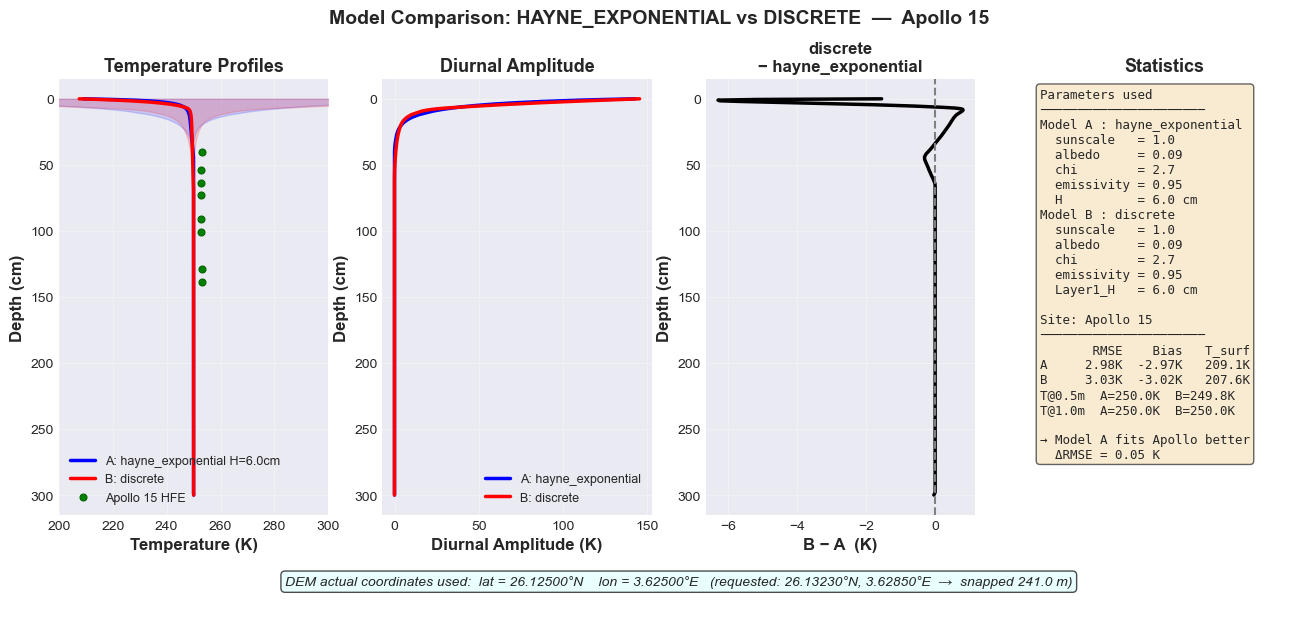


✓ Apollo 15 done!
  A RMSE = 2.980 K    B RMSE = 3.030 K    (vs Apollo 15 HFE)

──────────────────────────────────────────────────────────────────────
RUNNING: Apollo 17  (20.1911°N, 30.7723°E)
──────────────────────────────────────────────────────────────────────

Requested : (20.191100°N, 30.772300°E)
DEM pixel : (20.125000°N, 30.875000°E)  [snapped 3544.6 m]

Elevation : -2662.0 m
Slope     : 4.66°  (0°=flat)
Aspect    : 357.5°  (0°=north, 90°=east)

Running Model A: hayne_exponential ...
  H = 0.0600 m = 6.00 cm
  ✓ Done in 10.9 s  [10036 timesteps × 165 depths]
Running Model B: discrete ...
  Discrete model: Layer 1 = 0–6.0 cm, Layer 2 = 6.0–20 cm, Layer 3 = >20 cm
  ✓ Done in 10.7 s

Surface temperature (final simulated lunar day):
  Model A: 90.0–385.6 K  (mean 214.1 K)
  Model B: 84.7–385.8 K  (mean 212.4 K)
  Matched Apollo 17 — distance to reference: 3737 m

✓ Apollo site matched: Apollo 17


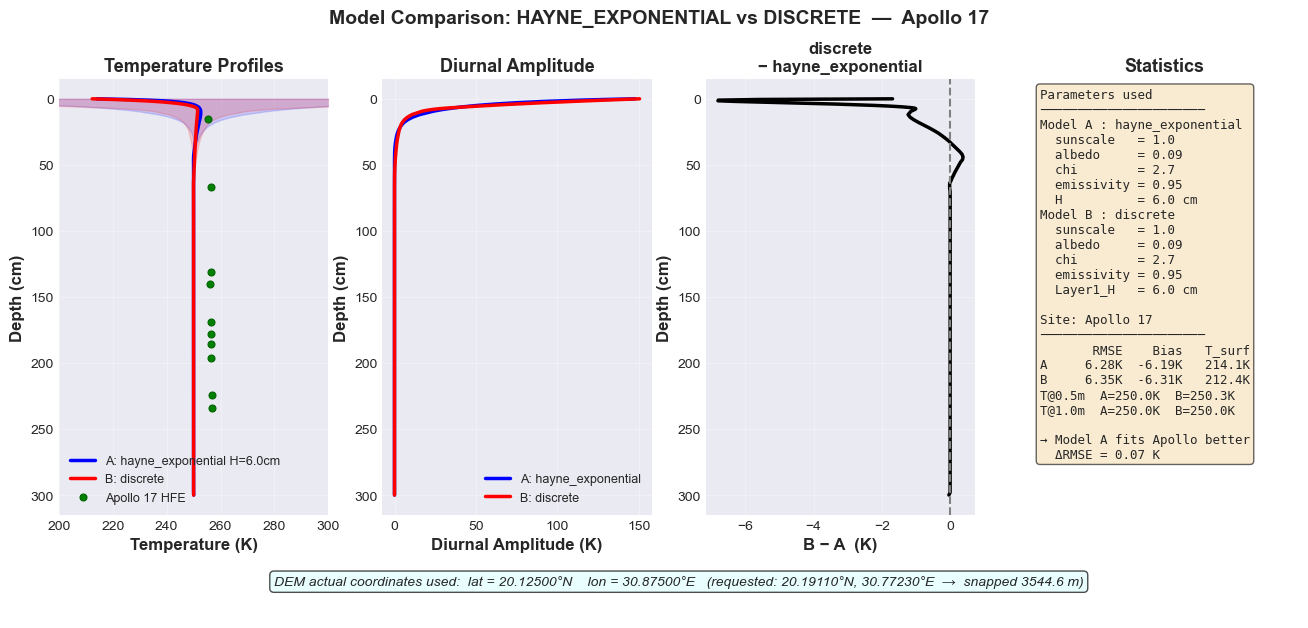


✓ Apollo 17 done!
  A RMSE = 6.280 K    B RMSE = 6.347 K    (vs Apollo 17 HFE)

All 2 location(s) processed.


In [ ]:
%matplotlib inline

# ============================================================================
# 📍 SECTION D: SINGLE LOCATION ANALYSIS
# ============================================================================
# PURPOSE
#   Run two thermal models (e.g. Hayne exponential vs Discrete layers) at one
#   or more locations, then compare their temperature–depth profiles.
#   If the location matches an Apollo Heat Flow Experiment (HFE) site, the code
#   also computes RMSE and bias against the real drilled measurements.
#
# HOW TO USE
#   1. Edit LOCATIONS_TO_RUN — add/remove sites or change coordinates.
#   2. Choose SINGLE_MODEL_A and SINGLE_MODEL_B.
#   3. Adjust per-model parameters (sunscale, albedo, H, etc.).
#   4. Run this cell (Shift+Enter).
#      One figure is produced per location in LOCATIONS_TO_RUN.
#
# APOLLO REFERENCE COORDINATES
#   Apollo 15  – Hadley-Apennine:  lat=26.1323°N,  lon=3.6285°E
#   Apollo 17  – Taurus-Littrow:   lat=20.1911°N,  lon=30.7723°E
# ============================================================================

# ── USER CONFIGURATION ───────────────────────────────────────────────────────

# ┌─ LIST OF LOCATIONS TO RUN ─────────────────────────────────────────────────┐
# │  Each entry is a dict with keys:                                           │
# │    'name' : label shown in the plot title                                  │
# │    'lat'  : latitude  (degrees, positive=north, negative=south)            │
# │    'lon'  : longitude (degrees, 0–360 east)                                │
# │    'llst' : Local Solar Time of interest (0=midnight, 12=noon)             │
# │                                                                             │
# │  To run only ONE site:  remove the other dict from the list.               │
# │  To add a custom site:  append another dict, e.g.                          │
# │    {'name': 'My Site', 'lat': 10.0, 'lon': 45.0, 'llst': 6.0}            │
# └────────────────────────────────────────────────────────────────────────────┘
LOCATIONS_TO_RUN = [
    {'name': 'Apollo 15',  'lat': 26.1323, 'lon':  3.6285, 'llst': 12.0},
    {'name': 'Apollo 17',  'lat': 20.1911, 'lon': 30.7723, 'llst': 12.0},
    # Add more sites below this line:
    # {'name': 'Custom site', 'lat': 0.0, 'lon': 0.0, 'llst': 12.0},
]

# ── MODEL SELECTION ───────────────────────────────────────────────────────────
# Options: 'hayne_exponential' | 'discrete' | 'custom'
SINGLE_MODEL_A = 'hayne_exponential'   # Model A — shown in blue
SINGLE_MODEL_B = 'discrete'            # Model B — shown in red

# ── MODEL A PARAMETERS ───────────────────────────────────────────────────────
MODEL_A_SUNSCALE   = 1.0    # Solar flux multiplier (1.0 = nominal Sun at 1 AU)
MODEL_A_ALBEDO     = 0.09   # Bond albedo: fraction of sunlight reflected (0–1)
MODEL_A_CHI        = 2.7    # Radiative conductivity exponent (dimensionless)
MODEL_A_EMISSIVITY = 0.95   # Infrared emissivity (1.0 = perfect blackbody)
MODEL_A_NDAYS      = 5      # Number of lunar days to simulate (more = better spin-up)
MODEL_A_H          = 0.07   # Hayne scale height IN METRES — only used when
                             # SINGLE_MODEL_A = 'hayne_exponential'
                             # 0.07 m = 7 cm (Hayne et al. 2017 global average)
                             # Typical range: 0.03 m (3 cm) to 0.15 m (15 cm)

# ── MODEL B PARAMETERS ───────────────────────────────────────────────────────
MODEL_B_SUNSCALE   = 1.0
MODEL_B_ALBEDO     = 0.09
MODEL_B_CHI        = 2.7
MODEL_B_EMISSIVITY = 0.95
MODEL_B_NDAYS      = 5
MODEL_B_H          = 0.07   # H parameter for Model B (in metres)
                             # • If 'hayne_exponential': e-folding scale for density
                             # • If 'discrete': Layer 1 thickness (0 to H = fluffy layer)
                             #   Default 0.07 m = 7 cm
                             # 
                             # Layer structure when MODEL_B = 'discrete' with H = 0.07:
                             #   Layer 1: 0 – 7 cm    (ρ = 1100 kg/m³, uniform)
                             #   Layer 2: 7 – 20 cm   (ρ = 1100 → 1700 kg/m³, linear)
                             #   Layer 3: > 20 cm     (ρ = 1700 → 1800 kg/m³, slow ramp)

# ── PLOT APPEARANCE ───────────────────────────────────────────────────────────

# ↓ ADJUST DEPTH UNITS HERE ──────────────────────────────────────────────────
# Change DEPTH_SCALE and DEPTH_UNIT_LABEL together.
# Common choices:
#   DEPTH_SCALE = 100  → depth axis in centimetres (cm)   ← default
#   DEPTH_SCALE = 1    → depth axis in metres      (m)
DEPTH_SCALE      = 100          # multiplier: model depths (m) × DEPTH_SCALE → plot unit
DEPTH_UNIT_LABEL = 'cm'         # label shown on the depth (y) axis

# ↓ ADJUST TEMPERATURE UNITS HERE ────────────────────────────────────────────
# Temperatures are computed in Kelvin (K). To convert to Celsius:
#   TEMP_OFFSET = -273.15   and   TEMP_UNIT_LABEL = '°C'
# Leave at 0 / 'K' to keep Kelvin (default).
TEMP_OFFSET      = 0            # added to every temperature value (K→°C: use -273.15)
TEMP_UNIT_LABEL  = 'K'          # label shown on the temperature (x) axis

# ↓ ADJUST FIGURE SIZE HERE ──────────────────────────────────────────────────
FIG_WIDTH        = 16           # total figure width  in inches
FIG_HEIGHT       = 7            # total figure height in inches

# ↓ ADJUST FONT SIZES HERE ───────────────────────────────────────────────────
FONT_AXIS_LABEL  = 12           # size of x/y axis labels
FONT_TITLE       = 13           # size of panel titles
FONT_SUPTITLE    = 14           # size of the overall figure title
FONT_LEGEND      = 9            # size of legend text
FONT_STATS       = 9            # size of statistics / parameter text box

# ↓ ADJUST APOLLO DATA POINT STYLE HERE ─────────────────────────────────────
# These control how the actual Apollo HFE probe measurements are plotted.
# Marker options: 'o'=filled circle, 's'=square, '^'=triangle, 'D'=diamond
APOLLO_MARKER       = 'o'       # marker shape
APOLLO_MARKER_SIZE  = 25        # marker size in points² (25 = small filled dot)
APOLLO_MARKER_COLOR = 'green'   # fill colour of the data points

# ↓ ADJUST WHICH PROFILE DEPTHS ARE REPORTED IN THE STATS BOX ───────────────
# Add or remove depth values (in metres) — model output is interpolated there.
# Example: [0.5, 1.0, 2.0]  adds a 2 m row to the stats table.
REPORT_DEPTHS_M  = [0.5, 1.0]  # depths in metres to show in the statistics box

# ── EXECUTION (no need to edit below this line) ──────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec as _gs
import time

# ─────────────────────────────────────────────────────────────────────────────
# Print a full parameter summary so it appears in the cell output.
# This makes it easy to record exactly what settings produced a given figure.
# ─────────────────────────────────────────────────────────────────────────────
print(f"\n{'='*70}")
print("SINGLE LOCATION ANALYSIS — PARAMETER SUMMARY")
print(f"{'='*70}")
print(f"  Locations   : {[loc['name'] for loc in LOCATIONS_TO_RUN]}")
print(f"  Model A     : {SINGLE_MODEL_A}")
print(f"    sunscale  = {MODEL_A_SUNSCALE}")
print(f"    albedo    = {MODEL_A_ALBEDO}")
print(f"    chi       = {MODEL_A_CHI}")
print(f"    emissivity= {MODEL_A_EMISSIVITY}")
print(f"    ndays     = {MODEL_A_NDAYS}")
if SINGLE_MODEL_A == 'hayne_exponential':
    print(f"    H         = {MODEL_A_H:.4f} m  ({MODEL_A_H*100:.2f} cm)")
print(f"  Model B     : {SINGLE_MODEL_B}")
print(f"    sunscale  = {MODEL_B_SUNSCALE}")
print(f"    albedo    = {MODEL_B_ALBEDO}")
print(f"    chi       = {MODEL_B_CHI}")
print(f"    emissivity= {MODEL_B_EMISSIVITY}")
print(f"    ndays     = {MODEL_B_NDAYS}")
if SINGLE_MODEL_B == 'hayne_exponential':
    print(f"    H         = {MODEL_B_H:.4f} m  ({MODEL_B_H*100:.2f} cm)")
print(f"  Depth unit  : {DEPTH_UNIT_LABEL}  (scale ×{DEPTH_SCALE})")
print(f"  Temp unit   : {TEMP_UNIT_LABEL}  (offset {TEMP_OFFSET:+g})")
print(f"{'='*70}\n")


# ─────────────────────────────────────────────────────────────────────────────
# HELPER: extract min/max/mean from the LAST simulated lunar day
# ─────────────────────────────────────────────────────────────────────────────
def _final_day_stats(T_prof, t_arr):
    """
    Return (T_min, T_max, T_mean) vs depth for the final simulated lunar day.

    WHY the final day?
      Day 1 starts from a uniform T_INIT which is artificial.  After several
      days the model reaches thermal equilibrium ("spin-up").  Only the last
      day represents a realistic steady-state diurnal cycle.
    """
    t_start = t_arr[-1] - LUNAR_DAY          # start of the last lunar day (seconds)
    idx     = np.where(t_arr >= t_start)[0]  # indices of timesteps in that window
    T_last  = T_prof[idx, :]                 # shape: [n_snapshots × n_depths]
    return (np.min(T_last,  axis=0),
            np.max(T_last,  axis=0),
            np.mean(T_last, axis=0))


# ─────────────────────────────────────────────────────────────────────────────
# Apollo HFE site registry (used for auto-detection and validation)
# ─────────────────────────────────────────────────────────────────────────────
APOLLO_SITES_SINGLE = {
    'Apollo 15': {'lat': 26.1341, 'lon':  3.6285, 'data_key': 'Apollo 15'},
    'Apollo 17': {'lat': 20.1921, 'lon': 30.7649, 'data_key': 'Apollo 17'},
}


# ─────────────────────────────────────────────────────────────────────────────
# MAIN LOOP — runs once per entry in LOCATIONS_TO_RUN
# ─────────────────────────────────────────────────────────────────────────────
for _loc in LOCATIONS_TO_RUN:

    SINGLE_LAT  = _loc['lat']
    SINGLE_LON  = _loc['lon']
    SINGLE_LLST = _loc['llst']
    loc_name    = _loc['name']

    print(f"\n{'─'*70}")
    print(f"RUNNING: {loc_name}  ({SINGLE_LAT:.4f}°N, {SINGLE_LON:.4f}°E)")
    print(f"{'─'*70}\n")

    try:
        # ── STEP 1: Snap requested coordinates to nearest DEM grid point ─────
        # The LOLA DEM is a fixed grid; latlon_to_pixel() finds the closest
        # pixel and returns its exact centre coordinates.  All physics (slope,
        # aspect, horizon, solar flux) are evaluated at those snapped coords.
        i_tgt, j_tgt, act_lat, act_lon = latlon_to_pixel(
            SINGLE_LAT, SINGLE_LON, H, W, map_res
        )
        snap_dist = _haversine_moon_m(SINGLE_LAT, SINGLE_LON, act_lat, act_lon)
        print(f"Requested : ({SINGLE_LAT:.6f}°N, {SINGLE_LON:.6f}°E)")
        print(f"DEM pixel : ({act_lat:.6f}°N, {act_lon:.6f}°E)  [snapped {snap_dist:.1f} m]\n")

        # ── STEP 2: Terrain properties at this pixel ──────────────────────────
        elevation             = float(LDEM_m[i_tgt, j_tgt])
        slope_loc, aspect_loc = compute_slope_aspect_point(LDEM_m, i_tgt, j_tgt, pixel_m)
        horizons_loc          = compute_horizon_profile(i_tgt, j_tgt, LDEM_m, pixel_m, az_angles)
        print(f"Elevation : {elevation:.1f} m")
        print(f"Slope     : {np.rad2deg(slope_loc):.2f}°  (0°=flat)")
        print(f"Aspect    : {np.rad2deg(aspect_loc):.1f}°  (0°=north, 90°=east)\n")

        # ── STEP 3: Run Model A ───────────────────────────────────────────────
        # For 'hayne_exponential': set the scale height globally, then call the
        # H-aware wrapper.  For 'discrete' or 'custom': use the standard solver.
        print(f"Running Model A: {SINGLE_MODEL_A} ...")
        t0         = time.time()
        model_A_id = MODEL_ID_MAP.get(SINGLE_MODEL_A, 0)
        if SINGLE_MODEL_A == 'hayne_exponential':
            set_hayne_h(MODEL_A_H)
            print(f"  H = {MODEL_A_H:.4f} m = {MODEL_A_H*100:.2f} cm")
            T_A, t_A = solve_thermal_model_with_h_param(
                z_grid, T_INIT, act_lat, act_lon,
                slope_loc, aspect_loc, horizons_loc, az_angles,
                chi_param=MODEL_A_CHI, model_id=model_A_id, sunscale=MODEL_A_SUNSCALE,
                ndays=MODEL_A_NDAYS, H_param=MODEL_A_H, dt_frac=0.01,
                albedo=MODEL_A_ALBEDO, emissivity=MODEL_A_EMISSIVITY,
            )
        else:
            T_A, t_A = solve_thermal_model(
                z_grid=z_grid, T_init=T_INIT,
                lat_deg=act_lat, lon_deg=act_lon,
                slope=slope_loc, aspect=aspect_loc,
                horizons=horizons_loc, az_angles=az_angles,
                chi_param=MODEL_A_CHI, model_id=model_A_id,
                sunscale=MODEL_A_SUNSCALE, ndays=MODEL_A_NDAYS, dt_frac=0.01,
                albedo=MODEL_A_ALBEDO, emissivity=MODEL_A_EMISSIVITY,
            )
        T_A = np.asarray(T_A); t_A = np.asarray(t_A)
        print(f"  ✓ Done in {time.time()-t0:.1f} s  [{T_A.shape[0]} timesteps × {T_A.shape[1]} depths]")

        # ── STEP 4: Run Model B ───────────────────────────────────────────────
        print(f"Running Model B: {SINGLE_MODEL_B} ...")
        t0         = time.time()
        model_B_id = MODEL_ID_MAP.get(SINGLE_MODEL_B, 0)
        
        if SINGLE_MODEL_B == 'hayne_exponential':
            set_hayne_h(MODEL_B_H)
            print(f"  Hayne model: H = {MODEL_B_H:.4f} m = {MODEL_B_H*100:.2f} cm (e-folding depth)")
            T_B, t_B = solve_thermal_model_with_h_param(
                z_grid, T_INIT, act_lat, act_lon,
                slope_loc, aspect_loc, horizons_loc, az_angles,
                chi_param=MODEL_B_CHI, model_id=model_B_id, sunscale=MODEL_B_SUNSCALE,
                ndays=MODEL_B_NDAYS, H_param=MODEL_B_H, dt_frac=0.01,
                albedo=MODEL_B_ALBEDO, emissivity=MODEL_B_EMISSIVITY,
            )
        elif SINGLE_MODEL_B == 'discrete':
            # Set the discrete Layer 1 boundary using MODEL_B_H
            # This allows fair comparison: both models use the same characteristic depth
            set_layer1_h(MODEL_B_H)
            print(f"  Discrete model: Layer 1 = 0–{MODEL_B_H*100:.1f} cm, "
                  f"Layer 2 = {MODEL_B_H*100:.1f}–20 cm, Layer 3 = >20 cm")
            T_B, t_B = solve_thermal_model(
                z_grid=z_grid, T_init=T_INIT,
                lat_deg=act_lat, lon_deg=act_lon,
                slope=slope_loc, aspect=aspect_loc,
                horizons=horizons_loc, az_angles=az_angles,
                chi_param=MODEL_B_CHI, model_id=model_B_id,
                sunscale=MODEL_B_SUNSCALE, ndays=MODEL_B_NDAYS, dt_frac=0.01,
                albedo=MODEL_B_ALBEDO, emissivity=MODEL_B_EMISSIVITY,
            )
        else:
            # Custom model
            T_B, t_B = solve_thermal_model(
                z_grid=z_grid, T_init=T_INIT,
                lat_deg=act_lat, lon_deg=act_lon,
                slope=slope_loc, aspect=aspect_loc,
                horizons=horizons_loc, az_angles=az_angles,
                chi_param=MODEL_B_CHI, model_id=model_B_id,
                sunscale=MODEL_B_SUNSCALE, ndays=MODEL_B_NDAYS, dt_frac=0.01,
                albedo=MODEL_B_ALBEDO, emissivity=MODEL_B_EMISSIVITY,
            )
        T_B = np.asarray(T_B); t_B = np.asarray(t_B)
        print(f"  ✓ Done in {time.time()-t0:.1f} s\n")

        # ── STEP 5: Extract final-day statistics ──────────────────────────────
        A_min, A_max, A_mean = _final_day_stats(T_A, t_A)
        B_min, B_max, B_mean = _final_day_stats(T_B, t_B)
        print(f"Surface temperature (final simulated lunar day):")
        print(f"  Model A: {A_min[0]+TEMP_OFFSET:.1f}–{A_max[0]+TEMP_OFFSET:.1f} {TEMP_UNIT_LABEL}"
              f"  (mean {A_mean[0]+TEMP_OFFSET:.1f} {TEMP_UNIT_LABEL})")
        print(f"  Model B: {B_min[0]+TEMP_OFFSET:.1f}–{B_max[0]+TEMP_OFFSET:.1f} {TEMP_UNIT_LABEL}"
              f"  (mean {B_mean[0]+TEMP_OFFSET:.1f} {TEMP_UNIT_LABEL})")

        # ── STEP 6: Check for Apollo HFE validation data ──────────────────────
        # If we are within 0.1° (~3 km) of an Apollo landing site, retrieve the
        # probe temperatures measured at known depths and compute RMSE / bias.
        apollo_match = None
        a_depths = a_temps = None
        for site_name, info in APOLLO_SITES_SINGLE.items():
            # ── Use haversine distance instead of a degree-box threshold ──────
            # A 0.1° box fails when DEM snapping moves a coordinate just past the
            # boundary.  Example: Apollo 17 reference lon=30.7649°E but the DEM
            # snapped to lon=30.875°E → difference 0.110° > 0.1° → site missed.
            #
            # The haversine formula gives the true great-circle distance on the
            # Moon's surface, so the match is reliable regardless of snap distance.
            #
            # ↓ ADJUST MATCH RADIUS HERE (metres) ────────────────────────────
            APOLLO_SITE_MATCH_RADIUS_M = 10_000   # 10 km — generous, no false positives
            site_dist_m = _haversine_moon_m(act_lat, act_lon, info['lat'], info['lon'])
            if site_dist_m <= APOLLO_SITE_MATCH_RADIUS_M:
                apollo_match = site_name
                data = APOLLO_DATA.get(info['data_key'], [])
                if data:
                    a_depths = np.array([d for d, _ in data])   # probe depths (m)
                    a_temps  = np.array([t for _, t in data])   # measured temps (K)
                print(f"  Matched {site_name} — distance to reference: {site_dist_m:.0f} m")
                break
        if apollo_match:
            print(f"\n✓ Apollo site matched: {apollo_match}")
        else:
            print(f"\n⚠  Not near an Apollo site — no validation data")

        # ── STEP 7: Convert to display units before plotting ──────────────────
        # DEPTH_SCALE and TEMP_OFFSET are set in the USER CONFIGURATION section.
        # All plot calls below use these converted arrays, so changing those two
        # variables at the top is all that's needed to switch units.
        z_plot   = z_grid * DEPTH_SCALE          # e.g. m × 100 → cm
        A_mean_T = A_mean + TEMP_OFFSET           # e.g. K + 0 → K  or  K - 273.15 → °C
        A_min_T  = A_min  + TEMP_OFFSET
        A_max_T  = A_max  + TEMP_OFFSET
        B_mean_T = B_mean + TEMP_OFFSET
        B_min_T  = B_min  + TEMP_OFFSET
        B_max_T  = B_max  + TEMP_OFFSET

        # ── STEP 8: Create 4-panel figure ────────────────────────────────────
        # Layout: [Profiles | Amplitude | Difference | Stats]
        #          + thin info bar at the bottom showing actual DEM coordinates
        fig     = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))  # ← FIG_WIDTH / FIG_HEIGHT above
        gs_obj  = _gs.GridSpec(2, 4, figure=fig, hspace=0.12, height_ratios=[6, 1])
        ax1     = fig.add_subplot(gs_obj[0, 0])   # Panel 1: temperature profiles
        ax2     = fig.add_subplot(gs_obj[0, 1])   # Panel 2: diurnal amplitude
        ax3     = fig.add_subplot(gs_obj[0, 2])   # Panel 3: model difference
        ax4     = fig.add_subplot(gs_obj[0, 3])   # Panel 4: statistics text
        ax_info = fig.add_subplot(gs_obj[1, :])   # Info bar: DEM coordinates
        ax_info.axis('off')

        # ── Panel 1: Temperature profiles ────────────────────────────────────
        # Blue shading + line = Model A.  Red shading + line = Model B.
        # Shaded band shows the full diurnal range (min to max) over the last day.
        label_A = (f'A: {SINGLE_MODEL_A}'
                   + (f' H={MODEL_A_H*100:.1f}cm' if SINGLE_MODEL_A == 'hayne_exponential' else ''))
        label_B = (f'B: {SINGLE_MODEL_B}'
                   + (f' H={MODEL_B_H*100:.1f}cm' if SINGLE_MODEL_B == 'hayne_exponential' else ''))
        ax1.fill_betweenx(z_plot, A_min_T, A_max_T, alpha=0.15, color='blue')
        ax1.plot(A_mean_T, z_plot, 'b-', lw=2.5, label=label_A)
        ax1.fill_betweenx(z_plot, B_min_T, B_max_T, alpha=0.15, color='red')
        ax1.plot(B_mean_T, z_plot, 'r-', lw=2.5, label=label_B)
        if a_depths is not None:
            # Apollo HFE measurements — small filled circles for clarity.
            # ↓ Marker style is controlled by APOLLO_MARKER / SIZE / COLOR above
            ax1.scatter(a_temps + TEMP_OFFSET,
                        a_depths * DEPTH_SCALE,
                        c=APOLLO_MARKER_COLOR,
                        s=APOLLO_MARKER_SIZE,         # ← size: adjust APOLLO_MARKER_SIZE
                        zorder=5,
                        marker=APOLLO_MARKER,          # ← shape: adjust APOLLO_MARKER
                        label=f'{apollo_match} HFE',
                        edgecolors='darkgreen', linewidths=0.8)
        ax1.invert_yaxis()
        ax1.set_xlabel(f'Temperature ({TEMP_UNIT_LABEL})',    # ← unit from TEMP_UNIT_LABEL
                       fontsize=FONT_AXIS_LABEL, weight='bold')
        ax1.set_ylabel(f'Depth ({DEPTH_UNIT_LABEL})',          # ← unit from DEPTH_UNIT_LABEL
                       fontsize=FONT_AXIS_LABEL, weight='bold')
        ax1.set_title('Temperature Profiles', fontsize=FONT_TITLE, weight='bold')
        ax1.legend(fontsize=FONT_LEGEND, loc='best')
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(200, 300)   # Show only 200-300 K (change as needed)

        # ── Panel 2: Diurnal amplitude vs depth ──────────────────────────────
        # Amplitude = (Tmax − Tmin) / 2.  Large near the surface, decays with
        # depth as the thermal wave is attenuated.  The e-folding depth depends
        # on thermal diffusivity and the period (~29.53 Earth days).
        # NOTE: amplitude is always in Kelvin regardless of TEMP_UNIT_LABEL
        #       because it is a difference (the offset cancels).
        A_amp = (A_max - A_min) / 2.0
        B_amp = (B_max - B_min) / 2.0
        ax2.plot(A_amp, z_plot, 'b-', lw=2.5, label=f'A: {SINGLE_MODEL_A}')
        ax2.plot(B_amp, z_plot, 'r-', lw=2.5, label=f'B: {SINGLE_MODEL_B}')
        ax2.invert_yaxis()
        ax2.set_xlabel('Diurnal Amplitude (K)',      # always K — amplitude is a difference
                       fontsize=FONT_AXIS_LABEL, weight='bold')
        ax2.set_ylabel(f'Depth ({DEPTH_UNIT_LABEL})',
                       fontsize=FONT_AXIS_LABEL, weight='bold')
        ax2.set_title('Diurnal Amplitude', fontsize=FONT_TITLE, weight='bold')
        ax2.legend(fontsize=FONT_LEGEND, loc='best')
        ax2.grid(True, alpha=0.3)

        # ── Panel 3: Model difference (B − A) ────────────────────────────────
        # Positive = Model B is warmer.  Converges to ~0 at depth where both
        # models reach the same thermal equilibrium.
        # NOTE: difference is in Kelvin (the offset cancels in subtraction).
        diff = B_mean - A_mean
        ax3.plot(diff, z_plot, 'k-', lw=2.5)
        ax3.axvline(0, color='gray', ls='--', lw=1.5)
        ax3.invert_yaxis()
        ax3.set_xlabel('B − A  (K)',                 # always K — difference cancels offset
                       fontsize=FONT_AXIS_LABEL, weight='bold')
        ax3.set_ylabel(f'Depth ({DEPTH_UNIT_LABEL})',
                       fontsize=FONT_AXIS_LABEL, weight='bold')
        ax3.set_title(f'{SINGLE_MODEL_B}\n− {SINGLE_MODEL_A}',
                      fontsize=FONT_TITLE - 1, weight='bold')
        ax3.grid(True, alpha=0.3)

        # ── Panel 4: Statistics + parameter list ─────────────────────────────
        ax4.axis('off')

        # Parameter block — always shown so the figure is self-documenting
        p  = "Parameters used\n"
        p += "─" * 22 + "\n"
        p += f"Model A : {SINGLE_MODEL_A}\n"
        p += f"  sunscale   = {MODEL_A_SUNSCALE}\n"
        p += f"  albedo     = {MODEL_A_ALBEDO}\n"
        p += f"  chi        = {MODEL_A_CHI}\n"
        p += f"  emissivity = {MODEL_A_EMISSIVITY}\n"
        if SINGLE_MODEL_A == 'hayne_exponential':
            p += f"  H          = {MODEL_A_H*100:.1f} cm\n"
        p += f"Model B : {SINGLE_MODEL_B}\n"
        p += f"  sunscale   = {MODEL_B_SUNSCALE}\n"
        p += f"  albedo     = {MODEL_B_ALBEDO}\n"
        p += f"  chi        = {MODEL_B_CHI}\n"
        p += f"  emissivity = {MODEL_B_EMISSIVITY}\n"
        if SINGLE_MODEL_B == 'hayne_exponential':
            p += f"  H          = {MODEL_B_H*100:.1f} cm\n"
        elif SINGLE_MODEL_B == 'discrete':
            p += f"  Layer1_H   = {MODEL_B_H*100:.1f} cm\n"

        # Validation block — only if Apollo HFE data matched
        if a_depths is not None:
            A_at_a = np.interp(a_depths, z_grid, A_mean)
            B_at_a = np.interp(a_depths, z_grid, B_mean)
            A_rmse = np.sqrt(np.mean((A_at_a - a_temps)**2))
            B_rmse = np.sqrt(np.mean((B_at_a - a_temps)**2))
            A_bias = np.mean(A_at_a - a_temps)
            B_bias = np.mean(B_at_a - a_temps)
            winner = 'A' if A_rmse < B_rmse else 'B'

            p += f"\nSite: {apollo_match}\n"
            p += "─" * 22 + "\n"
            p += f"{'':4s} {'RMSE':>6}  {'Bias':>6}  {'T_surf':>7}\n"
            p += f"A    {A_rmse:5.2f}K  {A_bias:+5.2f}K  {A_mean[0]+TEMP_OFFSET:6.1f}{TEMP_UNIT_LABEL}\n"
            p += f"B    {B_rmse:5.2f}K  {B_bias:+5.2f}K  {B_mean[0]+TEMP_OFFSET:6.1f}{TEMP_UNIT_LABEL}\n"
            # ↓ REPORT_DEPTHS_M controls which depths appear here (edit above)
            for d_m in REPORT_DEPTHS_M:
                T_A_d = np.interp(d_m, z_grid, A_mean) + TEMP_OFFSET
                T_B_d = np.interp(d_m, z_grid, B_mean) + TEMP_OFFSET
                p += f"T@{d_m:.1f}m  A={T_A_d:.1f}{TEMP_UNIT_LABEL}  B={T_B_d:.1f}{TEMP_UNIT_LABEL}\n"
            p += f"\n→ Model {winner} fits Apollo better\n"
            p += f"  ΔRMSE = {abs(A_rmse-B_rmse):.2f} K"
        else:
            p += f"\nNo Apollo site nearby\n"
            p += f"T_surf A = {A_mean[0]+TEMP_OFFSET:.1f} {TEMP_UNIT_LABEL}\n"
            p += f"T_surf B = {B_mean[0]+TEMP_OFFSET:.1f} {TEMP_UNIT_LABEL}"

        ax4.text(0.04, 0.98, p, transform=ax4.transAxes,
                 fontsize=FONT_STATS,       # ← adjust with FONT_STATS above
                 va='top', family='monospace',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6))
        ax4.set_title('Statistics', fontsize=FONT_TITLE, weight='bold')

        # ── Info bar: actual DEM coordinates (always shown) ──────────────────
        info_str = (
            f"DEM actual coordinates used:  lat = {act_lat:.5f}°N    lon = {act_lon:.5f}°E   "
            f"(requested: {SINGLE_LAT:.5f}°N, {SINGLE_LON:.5f}°E  →  snapped {snap_dist:.1f} m)"
        )
        ax_info.text(0.5, 0.5, info_str, transform=ax_info.transAxes,
                     fontsize=10, ha='center', va='center', style='italic',
                     bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.7))

        fig.suptitle(
            f'Model Comparison: {SINGLE_MODEL_A.upper()} vs {SINGLE_MODEL_B.upper()}'
            + (f'  —  {apollo_match}' if apollo_match else f'  —  {loc_name}'),
            fontsize=FONT_SUPTITLE, fontweight='bold'
        )
        plt.tight_layout()
        plt.show()

        print(f"\n✓ {loc_name} done!")
        if a_depths is not None:
            print(f"  A RMSE = {A_rmse:.3f} K    B RMSE = {B_rmse:.3f} K    (vs {apollo_match} HFE)")

    except NameError as e:
        print(f"\n❌ Variable not found: {e}")
        print("   Make sure all cells above have been run.")
        print("   Required: LDEM_m, H, W, map_res, pixel_m, az_angles, z_grid, T_INIT,")
        print("             LUNAR_DAY, MODEL_ID_MAP, solve_thermal_model, APOLLO_DATA")
    except Exception as e:
        import traceback
        print(f"\n❌ Error in {loc_name}: {e}")
        traceback.print_exc()

print(f"\n{'='*70}")
print(f"All {len(LOCATIONS_TO_RUN)} location(s) processed.")
print(f"{'='*70}")


## 🔍 Single Location Sensitivity Analysis

Test how individual parameters (H, albedo, sunscale, emissivity, chi) affect model predictions at a specific location.


PARAMETER SENSITIVITY  —  H_PARAMETER
Description : Hayne e-folding scale height — smaller H → denser regolith shallower
Units       : (metres)
Range       : 0.0300 → 0.1500  (8 values)
Baseline    : 0.0700  (value used in main run)
Location    : 20.1911°N,  30.7723°E

DEM pixel: (20.1250°N, 30.8750°E)

⚠  No Apollo site nearby — sensitivity plots only (no validation)

  [ 1/8]  h_parameter = 0.0300 (metres)  →  T_surf=217.2 K  (20.0 s)
  [ 2/8]  h_parameter = 0.0471 (metres)  →  T_surf=216.8 K  (19.4 s)
  [ 3/8]  h_parameter = 0.0643 (metres)  →  T_surf=216.3 K  (20.7 s)
  [ 4/8]  h_parameter = 0.0814 (metres)  →  T_surf=215.9 K  (19.4 s)
  [ 5/8]  h_parameter = 0.0986 (metres)  →  T_surf=215.6 K  (19.6 s)
  [ 6/8]  h_parameter = 0.1157 (metres)  →  T_surf=215.4 K  (20.0 s)
  [ 7/8]  h_parameter = 0.1329 (metres)  →  T_surf=215.2 K  (19.7 s)
  [ 8/8]  h_parameter = 0.1500 (metres)  →  T_surf=215.0 K  (20.3 s)

✓ Sweep complete in 159.0 s


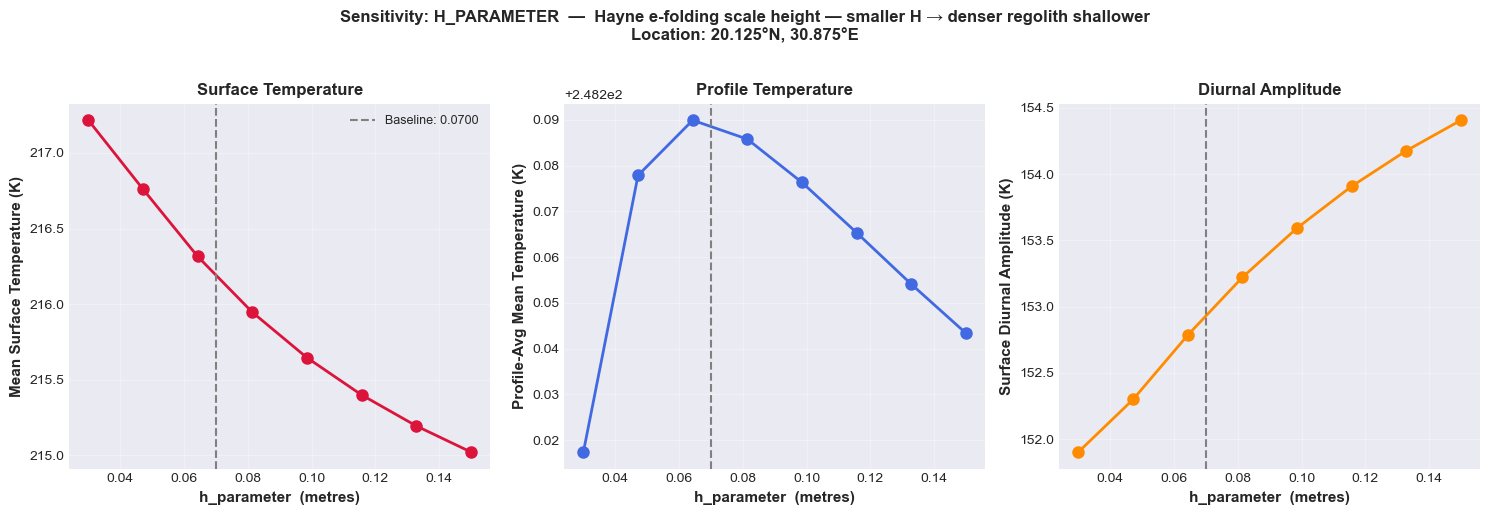


──────────────────────────────────────────────────────────────────────
SENSITIVITY SUMMARY:  H_PARAMETER
──────────────────────────────────────────────────────────────────────
  Surface temperature range : 215.0 – 217.2 K  (Δ = 2.2 K)
  Profile mean range        : 248.2 – 248.3 K  (Δ = 0.1 K)
  Diurnal amplitude range   : 151.9 – 154.4 K  (Δ = 2.5 K)

  Sensitivity level: 🟢 LOW        — minor effect on predictions
──────────────────────────────────────────────────────────────────────


In [ ]:
%matplotlib inline

# ============================================================================
# 🔍 SECTION E: SINGLE LOCATION SENSITIVITY ANALYSIS
# ============================================================================
# PURPOSE
#   Vary ONE model parameter across a range of values while holding all others
#   fixed, then record how the temperature output changes.  This answers:
#     • Which parameter has the biggest effect on surface temperature?
#     • What value gives the best match to Apollo HFE measurements?
#     • How much does ±20% uncertainty in albedo matter for subsurface temps?
#
# HOW TO USE
#   1. Set SENSITIVITY_PARAM to the parameter you want to test (see list below).
#   2. Optionally adjust the test range in PARAM_RANGES.
#   3. Run this cell (Shift+Enter).  Each parameter value runs a full simulation.
#      With NDAYS_SENS=1, expect ~30–60 s for 8 values (pure-Python H sweep) or
#      ~10 s for other parameters (Numba-compiled solver).
#
# PARAMETERS YOU CAN TEST
#   'sunscale'    – solar flux multiplier (accounts for dust, calibration errors)
#   'albedo'      – Bond albedo / reflectance of the surface
#   'emissivity'  – how efficiently the surface radiates heat as infrared
#   'chi'         – radiative conductivity exponent (controls k vs T relationship)
#   'h_parameter' – Hayne exponential scale height in metres (e.g. 0.07 = 7 cm)
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
import time

# ── USER CONFIGURATION ───────────────────────────────────────────────────────

# Which parameter to sweep?  (copy one of the strings exactly, with quotes)
SENSITIVITY_PARAM = 'h_parameter'   # ← CHANGE THIS LINE to test other parameters

# Test ranges — edit the 'values' array for any parameter to change the sweep range
PARAM_RANGES = {
    'sunscale':    {
        'values':      np.linspace(0.90, 1.15, 8),
        'units':       '(dimensionless)',
        'description': 'Solar flux multiplier — 1.0 = nominal solar constant S₀',
        'baseline':    SUNSCALE,         # value used in main run (from config cell)
    },
    'albedo':      {
        'values':      np.linspace(0.07, 0.14, 8),
        'units':       '(fraction, 0–1)',
        'description': 'Bond albedo — fraction of sunlight reflected; lower → surface absorbs more',
        'baseline':    ALBEDO,
    },
    'emissivity':  {
        'values':      np.linspace(0.90, 0.98, 8),
        'units':       '(fraction, 0–1)',
        'description': 'Infrared emissivity — 1.0 = perfect blackbody radiator',
        'baseline':    EMISSIVITY,
    },
    'chi':         {
        'values':      np.linspace(1.5, 4.0, 8),
        'units':       '(dimensionless)',
        'description': 'Radiative conductivity exponent — higher → k increases faster with T',
        'baseline':    CHI,
    },
    'h_parameter': {
        'values':      np.linspace(0.03, 0.15, 8),  # metres (0.03 m = 3 cm, 0.15 m = 15 cm)
        'units':       '(metres)',
        'description': 'Hayne e-folding scale height — smaller H → denser regolith shallower',
        'baseline':    0.07,             # Hayne et al. 2017 global average (7 cm)
    },
}

# Location — re-uses coordinates from Single Location Analysis if available,
# otherwise falls back to the main target location.
_loc_lat = SINGLE_LAT  if 'SINGLE_LAT'  in dir() else actual_lat
_loc_lon = SINGLE_LON  if 'SINGLE_LON'  in dir() else actual_lon

# Number of lunar days per simulation run.
# Fewer days = faster sweep; more days = better spin-up for absolute accuracy.
# 1 day is generally fine for sensitivity analysis (we care about RELATIVE changes).
NDAYS_SENS = 1

# ── PURE-PYTHON DENSITY FUNCTIONS FOR H-PARAMETER SWEEP ─────────────────────
# The main solver (solve_thermal_model) uses Numba-compiled density functions.
# Numba compiles functions at load time and cannot read Python variables that
# change between calls at runtime.  For the H-parameter sweep we therefore
# need a solver that accepts H directly as an argument.
# These pure-Python functions mirror the Hayne (2017) exponential model exactly.

def _py_rho_hayne(z, H):
    """
    Hayne exponential bulk density at depth z (m) with scale height H (m).

    ρ(z) = ρ_deep – (ρ_deep – ρ_surf) · exp(–z / H)

    Physics:
      Near the surface (z ≈ 0): loose fine-grained dust, ρ ≈ 1100 kg/m³
      Deep regolith (z >> H):   compacted grains,         ρ ≈ 1800 kg/m³
      H controls how steeply ρ rises with depth:
        small H (3 cm) → most compaction happens in the top 3 cm
        large H (15 cm)→ compaction extends further down
    """
    rho_surf = 1100.0   # kg/m³ — surface (very loose dust layer)
    rho_deep = 1800.0   # kg/m³ — deep compacted regolith
    return rho_deep - (rho_deep - rho_surf) * np.exp(-z / H)


def _py_k_solid_hayne(z, H):
    """
    Solid (lattice) thermal conductivity at depth z with scale height H.

    Conductivity rises with density because tightly packed grains transfer
    heat more efficiently by direct contact.  Values calibrated to
    Hayne et al. (2017) Table 3.

    Returns k_solid in W m⁻¹ K⁻¹
    """
    rho_surf = 1100.0; rho_deep = 1800.0
    rho      = rho_deep - (rho_deep - rho_surf) * np.exp(-z / H)
    k_surf   = 7.4e-4   # W/m/K at surface (very porous → low conductivity)
    k_deep   = 3.4e-3   # W/m/K at depth   (compacted → 4-5× higher)
    f        = (rho - rho_surf) / (rho_deep - rho_surf)   # normalised depth proxy
    return k_surf + (k_deep - k_surf) * f


def _solve_hayne_with_h(
    z_grid, T_init, lat_deg, lon_deg, slope, aspect,
    horizons, az_angles, chi_param, H_m,
    sunscale, ndays, dt_frac=0.01, albedo=0.09, emissivity=0.95
):
    """
    Pure-Python 1-D thermal diffusion solver with explicitly specified H_m.

    Identical physics to solve_thermal_model() in Section 10, but implemented
    in plain NumPy so H_m can be varied between calls without recompiling.
    This makes it slower (~3× slower per run) but flexible for sensitivity sweeps.

    Args
    ────
    z_grid    : 1-D depth array (m), surface at z_grid[0] = 0
    T_init    : initial uniform temperature (K) for all depths
    lat_deg   : latitude  (°, +north)
    lon_deg   : longitude (°, 0–360 east)
    slope     : surface slope angle (radians)
    aspect    : surface aspect  (radians, 0=north)
    horizons  : horizon elevation angles (rad) for shadow computation
    az_angles : azimuth angles paired with horizons (rad)
    chi_param : radiative conductivity exponent (dimensionless)
    H_m       : Hayne scale height IN METRES  (e.g. 0.07 for 7 cm)
    sunscale  : solar flux multiplier (1.0 = nominal)
    ndays     : number of lunar days to simulate
    dt_frac   : fraction of stability limit used as timestep (0.01 = safe)
    albedo    : Bond albedo (fraction, 0–1)
    emissivity: IR emissivity (fraction, 0–1)

    Returns
    ───────
    T_profile : 2-D array [n_saved × n_depths],  temperatures in K
    t_arr     : 1-D array [n_saved],              times in seconds
    """
    nz = len(z_grid)
    T  = np.full(nz, T_init, dtype=np.float64)

    # ── Pre-compute depth-dependent material properties for this H_m ─────────
    # We compute density and solid conductivity at each depth point once.
    # The total conductivity also has a radiation term that depends on T,
    # so it will be updated inside the time loop.
    rho_arr    = np.array([_py_rho_hayne(z, H_m)      for z in z_grid])
    k_sol_arr  = np.array([_py_k_solid_hayne(z, H_m)  for z in z_grid])

    # ── Timestep ──────────────────────────────────────────────────────────────
    # Von Neumann stability requires: dt ≤ 0.5 · ρ · cp · dz² / k
    # We use dt = dt_frac × dt_stable to stay well inside the stability limit.
    dz        = np.diff(z_grid)                      # layer thicknesses
    dz_min    = dz.min()
    dt_stable = 0.5 * rho_arr.max() * 1000.0 * dz_min**2 / k_sol_arr.max()
    dt        = dt_frac * dt_stable

    t_total       = ndays * LUNAR_DAY
    nt_total      = int(np.ceil(t_total / dt))
    save_interval = max(1, nt_total // 10000)   # save ~10 000 snapshots total
    nt_save       = nt_total // save_interval + 1

    T_profile = np.zeros((nt_save, nz), dtype=np.float32)
    t_arr     = np.zeros(nt_save,       dtype=np.float32)
    T_profile[0, :] = T
    save_idx  = 1
    t         = 0.0

    sigma = 5.670374e-8   # Stefan–Boltzmann constant  W m⁻² K⁻⁴
    T_ref = 350.0          # reference temperature for radiative k  (K)

    for it in range(nt_total):
        # 1. Solar position at time t
        theta_z, gamma_s, cos_theta = solar_geometry(lat_deg, lon_deg, t)

        # 2. Is the sun above the horizon? (accounts for surrounding terrain)
        lit = check_illumination(theta_z, gamma_s, horizons, az_angles)

        # 3. Absorbed solar flux at surface (W/m²)
        Qs = direct_solar_flux(theta_z, gamma_s, slope, aspect, sunscale, albedo) if lit else 0.0

        # 4. Total thermal conductivity = k_solid × (1 + χ·(T/T_ref)³)  [W/m/K]
        #    The radiation term (∝ T³) represents photon transport through pore space.
        k = k_sol_arr * (1.0 + chi_param * (T / T_ref)**3)

        # 5. Heat capacity (temperature-dependent, J kg⁻¹ K⁻¹)
        cp_arr = np.array([heat_capacity(T[iz]) for iz in range(nz)])

        # 6. Surface boundary — Newton–Raphson energy balance:
        #    absorbed solar Qs = emitted IR (ε σ T₀⁴) + heat conducted downward
        T[0] = surface_bc_newton(T[1], dz[0], Qs, k[0], emissivity)

        # 7. Interior finite-difference update  (explicit scheme)
        T_new = T.copy()
        for iz in range(1, nz - 1):
            k_up   = 0.5 * (k[iz-1] + k[iz])       # conductivity at upper interface
            k_dn   = 0.5 * (k[iz]   + k[iz+1])     # conductivity at lower interface
            q_up   = k_up * (T[iz] - T[iz-1]) / dz[iz-1]   # flux upward (W/m²)
            q_dn   = k_dn * (T[iz+1] - T[iz]) / dz[iz]     # flux downward
            dz_c   = 0.5 * (dz[iz-1] + dz[iz])             # effective cell width
            T_new[iz] = T[iz] + dt * (q_dn - q_up) / (dz_c * rho_arr[iz] * cp_arr[iz])

        # 8. Bottom boundary — constant basal heat flux from lunar interior
        #    Q_basal ≈ 18 mW/m² flowing upward from the deep mantle
        T_new[-1] = T[-2] + Q_basal * dz[-1] / k[-1]

        T  = T_new
        t += dt

        if (it + 1) % save_interval == 0 and save_idx < nt_save:
            T_profile[save_idx, :] = T
            t_arr[save_idx]        = t
            save_idx += 1

    return T_profile, t_arr


# ── EXECUTION — do not edit below ────────────────────────────────────────────

if SENSITIVITY_PARAM not in PARAM_RANGES:
    print(f"❌ '{SENSITIVITY_PARAM}' is not recognised.")
    print(f"   Valid options: {list(PARAM_RANGES.keys())}")
else:
    cfg        = PARAM_RANGES[SENSITIVITY_PARAM]
    pvals      = cfg['values']          # array of parameter values to test
    p_units    = cfg['units']
    p_desc     = cfg['description']
    p_baseline = cfg['baseline']

    print(f"\n{'='*70}")
    print(f"PARAMETER SENSITIVITY  —  {SENSITIVITY_PARAM.upper()}")
    print(f"{'='*70}")
    print(f"Description : {p_desc}")
    print(f"Units       : {p_units}")
    print(f"Range       : {pvals[0]:.4f} → {pvals[-1]:.4f}  ({len(pvals)} values)")
    print(f"Baseline    : {p_baseline:.4f}  (value used in main run)")
    print(f"Location    : {_loc_lat:.4f}°N,  {_loc_lon:.4f}°E")
    print(f"{'='*70}\n")

    # ── Snap location to DEM ──────────────────────────────────────────────────
    i_s, j_s, act_lat_s, act_lon_s = latlon_to_pixel(
        _loc_lat, _loc_lon, H, W, map_res
    )
    slope_s, aspect_s = compute_slope_aspect_point(LDEM_m, i_s, j_s, pixel_m)
    horizons_s        = compute_horizon_profile(i_s, j_s, LDEM_m, pixel_m, az_angles)
    print(f"DEM pixel: ({act_lat_s:.4f}°N, {act_lon_s:.4f}°E)\n")

    # ── Check for Apollo HFE data at this location ────────────────────────────
    APOLLO_SITES_S = {
        'Apollo 15': {'lat': 26.1341, 'lon': 3.6285},
        'Apollo 17': {'lat': 20.1921, 'lon': 30.7649},
    }
    apollo_s = None; a_dep_s = a_tmp_s = None
    for sn, sc in APOLLO_SITES_S.items():
        if abs(act_lat_s - sc['lat']) < 0.1 and abs(act_lon_s - sc['lon']) < 0.1:
            apollo_s = sn
            d = APOLLO_DATA.get(sn, [])
            if d:
                a_dep_s = np.array([x for x,_ in d])
                a_tmp_s = np.array([x for _,x in d])
            break

    if apollo_s:
        print(f"✓ Apollo site: {apollo_s} — will compute RMSE vs HFE data\n")
    else:
        print("⚠  No Apollo site nearby — sensitivity plots only (no validation)\n")

    # ── Output containers ─────────────────────────────────────────────────────
    out_T_surf = np.zeros(len(pvals))   # mean surface temperature for each test value
    out_T_mean = np.zeros(len(pvals))   # profile-averaged mean temperature
    out_T_amp  = np.zeros(len(pvals))   # surface diurnal amplitude (Tmax-Tmin)/2
    out_rmse   = np.zeros(len(pvals))   # RMSE vs Apollo HFE (NaN if no Apollo site)
    out_rmse[:] = np.nan

    # ── Sweep loop ────────────────────────────────────────────────────────────
    t_sweep = time.time()
    for ip, pval in enumerate(pvals):
        print(f"  [{ip+1:2d}/{len(pvals)}]  {SENSITIVITY_PARAM} = {pval:.4f} {p_units}",
              end='', flush=True)
        t0 = time.time()

        # Build keyword arguments — only the swept parameter changes each iteration;
        # all others stay at their baseline values.
        kw = dict(
            z_grid     = z_grid,
            T_init     = T_INIT,
            lat_deg    = act_lat_s,
            lon_deg    = act_lon_s,
            slope      = slope_s,
            aspect     = aspect_s,
            horizons   = horizons_s,
            az_angles  = az_angles,
            chi_param  = CHI       if SENSITIVITY_PARAM != 'chi'        else pval,
            sunscale   = SUNSCALE  if SENSITIVITY_PARAM != 'sunscale'   else pval,
            ndays      = NDAYS_SENS,
            dt_frac    = 0.01,
            albedo     = ALBEDO    if SENSITIVITY_PARAM != 'albedo'     else pval,
            emissivity = EMISSIVITY if SENSITIVITY_PARAM != 'emissivity' else pval,
        )

        if SENSITIVITY_PARAM == 'h_parameter':
            # H-parameter sweep: must use pure-Python solver (Numba can't take runtime H)
            T_s, t_s = _solve_hayne_with_h(**kw, H_m=pval)
        else:
            # All other parameters: use the fast Numba-compiled main solver
            # model_id=0 → discrete layer model (reference for non-H sweeps)
            T_s, t_s = solve_thermal_model(**kw, model_id=0)

        T_s = np.asarray(T_s); t_s = np.asarray(t_s)

        # Extract final-day statistics
        st = extract_final_day_statistics(T_s, t_s, z_grid)
        out_T_surf[ip] = st['T_mean'][0]              # surface mean T
        out_T_mean[ip] = np.mean(st['T_mean'])         # profile mean T
        out_T_amp[ip]  = st['T_amplitude'][0]          # surface diurnal amplitude

        # Compute RMSE if Apollo data available
        if apollo_s and a_dep_s is not None:
            T_model_at_apollo = np.interp(a_dep_s, z_grid, st['T_mean'])
            out_rmse[ip]      = np.sqrt(np.mean((T_model_at_apollo - a_tmp_s)**2))

        runtime = time.time() - t0
        line    = f"  →  T_surf={out_T_surf[ip]:.1f} K"
        if not np.isnan(out_rmse[ip]):
            line += f"  RMSE={out_rmse[ip]:.2f} K"
        line += f"  ({runtime:.1f} s)"
        print(line)

    print(f"\n✓ Sweep complete in {time.time()-t_sweep:.1f} s")

    # ── PLOTTING ──────────────────────────────────────────────────────────────
    # How many panels?  Add RMSE panel only if we have Apollo validation data.
    has_rmse   = apollo_s is not None and not np.all(np.isnan(out_rmse))
    n_panels   = 4 if has_rmse else 3
    fig_width  = 5 * n_panels
    fig, axes  = plt.subplots(1, n_panels, figsize=(fig_width, 5))

    TITLE_FS   = 12
    LABEL_FS   = 11
    MARKER     = 'o-'

    # Panel 1 — Mean surface temperature vs tested parameter
    axes[0].plot(pvals, out_T_surf, MARKER, color='crimson', lw=2, ms=8)
    axes[0].axvline(p_baseline, color='gray', ls='--', lw=1.5,
                    label=f'Baseline: {p_baseline:.4f}')
    axes[0].set_xlabel(f'{SENSITIVITY_PARAM}  {p_units}', fontsize=LABEL_FS, fontweight='bold')
    axes[0].set_ylabel('Mean Surface Temperature (K)',    fontsize=LABEL_FS, fontweight='bold')
    axes[0].set_title('Surface Temperature',  fontsize=TITLE_FS, fontweight='bold')
    axes[0].legend(fontsize=9); axes[0].grid(True, alpha=0.3)

    # Panel 2 — Profile-averaged mean temperature
    axes[1].plot(pvals, out_T_mean, MARKER, color='royalblue', lw=2, ms=8)
    axes[1].axvline(p_baseline, color='gray', ls='--', lw=1.5)
    axes[1].set_xlabel(f'{SENSITIVITY_PARAM}  {p_units}', fontsize=LABEL_FS, fontweight='bold')
    axes[1].set_ylabel('Profile-Avg Mean Temperature (K)', fontsize=LABEL_FS, fontweight='bold')
    axes[1].set_title('Profile Temperature',  fontsize=TITLE_FS, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    # Panel 3 — Diurnal amplitude at surface  (Tmax − Tmin over final lunar day)
    axes[2].plot(pvals, out_T_amp, MARKER, color='darkorange', lw=2, ms=8)
    axes[2].axvline(p_baseline, color='gray', ls='--', lw=1.5)
    axes[2].set_xlabel(f'{SENSITIVITY_PARAM}  {p_units}', fontsize=LABEL_FS, fontweight='bold')
    axes[2].set_ylabel('Surface Diurnal Amplitude (K)',   fontsize=LABEL_FS, fontweight='bold')
    axes[2].set_title('Diurnal Amplitude',    fontsize=TITLE_FS, fontweight='bold')
    axes[2].grid(True, alpha=0.3)

    # Panel 4 — RMSE vs Apollo HFE (only if validation data available)
    if has_rmse:
        best_idx  = int(np.nanargmin(out_rmse))
        best_pval = pvals[best_idx]
        axes[3].plot(pvals, out_rmse, MARKER, color='purple', lw=2, ms=8, label='RMSE')
        axes[3].axvline(best_pval, color='red', ls='--', lw=2,
                        label=f'Best fit: {best_pval:.4f}')
        axes[3].scatter([best_pval], [out_rmse[best_idx]], color='red', s=120, zorder=5)
        axes[3].axvline(p_baseline, color='gray', ls=':', lw=1.5, label=f'Baseline: {p_baseline:.4f}')
        axes[3].set_xlabel(f'{SENSITIVITY_PARAM}  {p_units}', fontsize=LABEL_FS, fontweight='bold')
        axes[3].set_ylabel(f'RMSE vs {apollo_s} HFE (K)',     fontsize=LABEL_FS, fontweight='bold')
        axes[3].set_title('Validation Accuracy',  fontsize=TITLE_FS, fontweight='bold')
        axes[3].legend(fontsize=9); axes[3].grid(True, alpha=0.3)

        print(f"\n🎯 Best-fit  {SENSITIVITY_PARAM} = {best_pval:.4f} {p_units}")
        print(f"   Minimum RMSE = {out_rmse[best_idx]:.3f} K  vs {apollo_s} HFE")
        print(f"   (baseline RMSE at {p_baseline:.4f} = "
              f"{np.interp(p_baseline, pvals, out_rmse):.3f} K)")

    fig.suptitle(
        f'Sensitivity: {SENSITIVITY_PARAM.upper()}  —  {p_desc}\n'
        f'Location: {act_lat_s:.3f}°N, {act_lon_s:.3f}°E'
        + (f'  |  {apollo_s}' if apollo_s else ''),
        fontsize=12, fontweight='bold', y=1.02
    )
    plt.tight_layout()
    plt.show()

    # ── SUMMARY TABLE ─────────────────────────────────────────────────────────
    dT_surf = out_T_surf.max() - out_T_surf.min()
    if   dT_surf > 50:  level = "🔴 VERY HIGH  — dominates model output"
    elif dT_surf > 20:  level = "🟠 HIGH       — important to constrain well"
    elif dT_surf > 5:   level = "🟡 MODERATE   — noticeable but manageable"
    else:               level = "🟢 LOW        — minor effect on predictions"

    print(f"\n{'─'*70}")
    print(f"SENSITIVITY SUMMARY:  {SENSITIVITY_PARAM.upper()}")
    print(f"{'─'*70}")
    print(f"  Surface temperature range : {out_T_surf.min():.1f} – {out_T_surf.max():.1f} K  "
          f"(Δ = {dT_surf:.1f} K)")
    print(f"  Profile mean range        : {out_T_mean.min():.1f} – {out_T_mean.max():.1f} K  "
          f"(Δ = {out_T_mean.max()-out_T_mean.min():.1f} K)")
    print(f"  Diurnal amplitude range   : {out_T_amp.min():.1f} – {out_T_amp.max():.1f} K  "
          f"(Δ = {out_T_amp.max()-out_T_amp.min():.1f} K)")
    print(f"\n  Sensitivity level: {level}")
    print(f"{'─'*70}")
